## Install Necessary Packages
 - Always run this when starting the notebook

In [71]:
from netCDF4 import Dataset, num2date, date2num
import csv
import glob
import xarray as xr 
import seaborn as sns
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim, vertcross,
                 cartopy_ylim, interplevel, latlon_coords, uvmet, CoordPair,
                ALL_TIMES)
from matplotlib.dates import MonthLocator
import datetime
import cartopy.mpl.geoaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import cartopy.mpl.ticker as cticker
from shapely import geometry
from matplotlib.cm import get_cmap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# Save big files to disk then delete for memory purposes
def write_xarray_to_netcdf(xarray_array, output_path,mode='w', format='NETCDF4', group=None, engine=None,
                           encoding=None):
    """writes and xarray in a netcdf format outputfile
    Uses the xarray typical for wrf-python. The projection objects are transformed into strings
    to be able to use them as netcdf attributes
    :param xarray_array: xarray.DataArray
    :param output_path: str
    :param format: 'NETCDF4', 'NETCDF4_CLASSIC', 'NETCDF3_64BIT' or 'NETCDF3_CLASSIC'
                    default: 'NETCDF4'
    :param group: str, default None
    :param engine: 'netcdf4', 'scipy' or 'h5netcdf'
    :param encoding: dict, default: None
    """
    xarray_array_out = xarray_array.copy()
    # coordinates are extracted from variable
    # del xarray_array_out.attrs['coordinates']
    # wrf-python projection object cannot be processed
    # xarray_array_out.attrs['projection'] = str(xarray_array_out.attrs['projection'])

    xarray_array_out.to_netcdf(path=output_path, mode=mode, format=format, group=group,
                               engine=engine,
                               encoding=encoding)

- Paths

In [72]:
Saved_Data_Path = r'/glade/u/home/mwarms/SavedData/'
SNOWIE_Data_Path = r'/glade/u/home/mwarms/SNOWIE_Seasonal_Data/wrfout_d02'
Scratch_Path = r'/glade/scratch/mwarms/temp/'

## Figure 1 - Terrain / Domain

In [4]:
# Ter_dom = xr.open_dataarray(Saved_Data_Path + "/Ter_snowie.nc")
# Ter_big_dom = xr.open_dataarray(Saved_Data_Path + "/Ter_big.nc")
# Ter_aoi = xr.open_dataarray(Saved_Data_Path + "/Ter_snowie_dom.nc")

dummy = Dataset(Saved_Data_Path + "/wrfout_d01_2016_10_01_00_00_00")
Ter_big_dom = getvar(dummy, "ter")
cart_proj_big_dom = get_cartopy(Ter_big_dom)

del dummy

dummy = Dataset(Saved_Data_Path + "/wrfout_d02_2016_10_01_00_00_00")
Ter_dom = getvar(dummy, "ter")
cart_proj_dom = get_cartopy(Ter_dom)

del dummy

lat_min = 43
lat_max = 46
lon_min = -117
lon_max = -111

mask_lon = (Ter_dom.XLONG >= lon_min) & (Ter_dom.XLONG <= lon_max)
mask_lat = (Ter_dom.XLAT >= lat_min) & (Ter_dom.XLAT <= lat_max)

Ter_aoi = Ter_dom.where(mask_lon & mask_lat, drop=True)
cart_proj_aoi = get_cartopy(Ter_aoi)

del mask_lon, mask_lat

- Larger Domain (D01)

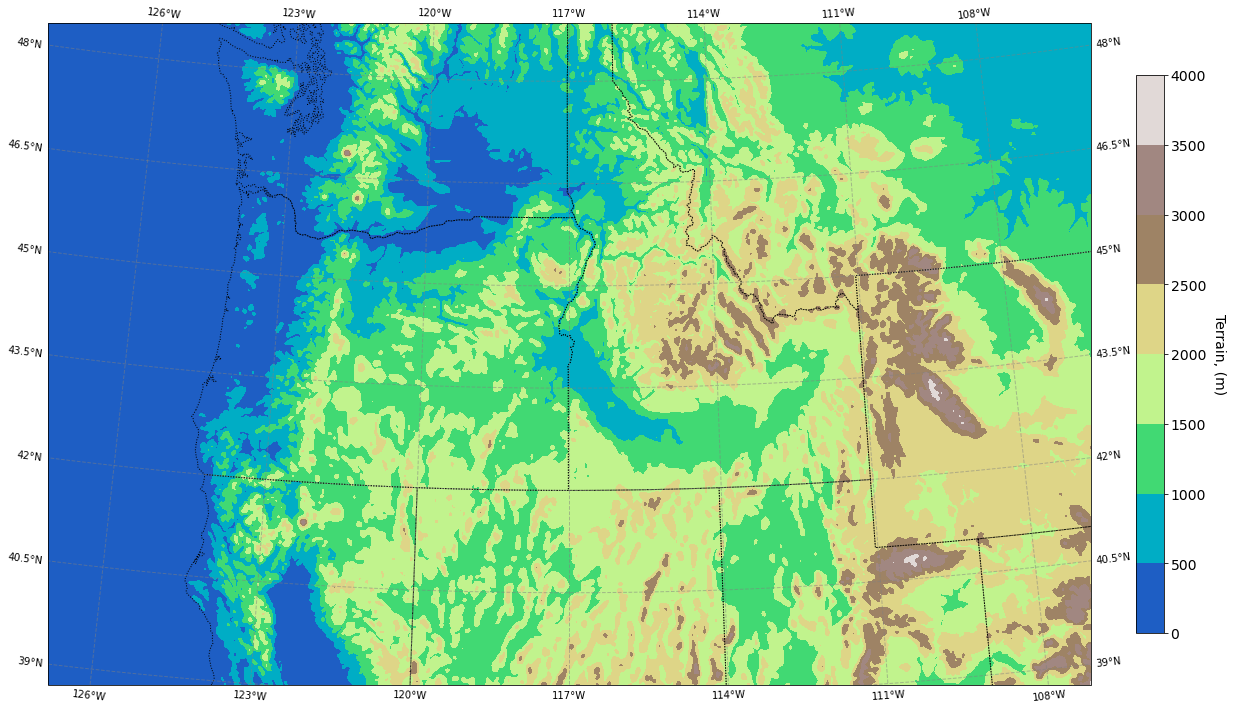

In [5]:
# Get lats and lons in better format than XLAT/XLONG
lats, lons = latlon_coords(Ter_big_dom)

# Setup figure and projection
fig = plt.figure(figsize = (20,15))
ax = plt.axes(projection=cart_proj_big_dom, transform=ccrs.PlateCarree())

# Add state lines
ax.add_feature(cfeature.STATES, linestyle=':')

# Contour Plot
cs = ax.contourf(lons, lats, Ter_big_dom, cmap=get_cmap("terrain"),
                 transform = ccrs.PlateCarree())

# Define the xticks for longitude
plt.xticks(fontsize = 14)
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
plt.yticks(fontsize = 14)
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Add lat/lon Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True, x_inline = False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Colorbar
cbar = fig.colorbar(cs, fraction = 0.025, pad = 0.04)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = "Terrain, (m)", fontsize = 14, 
               rotation = 270, labelpad = 20)

plt.show()

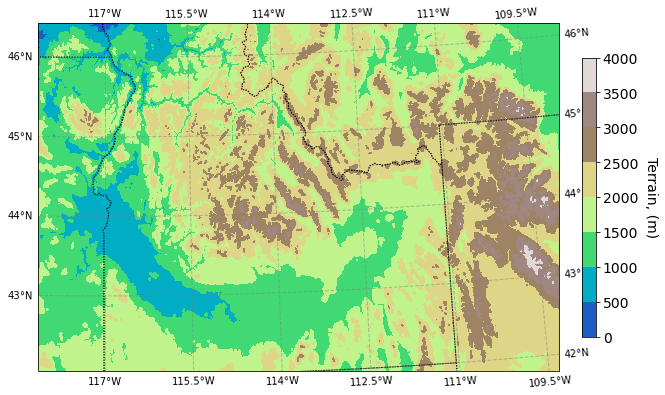

In [6]:
# Get lats and lons in better format than XLAT/XLONG
lats, lons = latlon_coords(Ter_dom)

# Setup figure and projection
fig = plt.figure(figsize = (10,8))
ax = plt.axes(projection=cart_proj_dom, transform=ccrs.PlateCarree())

# Add state lines
ax.add_feature(cfeature.STATES, linestyle=':')

# Contour Plot
cs = ax.contourf(lons, lats, Ter_dom, cmap=get_cmap("terrain"),
                 transform = ccrs.PlateCarree())

# Define the xticks for longitude
plt.xticks(fontsize = 14)
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
plt.yticks(fontsize = 14)
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Add lat/lon Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True, x_inline = False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Colorbar
cbar = fig.colorbar(cs, fraction = 0.025, pad = 0.04)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = "Terrain, (m)", fontsize = 14, 
               rotation = 270, labelpad = 20)

plt.show()

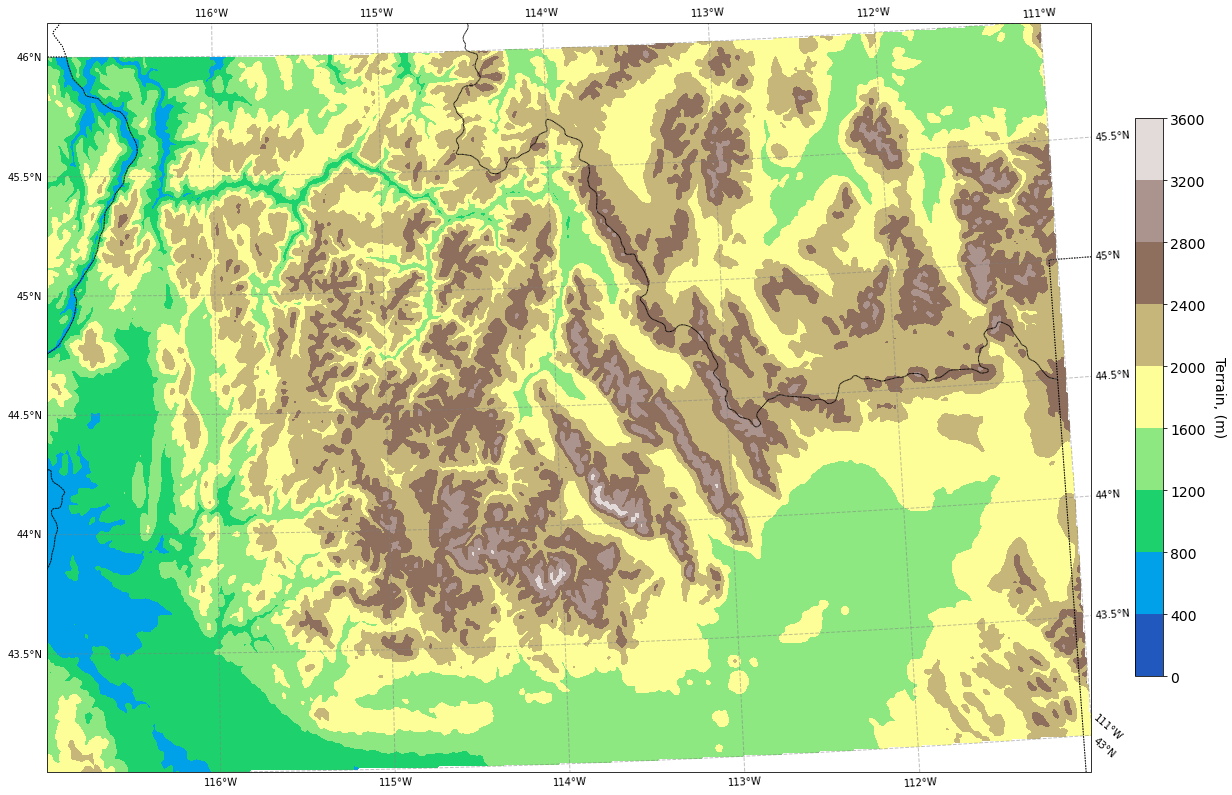

In [7]:
# Get lats and lons in better format than XLAT/XLONG
lats, lons = latlon_coords(Ter_aoi)

# Setup figure and projection
fig = plt.figure(figsize = (20,15))
ax = plt.axes(projection=cart_proj_aoi, transform=ccrs.PlateCarree())

# Add state lines
ax.add_feature(cfeature.STATES, linestyle=':')

# Contour Plot
cs = ax.contourf(lons, lats, Ter_aoi, cmap=get_cmap("terrain"),
                 transform = ccrs.PlateCarree())

# Define the xticks for longitude
plt.xticks(fontsize = 14)
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
plt.yticks(fontsize = 14)
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Add lat/lon Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True, x_inline = False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Colorbar
cbar = fig.colorbar(cs, fraction = 0.025, pad = 0.04)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = "Terrain, (m)", fontsize = 14, 
               rotation = 270, labelpad = 20)

plt.show()

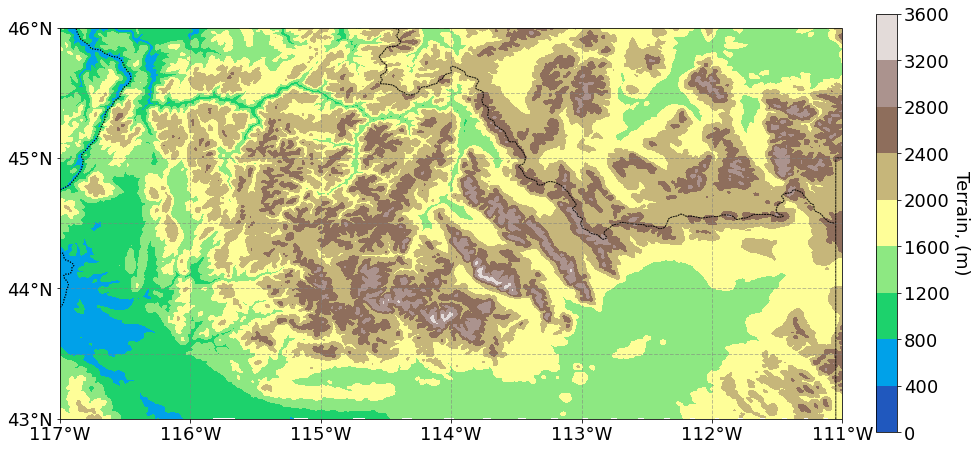

In [8]:
# Get lats and lons in better format than XLAT/XLONG
lats, lons = latlon_coords(Ter_aoi)

# Setup figure and projection
fig = plt.figure(figsize = (15,8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add state lines
ax.add_feature(cfeature.STATES, linestyle=':')

# Contour Plot
cs = ax.contourf(lons, lats, Ter_aoi, cmap=get_cmap("terrain"),
                 transform = ccrs.PlateCarree())

# Define the xticks for longitude
plt.xticks(fontsize = 18)
ax.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
plt.yticks(fontsize = 18)
ax.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Add lat/lon Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Set Limits
ax.set_ylim([43,46])
ax.set_xlim([-117,-111])

# Colorbar
cbar = fig.colorbar(cs, fraction = 0.025, pad = 0.04)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = "Terrain, (m)", fontsize = 18, 
               rotation = 270, labelpad = 20)

# Add (a) or (b) text
# plt.text(-111.25, 45.82, "(a)", fontsize = 16, weight = 'bold')

plt.show()

- Figure 1

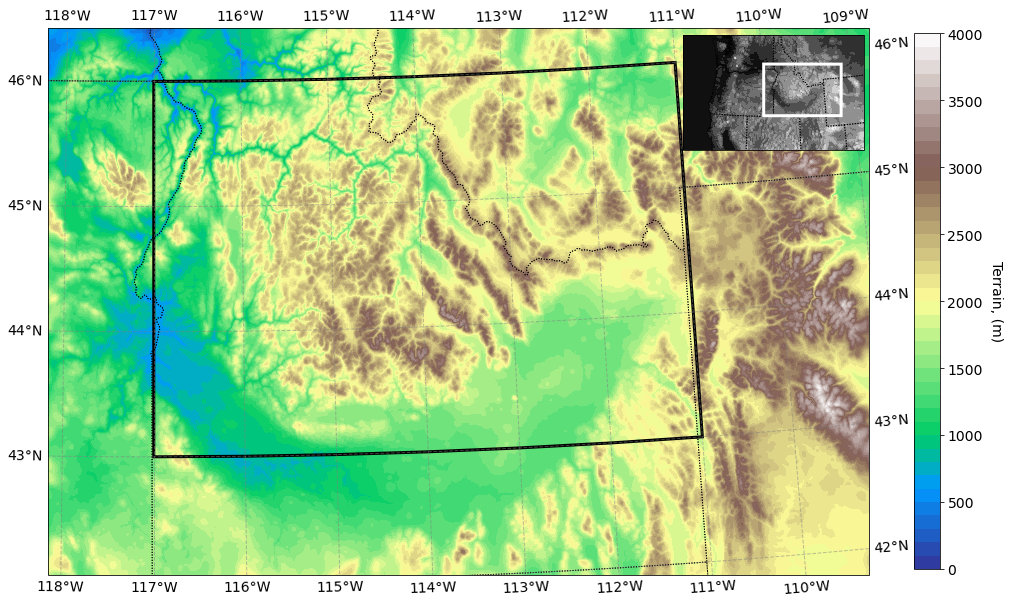

In [9]:
# Get lats and lons in better format than XLAT/XLONG
lats, lons = latlon_coords(Ter_dom)

# Setup figure and projection
fig = plt.figure(figsize = (16,12))
ax = plt.axes(projection=cart_proj_dom, transform=ccrs.PlateCarree())

# Add state lines
ax.add_feature(cfeature.STATES, linestyle=':')

# Draw Area of Interest
poly_corners = np.array([[-117, 43], [-116, 43], [-115, 43], [-114, 43], [-113, 43], [-112, 43], [-111, 43], 
                         [-111, 46], [-112, 46], [-113, 46], [-114, 46], [-115, 46], [-116, 46], [-117, 46]])
poly = mpatches.Polygon(poly_corners, closed=True, fill=False, lw=3, fc=None, transform=ccrs.PlateCarree())
ax.add_patch(poly)

# Contour Terrain Plot
levels = np.arange(0,4100,100).tolist()
cs = ax.contourf(lons, lats, Ter_dom, cmap=get_cmap("terrain"),
                 levels = levels, transform = ccrs.PlateCarree())

# Define the xticks for longitude
plt.xticks(fontsize = 14)
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
plt.yticks(fontsize = 14)
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Add lat/lon Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True, x_inline = False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator([-118, -117, -116, -115, -114, -113, -112, -111, -110, -109])
gl.ylocator = mticker.FixedLocator([42, 43, 44, 45, 46])
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

# Colorbar
cbar = fig.colorbar(cs, fraction = 0.03, pad = 0.05)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = "Terrain, (m)", fontsize = 14, 
               rotation = 270, labelpad = 20)

# Add Inset Axes
axins = inset_axes(ax, width="22%", height="22%",
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cart_proj_big_dom))

lats, lons = latlon_coords(Ter_big_dom)
cs2 = axins.contourf(lons, lats, Ter_big_dom, cmap=get_cmap("gray"),
                 transform = ccrs.PlateCarree())
axins.add_feature(cfeature.STATES, linestyle=':')

poly_corners = np.array([[-118.14, 42.05], 
                         [-109.33, 41.8],
                         [-108.74, 46.14],
                         [-118.23, 46.43]])

poly = mpatches.Polygon(poly_corners, closed=True, fill=False, ec='white', 
                        lw=3, fc=None, transform=ccrs.PlateCarree(), zorder = 3)
axins.add_patch(poly)

# Show Plot
plt.show()

- Final Figure for Publication (5.5" width)

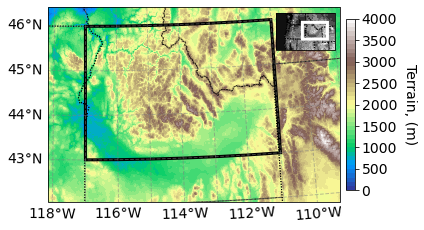

In [10]:
# Get lats and lons in better format than XLAT/XLONG
lats, lons = latlon_coords(Ter_dom)

# Setup figure and projection
fig = plt.figure()
fig.set_size_inches(5.5, 5.5)

ax = plt.axes(projection=cart_proj_dom, transform=ccrs.PlateCarree())

# Add state lines
ax.add_feature(cfeature.STATES, linestyle=':')

# Draw Area of Interest
poly_corners = np.array([[-117, 43], [-116, 43], [-115, 43], [-114, 43], [-113, 43], [-112, 43], [-111, 43], 
                         [-111, 46], [-112, 46], [-113, 46], [-114, 46], [-115, 46], [-116, 46], [-117, 46]])
poly = mpatches.Polygon(poly_corners, closed=True, fill=False, lw=3, fc=None, transform=ccrs.PlateCarree())
ax.add_patch(poly)

# Contour Terrain Plot
levels = np.arange(0,4100,100).tolist()
cs = ax.contourf(lons, lats, Ter_dom, cmap=get_cmap("terrain"),
                 levels = levels, transform = ccrs.PlateCarree())

# Define the xticks for longitude
plt.xticks(fontsize = 14)
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
plt.yticks(fontsize = 14)
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Add lat/lon Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True, x_inline = False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator([-118, -117, -116, -115, -114, -113, -112, -111, -110, -109])
gl.ylocator = mticker.FixedLocator([42, 43, 44, 45, 46])
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
gl.top_labels = False
gl.right_labels = False

# Colorbar
cbar = fig.colorbar(cs, fraction = 0.028, pad = 0.02)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = "Terrain, (m)", fontsize = 14, 
               rotation = 270, labelpad = 20)

# Add Inset Axes
axins = inset_axes(ax, width="20%", height="20%",
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cart_proj_big_dom))

lats, lons = latlon_coords(Ter_big_dom)
cs2 = axins.contourf(lons, lats, Ter_big_dom, cmap=get_cmap("gray"),
                 transform = ccrs.PlateCarree())
axins.add_feature(cfeature.STATES, linestyle=':')

poly_corners = np.array([[-118.14, 42.05], 
                         [-109.33, 41.8],
                         [-108.74, 46.14],
                         [-118.23, 46.43]])

poly = mpatches.Polygon(poly_corners, closed=True, fill=False, ec='white', 
                        lw=3, fc=None, transform=ccrs.PlateCarree(), zorder = 3)
axins.add_patch(poly)

# Show Plot
plt.show()

## Figure 2 - Spatial Snowfall / Rainfall

- Snowfall

In [11]:
SNOWNC_snowie = xr.open_dataarray(Saved_Data_Path + '/SNOWNC_snowie.nc')

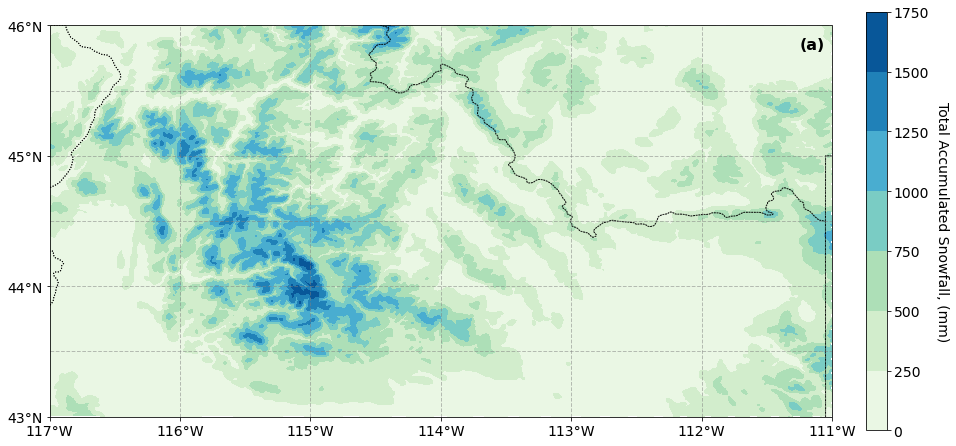

In [12]:
# Get lats and lons in better format than XLAT/XLONG
lats, lons = latlon_coords(SNOWNC_snowie)

# Setup figure and projection
fig = plt.figure(figsize = (15,8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add state lines
ax.add_feature(cfeature.STATES, linestyle=':')

# Contour Plot
cs = ax.contourf(lons, lats, SNOWNC_snowie[-1], cmap=get_cmap("GnBu"),
                 transform = ccrs.PlateCarree())

# Define the xticks for longitude
plt.xticks(fontsize = 14)
ax.set_xticks(np.arange(-117,-110,1), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
plt.yticks(fontsize = 14)
ax.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Add lat/lon Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Set Limits
ax.set_ylim([43,46])
ax.set_xlim([-117,-111])

# Colorbar
cbar = fig.colorbar(cs, fraction = 0.025, pad = 0.04)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = "Total Accumulated Snowfall, (mm)", fontsize = 14, 
               rotation = 270, labelpad = 20)

# Add (a) or (b) text
plt.text(-111.25, 45.82, "(a)", fontsize = 16, weight = 'bold')

plt.show()

- Rainfall

In [13]:
RAINNC_snowie = xr.open_dataarray(Saved_Data_Path + '/RAINNC_snowie.nc')

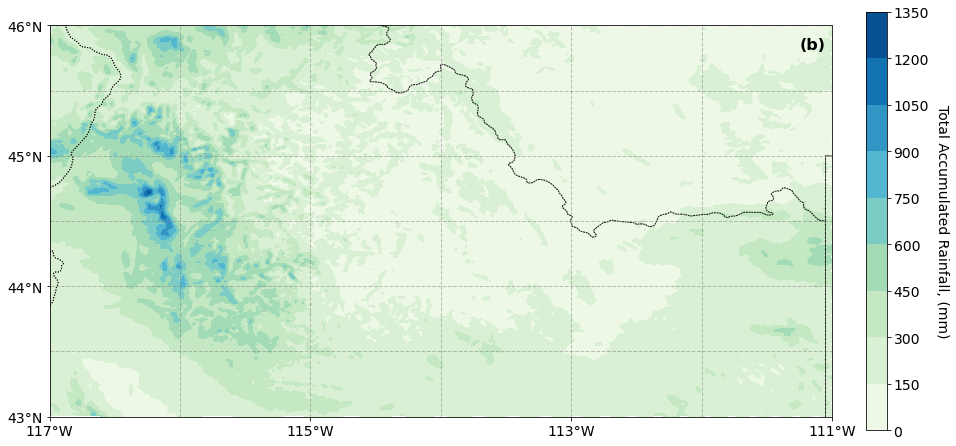

In [14]:
# Get lats and lons in better format than XLAT/XLONG
lats, lons = latlon_coords(RAINNC_snowie)

# Setup figure and projection
fig = plt.figure(figsize = (15,8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add state lines
ax.add_feature(cfeature.STATES, linestyle=':')

# Contour Plot
cs = ax.contourf(lons, lats, RAINNC_snowie[-1]-SNOWNC_snowie[-1], cmap=get_cmap("GnBu"),
                 transform = ccrs.PlateCarree())

# Define the xticks for longitude
plt.xticks(fontsize = 14)
ax.set_xticks(np.arange(-117,-110,2), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
plt.yticks(fontsize = 14)
ax.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Add lat/lon Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Set Limits
ax.set_ylim([43,46])
ax.set_xlim([-117,-111])

# Colorbar
cbar = fig.colorbar(cs, fraction = 0.025, pad = 0.04)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = "Total Accumulated Rainfall, (mm)", fontsize = 14, 
               rotation = 270, labelpad = 20)

# Add (a) or (b) text
plt.text(-111.25, 45.82, "(b)", fontsize = 16, weight = 'bold')

plt.show()

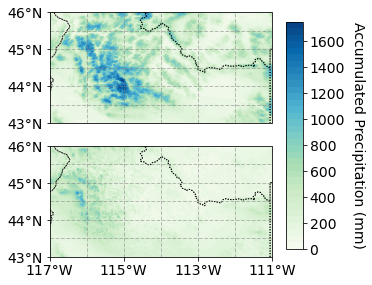

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1, projection = ccrs.PlateCarree())
ax2 = fig.add_subplot(2,1,2, projection = ccrs.PlateCarree())

# Add state lines
ax1.add_feature(cfeature.STATES, linestyle=':')
ax2.add_feature(cfeature.STATES, linestyle=':')

levels = np.arange(0,1800,50).tolist()

# Contour Plot
cs1 = ax1.contourf(lons, lats, SNOWNC_snowie[-1], cmap=get_cmap("GnBu"),
                 levels = levels, transform = ccrs.PlateCarree())
cs2 = ax2.contourf(lons, lats, RAINNC_snowie[-1]-SNOWNC_snowie[-1], cmap=get_cmap("GnBu"),
                 levels = levels, transform = ccrs.PlateCarree())

# Define the xticks for longitude
# ax1.set_xticks(np.arange(-117,-110,2), crs=ccrs.PlateCarree())
ax2.set_xticks(np.arange(-117,-110,2), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
# ax1.xaxis.set_major_formatter(lon_formatter)
ax2.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
ax1.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(46,42,-1), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)

# Change Label Size of Ticks
ax1.tick_params(labelsize = 14)
ax2.tick_params(labelsize = 14)

# Add lat/lon Gridlines
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), 
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Set Limits
ax1.set_ylim([43,46])
ax1.set_xlim([-117,-111])
ax2.set_ylim([43,46])
ax2.set_xlim([-117,-111])

# Add (a) or (b) text
# ax1.text(-111.5, 45.7, "(a)", fontsize = 14, weight = 'bold')
# ax2.text(-111.5, 45.7, "(b)", fontsize = 14, weight = 'bold')

# Colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
cbar = fig.colorbar(cs1, cax=cbar_ax)
cbar.set_label(label = "Accumulated Precipitation (mm)", fontsize = 14,
              rotation = 270, labelpad = 20)
cbar.ax.tick_params(labelsize=14)

# Set Figure Size in Inches
fig.set_size_inches(4.5, 4.5)

## Figure 3 - Line Plot of Snowfall / Rainfall

In [16]:
RAINNC_snowie_dailymean = RAINNC_snowie.resample(Time='1D').last()
SNOWNC_snowie_dailymean = SNOWNC_snowie.resample(Time='1D').last()

RAINNC_spatial_avg_dailymean = np.zeros(212)
RAINNC_spatial_avg_dailymean_a1500 = np.zeros(212)
RAINNC_spatial_avg_dailymean_a2000 = np.zeros(212)
RAINNC_spatial_avg_dailymean_a2500 = np.zeros(212)
SNOWNC_spatial_avg_dailymean = np.zeros(212)
SNOWNC_spatial_avg_dailymean_a1500 = np.zeros(212)
SNOWNC_spatial_avg_dailymean_a2000 = np.zeros(212)
SNOWNC_spatial_avg_dailymean_a2500 = np.zeros(212)

for i in range (0,212):
    RAINNC_spatial_avg_dailymean[i] = RAINNC_snowie_dailymean[i,:,:].mean() 
    RAINNC_spatial_avg_dailymean_a1500[i] = RAINNC_snowie_dailymean.where(Ter_aoi >= 1500)[i,:,:].mean()
    RAINNC_spatial_avg_dailymean_a2000[i] = RAINNC_snowie_dailymean.where(Ter_aoi >= 2000)[i,:,:].mean()    
    RAINNC_spatial_avg_dailymean_a2500[i] = RAINNC_snowie_dailymean.where(Ter_aoi >= 2500)[i,:,:].mean()  
    SNOWNC_spatial_avg_dailymean[i] = SNOWNC_snowie_dailymean[i,:,:].mean() 
    SNOWNC_spatial_avg_dailymean_a1500[i] = SNOWNC_snowie_dailymean.where(Ter_aoi >= 1500)[i,:,:].mean()
    SNOWNC_spatial_avg_dailymean_a2000[i] = SNOWNC_snowie_dailymean.where(Ter_aoi >= 2000)[i,:,:].mean()    
    SNOWNC_spatial_avg_dailymean_a2500[i] = SNOWNC_snowie_dailymean.where(Ter_aoi >= 2500)[i,:,:].mean()  

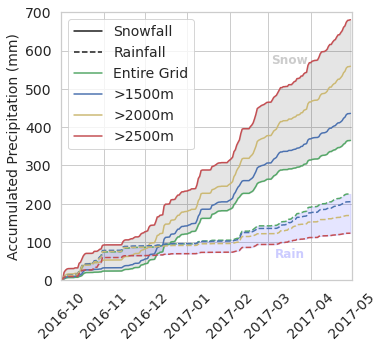

In [17]:
fig = plt.figure()
sns.set(style="whitegrid")

# For the Legend
plt.plot([0, 10, 20],[-1,-1,-1], 'k-')
plt.plot([0, 10, 20],[-1,-1,-1], 'k--')

# Snow
plt.plot(SNOWNC_snowie_dailymean.Time,SNOWNC_spatial_avg_dailymean, 'g-', linewidth = 1.5)
plt.plot(SNOWNC_snowie_dailymean.Time,SNOWNC_spatial_avg_dailymean_a1500, 'b-', linewidth = 1.5)
plt.plot(SNOWNC_snowie_dailymean.Time,SNOWNC_spatial_avg_dailymean_a2000, 'y-', linewidth = 1.5)
plt.plot(SNOWNC_snowie_dailymean.Time,SNOWNC_spatial_avg_dailymean_a2500, 'r-', linewidth = 1.5)

# Rain
plt.plot(RAINNC_snowie_dailymean.Time,RAINNC_spatial_avg_dailymean - SNOWNC_spatial_avg_dailymean, 'g--', linewidth = 1.5)
plt.plot(RAINNC_snowie_dailymean.Time,RAINNC_spatial_avg_dailymean_a1500 - SNOWNC_spatial_avg_dailymean_a1500, 'b--', linewidth = 1.5)
plt.plot(RAINNC_snowie_dailymean.Time,RAINNC_spatial_avg_dailymean_a2000 - SNOWNC_spatial_avg_dailymean_a2000, 'y--', linewidth = 1.5)
plt.plot(RAINNC_snowie_dailymean.Time,RAINNC_spatial_avg_dailymean_a2500 - SNOWNC_spatial_avg_dailymean_a2500, 'r--', linewidth = 1.5)

# Fill-Between
plt.fill_between(SNOWNC_snowie_dailymean.Time,SNOWNC_spatial_avg_dailymean, SNOWNC_spatial_avg_dailymean_a2500, color = 'black', alpha = 0.1)
plt.fill_between(RAINNC_snowie_dailymean.Time,RAINNC_spatial_avg_dailymean - SNOWNC_spatial_avg_dailymean,
                 RAINNC_spatial_avg_dailymean_a2500 - SNOWNC_spatial_avg_dailymean_a2500, color = 'blue', alpha = 0.1)

# Limits
xlims = [datetime.date(2016, 10, 1), datetime.date(2017, 5, 1)]
ylims_both = [0, 700]

plt.xlim(xlims)
plt.ylim(ylims_both)

# Legend
plt.legend(labels = ["Snowfall", "Rainfall", "Entire Grid", ">1500m", ">2000m", ">2500m"], fontsize = 14)

# Labels
plt.ylabel("Accumulated Precipitation (mm)", fontsize = 14)
plt.xticks(fontsize = 14, rotation = 45)
plt.yticks(fontsize = 14)

# Text
plt.text(datetime.date(2017, 3, 6), 59, "Rain", fontsize = 12, color = 'blue', alpha = 0.2, weight = 'bold')
plt.text(datetime.date(2017, 3, 3), 565, "Snow", fontsize = 12, color = 'black', alpha = 0.2, weight = 'bold')

# Set Figure Size in Inches
fig.set_size_inches(5.5, 5)
fig.tight_layout()

plt.show()

## Figure 4 - Boxplot of Monthly Snowfall

- Load Event Indices (previously saved as .csv's)

In [18]:
SNOWNC_snowie = xr.open_dataarray(Saved_Data_Path + '/SNOWNC_snowie.nc')
MonthlyLastTimestep = [0, 744, 1464, 2208, 2952, 3624, 4368, 5088]
Months = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr"]

with open(Saved_Data_Path + 'EventLengths.csv') as f:
    reader = csv.reader(f)
    EventLengths = list(reader)
EventLengths = EventLengths[0]
EventLengths = [int(i) for i in EventLengths]

with open(Saved_Data_Path + 'EventTimesStart.csv') as f:
    reader = csv.reader(f)
    EventTimesStart = list(reader)
EventTimesStart = EventTimesStart[0]
EventTimesStart = [int(i) for i in EventTimesStart]

with open(Saved_Data_Path + 'EventTimesEnd.csv') as f:
    reader = csv.reader(f)
    EventTimesEnd = list(reader)
EventTimesEnd = EventTimesEnd[0]
EventTimesEnd = [int(i) for i in EventTimesEnd]

with open(Saved_Data_Path + 'SnowfallEventNumbered.csv') as f:
    reader = csv.reader(f)
    SnowfallEventNumbered = list(reader)
SnowfallEventNumbered = SnowfallEventNumbered[0]
SnowfallEventNumbered = [int(float(i)) for i in SnowfallEventNumbered]

with open(Saved_Data_Path + 'MonthlyEventIndices.csv') as f:
    reader = csv.reader(f)
    MonthlyEventIndices = list(reader)
MonthlyEventIndices = MonthlyEventIndices[0]
MonthlyEventIndices = [int(i) for i in MonthlyEventIndices]

with open(Saved_Data_Path + 'EventPrecip.csv') as f:
    reader = csv.reader(f)
    EventPrecip = list(reader)
EventPrecip = EventPrecip[0]
EventPrecip = [float(i) for i in EventPrecip]

- Monthly Averages

In [19]:
SNOWNC_snowie_monthlymean = SNOWNC_snowie.resample(Time='1M').last()

SNOWNC_spatial_avg_monthlymean = np.zeros(7)
for i in range(0,len(Months)):
    SNOWNC_spatial_avg_monthlymean[i] = SNOWNC_snowie_monthlymean[i,:,:].mean() 

- Apply Event Thresholds

In [20]:
SNOWNC_snowie_notaccum = SNOWNC_snowie * 0

for i in range(0,len(SNOWNC_snowie)):
    if i == 0:
        SNOWNC_snowie_notaccum[i,:,:] =  SNOWNC_snowie[i,:,:]
    else:
        SNOWNC_snowie_notaccum[i,:,:] =  SNOWNC_snowie[i,:,:] - SNOWNC_snowie[i-1,:,:]
        
SNOWNC_snowie_notaccum_avg = np.zeros(5088)
for i in range (0,5088):
    SNOWNC_snowie_notaccum_avg[i] = SNOWNC_snowie_notaccum[i,:,:].mean()

In [21]:
SnowfallBelowThreshold = np.zeros(5088)
SnowfallEventNumbered = np.zeros(5088)
EventLengths = []

SnowfallThreshold = 0.025  # mm 

for i in range(0,len(SnowfallBelowThreshold)):
    if SNOWNC_snowie_notaccum_avg[i] < SnowfallThreshold:
        SnowfallBelowThreshold[i] = 0
    else:
        SnowfallBelowThreshold[i] = SNOWNC_snowie_notaccum_avg[i]

EventTimeThreshold = 3  # hours

n = 1  # event counter
x = 1  # event length
j = 1  # hour counter

for i in range(0,len(SnowfallBelowThreshold)):
    j = 1
    if SnowfallBelowThreshold[i] == 0:
        if x > 1:
            x += 1
            SnowfallEventNumbered[i] = n
            continue
        else:
            continue
    else:
        SnowfallEventNumbered[i] = n
        while (j <= EventTimeThreshold and i+j < 5088):
            if SnowfallBelowThreshold[i+j] > 0:
                x += 1
                break
            if j == EventTimeThreshold:
                n += 1
                EventLengths.append(x)
                x = 1
            j += 1

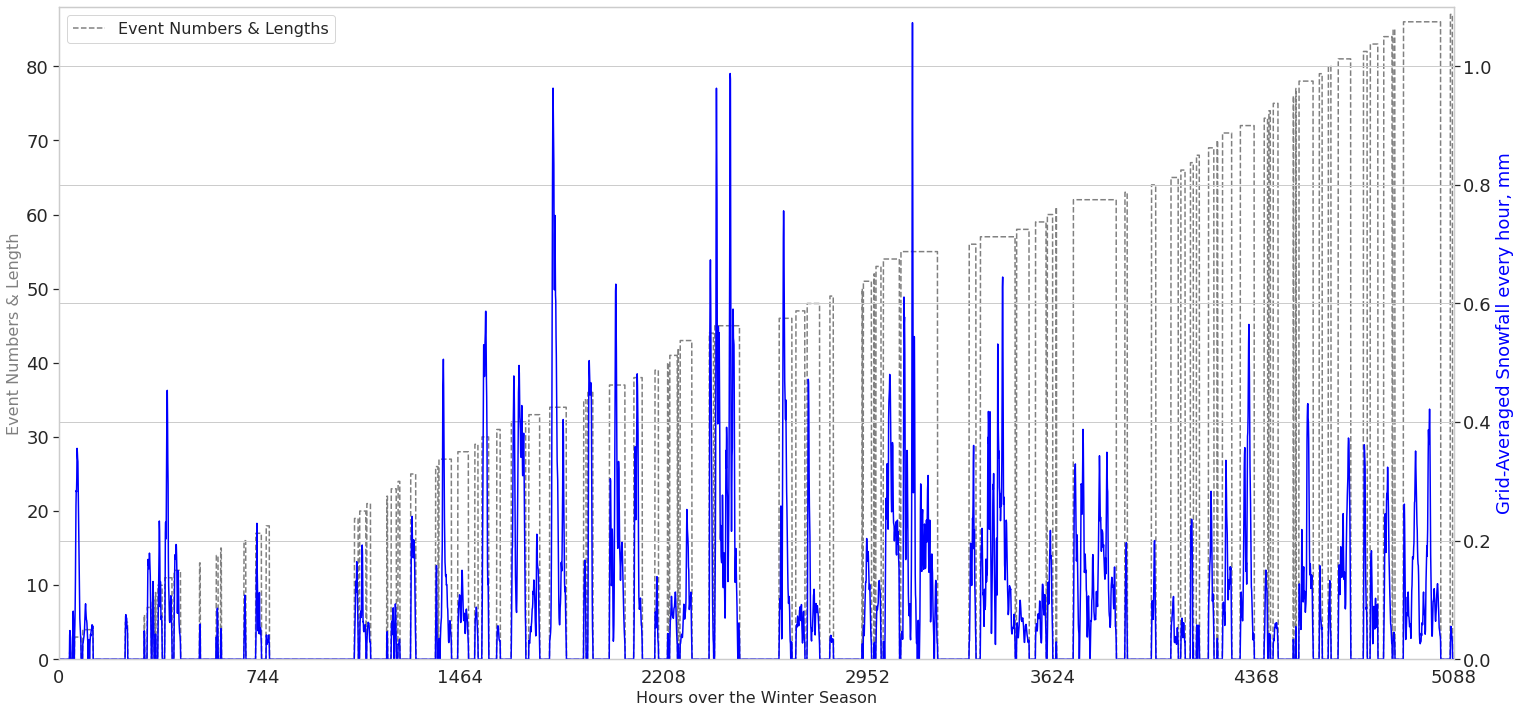

In [22]:
fig,ax = plt.subplots(figsize=[25,12])
ax.plot(SnowfallEventNumbered,'--', color="grey")
# ax.set_title("October, 2016", fontsize = 16)
ax.set_ylabel("Event Numbers & Length", color = "grey", fontsize=16)
ax.set_xlabel("Hours over the Winter Season", fontsize=16)
ax.set_xlim([0,5088])
ax.set_ylim([0,88])
ax.legend(labels = ["Event Numbers & Lengths"], loc = 'upper left', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=18)
ax2 = ax.twinx()
ax2.plot(SnowfallBelowThreshold, color="blue")
ax2.set_ylabel("Grid-Averaged Snowfall every hour, mm", color="blue", fontsize=18)
ax.set_xticks([0, 744, 1464, 2208, 2952, 3624,4368, 5088])
ax.set_xticklabels([0, 744, 1464, 2208, 2952, 3624,4368, 5088])
ax2.tick_params(axis='both', which='major', labelsize=18)
ax.grid()
ax2.set_ylim([0,1.1])
ax2.set_xlabel("Hours in the Simulation", fontsize = 18)
# ax.legend(labels = ["Snowfall"], fontsize = 16)
i=0

- Event Precipitation

In [23]:
EventPrecip = np.zeros(len(EventLengths))

for i in range(0,len(EventPrecip)):
    EventPrecip[i] = sum(SnowfallBelowThreshold[EventTimesStart[i]:EventTimesEnd[i]])

- Number of Events

In [24]:
EventByMonth = []
j = 0

for i in range(0,len(EventPrecip)):
    if i < MonthlyEventIndices[j]:
        EventByMonth.append(Months[j])
    else:
        j+=1
        EventByMonth.append(Months[j])

data = {'Event Precipitation': EventPrecip,
        'Months': EventByMonth}

df = pd.DataFrame(data)

- Medians and Percentage

In [25]:
medians = np.zeros(7)
medians[0] = df.loc[df.Months == 'Oct']['Event Precipitation'].median()
medians[1] = df.loc[df.Months == 'Nov']['Event Precipitation'].median()
medians[2] = df.loc[df.Months == 'Dec']['Event Precipitation'].median()
medians[3] = df.loc[df.Months == 'Jan']['Event Precipitation'].median()
medians[4] = df.loc[df.Months == 'Feb']['Event Precipitation'].median()
medians[5] = df.loc[df.Months == 'Mar']['Event Precipitation'].median()
medians[6] = df.loc[df.Months == 'Apr']['Event Precipitation'].median()

percenttotal = np.zeros(7)
percenttotal[0] = df.loc[df.Months == 'Oct']['Event Precipitation'].sum()
percenttotal[1] = df.loc[df.Months == 'Nov']['Event Precipitation'].sum()
percenttotal[2] = df.loc[df.Months == 'Dec']['Event Precipitation'].sum()
percenttotal[3] = df.loc[df.Months == 'Jan']['Event Precipitation'].sum()
percenttotal[4] = df.loc[df.Months == 'Feb']['Event Precipitation'].sum()
percenttotal[5] = df.loc[df.Months == 'Mar']['Event Precipitation'].sum()
percenttotal[6] = df.loc[df.Months == 'Apr']['Event Precipitation'].sum()
percenttotal = 100 * percenttotal / df.sum()[0]

- Boxplot

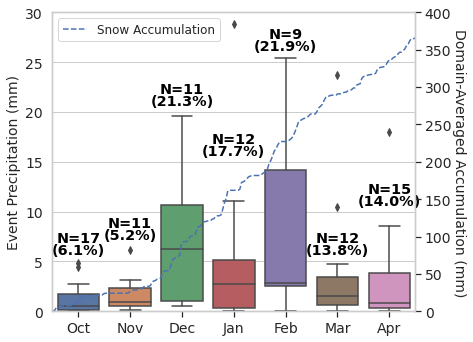

In [26]:
sns.set(rc={'figure.figsize':(6.5,5.5)})
sns.set(style="whitegrid")

# Boxplot
ax = sns.boxplot(x="Months", y="Event Precipitation", data=df, zorder=5)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Second Axis
ax2 = ax.twiny().twinx()
ax2.plot(SNOWNC_snowie_dailymean.Time, SNOWNC_spatial_avg_dailymean, '--', zorder=0)
ax2.set_xlim([SNOWNC_snowie_dailymean[0].Time, SNOWNC_snowie_dailymean.Time[211]])
ax2.set_xticks([])
ax2.grid(False)
ax2.legend(labels=["Snow Accumulation"], loc='upper left', fontsize=12)  # bbox_to_anchor=(0,0.9))
ax2.tick_params(axis='y', labelsize=14)
ax2.set_ylabel('Domain-Averaged Accumulation (mm)', fontsize=14, rotation = 270, labelpad=15)

# Label 1
nobs1 = [df.Months[df.Months == Months[i]].count() for i in range(0, len(Months))]
nobs1 = [str(x) for x in nobs1]
nobs1 = ["N=" + i for i in nobs1]
pos = range(len(nobs1))

ax.text(pos[0], 6.9, nobs1[0], horizontalalignment='center', size='large', 
        color='black', weight='bold', zorder=10)
ax.text(pos[1], 8.4, nobs1[1], horizontalalignment='center', size='large', 
        color='black', weight='bold', zorder=10)
ax.text(pos[2], 21.9, nobs1[2], horizontalalignment='center', size='large', 
        color='black', weight='bold', zorder=10)
ax.text(pos[3], 16.9, nobs1[3], horizontalalignment='center', size='large', 
        color='black', weight='bold', zorder=10)
ax.text(pos[4], 27.4, nobs1[4], horizontalalignment='center', size='large', 
        color='black', weight='bold', zorder=10)
ax.text(pos[5], 6.9, nobs1[5], horizontalalignment='center', size='large', 
        color='black', weight='bold', zorder=10)
ax.text(pos[6], 11.9, nobs1[6], horizontalalignment='center', size='large', 
        color='black', weight='bold', zorder=10)

# Label 2
nobs2 = np.round(percenttotal,1)
nobs2 = [str(x) for x in nobs2.tolist()]
nobs2 = ["(" + i for i in nobs2]

ax.text(pos[0], 5.7, nobs2[0]+"%)", horizontalalignment='center', size='large',
        color='black', weight='bold', zorder=10)
ax.text(pos[1], 7.2, nobs2[1]+"%)", horizontalalignment='center', size='large',
        color='black', weight='bold', zorder=10)
ax.text(pos[2], 20.7, nobs2[2]+"%)", horizontalalignment='center', size='large',
        color='black', weight='bold', zorder=10)
ax.text(pos[3], 15.7, nobs2[3]+"%)", horizontalalignment='center', size='large',
        color='black', weight='bold', zorder=10)
ax.text(pos[4], 26.2, nobs2[4]+"%)", horizontalalignment='center', size='large',
        color='black', weight='bold', zorder=10)
ax.text(pos[5], 5.7, nobs2[5]+"%)", horizontalalignment='center', size='large',
        color='black', weight='bold', zorder=10)
ax.text(pos[6], 10.7, nobs2[6]+"%)", horizontalalignment='center', size='large',
        color='black', weight='bold', zorder=10)

ax.set(ylabel="Event Precipitation (mm)")
ax.set(xlabel=None)
ax.yaxis.label.set_fontsize(14)
ax.set_ylim([0, 30])
ax2.set_ylim([0, 400])


plt.show()

## Figure 5 - Atmospheric Temperature Profiles

In [4]:
z_bins = np.genfromtxt(Saved_Data_Path + 'z_bins.csv', delimiter = ",")
MonthlyLastTimestep = [0, 744, 1463, 2207, 2951, 3623, 4367, 5087]
Months = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr"]
EventsPerMonth = [17, 11, 11, 12, 9, 12, 15]
EventCountsPerMonth = [17, 28, 39, 51, 60, 72, 87]

with open(Saved_Data_Path + 'EventLengths.csv') as f:
    reader = csv.reader(f)
    EventLengths = list(reader)
EventLengths = EventLengths[0]
EventLengths = [int(i) for i in EventLengths]

with open(Saved_Data_Path + 'EventTimesStart.csv') as f:
    reader = csv.reader(f)
    EventTimesStart = list(reader)
EventTimesStart = EventTimesStart[0]
EventTimesStart = [int(i) for i in EventTimesStart]

with open(Saved_Data_Path + 'EventTimesEnd.csv') as f:
    reader = csv.reader(f)
    EventTimesEnd = list(reader)
EventTimesEnd = EventTimesEnd[0]
EventTimesEnd = [int(i) for i in EventTimesEnd]

with open(Saved_Data_Path + 'SnowfallEventNumbered.csv') as f:
    reader = csv.reader(f)
    SnowfallEventNumbered = list(reader)
SnowfallEventNumbered = SnowfallEventNumbered[0]
SnowfallEventNumbered = [int(float(i)) for i in SnowfallEventNumbered]

with open(Saved_Data_Path + 'MonthlyEventIndices.csv') as f:
    reader = csv.reader(f)
    MonthlyEventIndices = list(reader)
MonthlyEventIndices = MonthlyEventIndices[0]
MonthlyEventIndices = [int(i) for i in MonthlyEventIndices]

In [28]:
# Scratch Paths for Temps by month
Oct_Path =  r'/glade/scratch/mwarms/temp/temp_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/temp_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/temp_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/temp_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/temp_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/temp_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/temp_snowie_apr.nc'

# Load Temps
temp_snowie_oct = xr.open_dataarray(Oct_Path)
temp_snowie_nov = xr.open_dataarray(Nov_Path)
temp_snowie_dec = xr.open_dataarray(Dec_Path)
temp_snowie_jan = xr.open_dataarray(Jan_Path)
temp_snowie_feb = xr.open_dataarray(Feb_Path)
temp_snowie_mar = xr.open_dataarray(Mar_Path)
temp_snowie_apr = xr.open_dataarray(Apr_Path)

In [15]:
temp_means_oct = np.zeros(80)
# temp_medians_oct = np.zeros(80)
# temp_95percent_oct = np.zeros(80)
# temp_5percent_oct = np.zeros(80)

for i in range(0,80):
    temp_means_oct[i] = temp_snowie_oct[:,i,:,:].mean()
    # temp_medians_oct[i] = temp_snowie_oct[:,i,:,:].median()
    # temp_95percent_oct[i] = np.nanpercentile(temp_snowie_oct[:,i,:,:], 95)
    # temp_5percent_oct[i] = np.nanpercentile(temp_snowie_oct[:,i,:,:], 5)

In [16]:
temp_means_nov = np.zeros(80)
# temp_medians_nov = np.zeros(80)
# temp_95percent_nov = np.zeros(80)
# temp_5percent_nov = np.zeros(80)

for i in range(0,80):
    temp_means_nov[i] = temp_snowie_nov[:,i,:,:].mean()
    # temp_medians_nov[i] = temp_snowie_nov[:,i,:,:].median()
    # temp_95percent_nov[i] = np.nanpercentile(temp_snowie_nov[:,i,:,:], 95)
    # temp_5percent_nov[i] = np.nanpercentile(temp_snowie_nov[:,i,:,:], 5)

In [17]:
temp_means_dec = np.zeros(80)
# temp_medians_dec = np.zeros(80)
# temp_95percent_dec = np.zeros(80)
# temp_5percent_dec = np.zeros(80)

for i in range(0,80):
    temp_means_dec[i] = temp_snowie_dec[:,i,:,:].mean()
    # temp_medians_dec[i] = temp_snowie_dec[:,i,:,:].median()
    # temp_95percent_dec[i] = np.nanpercentile(temp_snowie_dec[:,i,:,:], 95)
    # temp_5percent_dec[i] = np.nanpercentile(temp_snowie_dec[:,i,:,:], 5)

In [18]:
temp_means_jan = np.zeros(80)
# temp_medians_jan = np.zeros(80)
# temp_95percent_jan = np.zeros(80)
# temp_5percent_jan = np.zeros(80)

for i in range(0,80):
    temp_means_jan[i] = temp_snowie_jan[:,i,:,:].mean()
    # temp_medians_jan[i] = temp_snowie_jan[:,i,:,:].median()
    # temp_95percent_jan[i] = np.nanpercentile(temp_snowie_jan[:,i,:,:], 95)
    # temp_5percent_jan[i] = np.nanpercentile(temp_snowie_jan[:,i,:,:], 5)

In [19]:
temp_means_feb = np.zeros(80)
# temp_medians_feb = np.zeros(80)
# temp_95percent_feb = np.zeros(80)
# temp_5percent_feb = np.zeros(80)

for i in range(0,80):
    temp_means_feb[i] = temp_snowie_feb[:,i,:,:].mean()
    # temp_medians_feb[i] = temp_snowie_feb[:,i,:,:].median()
    # temp_95percent_feb[i] = np.nanpercentile(temp_snowie_feb[:,i,:,:], 95)
    # temp_5percent_feb[i] = np.nanpercentile(temp_snowie_feb[:,i,:,:], 5)

In [20]:
temp_means_mar = np.zeros(80)
# temp_medians_mar = np.zeros(80)
# temp_95percent_mar = np.zeros(80)
# temp_5percent_mar = np.zeros(80)

for i in range(0,80):
    temp_means_mar[i] = temp_snowie_mar[:,i,:,:].mean()
    # temp_medians_mar[i] = temp_snowie_mar[:,i,:,:].median()
    # temp_95percent_mar[i] = np.nanpercentile(temp_snowie_mar[:,i,:,:], 95)
    # temp_5percent_mar[i] = np.nanpercentile(temp_snowie_mar[:,i,:,:], 5)

In [21]:
temp_means_apr = np.zeros(80)
# temp_medians_apr = np.zeros(80)
# temp_95percent_apr = np.zeros(80)
# temp_5percent_apr = np.zeros(80)

for i in range(0,80):
    temp_means_apr[i] = temp_snowie_apr[:,i,:,:].mean()
    # temp_medians_apr[i] = temp_snowie_apr[:,i,:,:].median()
    # temp_95percent_apr[i] = np.nanpercentile(temp_snowie_apr[:,i,:,:], 95)
    # temp_5percent_apr[i] = np.nanpercentile(temp_snowie_apr[:,i,:,:], 5)

In [22]:
temp_snowie_oct_chunked = temp_snowie_oct.chunk({'Time':24, "bottom_top":1})
temp_snowie_nov_chunked = temp_snowie_nov.chunk({'Time':24, "bottom_top":1})
temp_snowie_dec_chunked = temp_snowie_dec.chunk({'Time':24, "bottom_top":1})
temp_snowie_jan_chunked = temp_snowie_jan.chunk({'Time':24, "bottom_top":1})
temp_snowie_feb_chunked = temp_snowie_feb.chunk({'Time':24, "bottom_top":1})
temp_snowie_mar_chunked = temp_snowie_mar.chunk({'Time':24, "bottom_top":1})
temp_snowie_apr_chunked = temp_snowie_apr.chunk({'Time':24, "bottom_top":1})

temp_snowie_chunked = xr.concat([temp_snowie_oct_chunked, temp_snowie_nov_chunked, temp_snowie_dec_chunked, temp_snowie_jan_chunked, 
                                  temp_snowie_feb_chunked, temp_snowie_mar_chunked, temp_snowie_apr_chunked], dim = 'Time')

Atm_Temp_Levels = np.zeros([sum(EventsPerMonth),80])

for i in range(0,80):
    for j in range(0,sum(EventsPerMonth)):
        Atm_Temp_Levels[j,i] = temp_snowie_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:].mean().compute()

OctEventTemps = np.mean(Atm_Temp_Levels[0:EventCountsPerMonth[0],:], axis = 0) 
NovEventTemps = np.mean(Atm_Temp_Levels[EventCountsPerMonth[0]:EventCountsPerMonth[1],:], axis = 0)
DecEventTemps = np.mean(Atm_Temp_Levels[EventCountsPerMonth[1]:EventCountsPerMonth[2],:], axis = 0)
JanEventTemps = np.mean(Atm_Temp_Levels[EventCountsPerMonth[2]:EventCountsPerMonth[3],:], axis = 0)
FebEventTemps = np.mean(Atm_Temp_Levels[EventCountsPerMonth[3]:EventCountsPerMonth[4],:], axis = 0)
MarEventTemps = np.mean(Atm_Temp_Levels[EventCountsPerMonth[4]:EventCountsPerMonth[5],:], axis = 0)
AprEventTemps = np.mean(Atm_Temp_Levels[EventCountsPerMonth[5]:EventCountsPerMonth[6],:], axis = 0)

In [23]:
# Save for later
with open(Saved_Data_Path + 'OctEventTemps.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(OctEventTemps)
with open(Saved_Data_Path + 'NovEventTemps.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(NovEventTemps)
with open(Saved_Data_Path + 'DecEventTemps.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(DecEventTemps)
with open(Saved_Data_Path + 'JanEventTemps.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(JanEventTemps)
with open(Saved_Data_Path + 'FebEventTemps.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(FebEventTemps)
with open(Saved_Data_Path + 'MarEventTemps.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(MarEventTemps)
with open(Saved_Data_Path + 'AprEventTemps.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(AprEventTemps)

In [24]:
with open(Saved_Data_Path + 'temp_means_oct.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(temp_means_oct)
with open(Saved_Data_Path + 'temp_means_nov.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(temp_means_nov)
with open(Saved_Data_Path + 'temp_means_dec.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(temp_means_dec)
with open(Saved_Data_Path + 'temp_means_jan.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(temp_means_jan)
with open(Saved_Data_Path + 'temp_means_feb.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(temp_means_feb)
with open(Saved_Data_Path + 'temp_means_mar.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(temp_means_mar)
with open(Saved_Data_Path + 'temp_means_apr.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(temp_means_apr)

In [5]:
with open(Saved_Data_Path + 'temp_means_oct.csv') as f:
    reader = csv.reader(f)
    temp_means_oct = list(reader)
temp_means_oct = temp_means_oct[0]
temp_means_oct = [float(i) for i in temp_means_oct]
temp_means_oct = np.array(temp_means_oct)

with open(Saved_Data_Path + 'temp_means_nov.csv') as f:
    reader = csv.reader(f)
    temp_means_nov = list(reader)
temp_means_nov = temp_means_nov[0]
temp_means_nov = [float(i) for i in temp_means_nov]
temp_means_nov = np.array(temp_means_nov)

with open(Saved_Data_Path + 'temp_means_dec.csv') as f:
    reader = csv.reader(f)
    temp_means_dec = list(reader)
temp_means_dec = temp_means_dec[0]
temp_means_dec = [float(i) for i in temp_means_dec]
temp_means_dec = np.array(temp_means_dec)

with open(Saved_Data_Path + 'temp_means_jan.csv') as f:
    reader = csv.reader(f)
    temp_means_jan = list(reader)
temp_means_jan = temp_means_jan[0]
temp_means_jan = [float(i) for i in temp_means_jan]
temp_means_jan = np.array(temp_means_jan)

with open(Saved_Data_Path + 'temp_means_feb.csv') as f:
    reader = csv.reader(f)
    temp_means_feb = list(reader)
temp_means_feb = temp_means_feb[0]
temp_means_feb = [float(i) for i in temp_means_feb]
temp_means_feb = np.array(temp_means_feb)

with open(Saved_Data_Path + 'temp_means_mar.csv') as f:
    reader = csv.reader(f)
    temp_means_mar = list(reader)
temp_means_mar = temp_means_mar[0]
temp_means_mar = [float(i) for i in temp_means_mar]
temp_means_mar = np.array(temp_means_mar)

with open(Saved_Data_Path + 'temp_means_apr.csv') as f:
    reader = csv.reader(f)
    temp_means_apr = list(reader)
temp_means_apr = temp_means_apr[0]
temp_means_apr = [float(i) for i in temp_means_apr]
temp_means_apr = np.array(temp_means_apr)

In [6]:
with open(Saved_Data_Path + 'OctEventTemps.csv') as f:
    reader = csv.reader(f)
    OctEventTemps = list(reader)
OctEventTemps = OctEventTemps[0]
OctEventTemps = [float(i) for i in OctEventTemps]
OctEventTemps = np.array(OctEventTemps)

with open(Saved_Data_Path + 'NovEventTemps.csv') as f:
    reader = csv.reader(f)
    NovEventTemps = list(reader)
NovEventTemps = NovEventTemps[0]
NovEventTemps = [float(i) for i in NovEventTemps]
NovEventTemps = np.array(NovEventTemps)

with open(Saved_Data_Path + 'DecEventTemps.csv') as f:
    reader = csv.reader(f)
    DecEventTemps = list(reader)
DecEventTemps = DecEventTemps[0]
DecEventTemps = [float(i) for i in DecEventTemps]
DecEventTemps = np.array(DecEventTemps)

with open(Saved_Data_Path + 'JanEventTemps.csv') as f:
    reader = csv.reader(f)
    JanEventTemps = list(reader)
JanEventTemps = JanEventTemps[0]
JanEventTemps = [float(i) for i in JanEventTemps]
JanEventTemps = np.array(JanEventTemps)

with open(Saved_Data_Path + 'FebEventTemps.csv') as f:
    reader = csv.reader(f)
    FebEventTemps = list(reader)
FebEventTemps = FebEventTemps[0]
FebEventTemps = [float(i) for i in FebEventTemps]
FebEventTemps = np.array(FebEventTemps)

with open(Saved_Data_Path + 'MarEventTemps.csv') as f:
    reader = csv.reader(f)
    MarEventTemps = list(reader)
MarEventTemps = MarEventTemps[0]
MarEventTemps = [float(i) for i in MarEventTemps]
MarEventTemps = np.array(MarEventTemps)

with open(Saved_Data_Path + 'AprEventTemps.csv') as f:
    reader = csv.reader(f)
    AprEventTemps = list(reader)
AprEventTemps = AprEventTemps[0]
AprEventTemps = [float(i) for i in AprEventTemps]
AprEventTemps = np.array(AprEventTemps)

In [58]:
fig = plt.figure(figsize = [20,10])
ax1 = fig.add_subplot(2,4,1)
ax2 = fig.add_subplot(2,4,2)
ax3 = fig.add_subplot(2,4,3)
ax4 = fig.add_subplot(2,4,4)
ax5 = fig.add_subplot(2,4,5)
ax6 = fig.add_subplot(2,4,6)
ax7 = fig.add_subplot(2,4,7)
ax8 = fig.add_subplot(2,4,8)

ax1.plot(temp_medians_oct-273.15, z_bins, 'b')
ax1.plot(temp_95percent_oct-273.15, z_bins, '--b')
ax1.plot(temp_5percent_oct-273.15, z_bins, '--b')
ax1.plot(OctEventTemps-273.15 ,z_bins, 'k', linewidth = 3)
ax1.set_ylim([z_bins[0], z_bins[79]])
ax1.set_xlim([-75, 15])
ax1.grid()
ax1.set_xticks([-60, -40, -20, -0, 20])
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.plot(temp_medians_nov-273.15, z_bins, 'g')
ax2.plot(temp_95percent_nov-273.15, z_bins, '--g')
ax2.plot(temp_5percent_nov-273.15, z_bins, '--g')
ax2.plot(NovEventTemps-273.15,z_bins, 'k', linewidth = 3)
ax2.set_ylim([z_bins[0], z_bins[79]])
ax2.set_xlim([-75, 15])
ax2.grid()
ax2.set_xticks([-60, -40, -20, -0, 20])
ax2.tick_params(axis='both', which='major', labelsize=12)

ax3.plot(temp_medians_dec-273.15, z_bins, 'r')
ax3.plot(temp_95percent_dec-273.15, z_bins, '--r')
ax3.plot(temp_5percent_dec-273.15, z_bins, '--r')
ax3.plot(DecEventTemps-273.15,z_bins, 'k', linewidth = 3)
ax3.set_ylim([z_bins[0], z_bins[79]])
ax3.set_xlim([-75, 15])
ax3.grid()
ax3.set_xticks([-60, -40, -20, -0, 20])
ax3.tick_params(axis='both', which='major', labelsize=12)

ax4.plot(temp_medians_jan-273.15, z_bins, 'c')
ax4.plot(temp_95percent_jan-273.15, z_bins, '--c')
ax4.plot(temp_5percent_jan-273.15, z_bins, '--c')
ax4.plot(JanEventTemps-273.15,z_bins, 'k', linewidth = 3)
ax4.set_ylim([z_bins[0], z_bins[79]])
ax4.set_xlim([-75, 15])
ax4.grid()
ax4.set_xticks([-60, -40, -20, -0, 20])
ax4.tick_params(axis='both', which='major', labelsize=12)

ax5.plot(temp_medians_feb-273.15, z_bins, 'm')
ax5.plot(temp_95percent_feb-273.15, z_bins, '--m')
ax5.plot(temp_5percent_feb-273.15, z_bins, '--m')
ax5.plot(FebEventTemps-273.15,z_bins, 'k', linewidth = 3)
ax5.set_ylim([z_bins[0], z_bins[79]])
ax5.set_xlim([-75, 15])
ax5.grid()
ax5.set_xticks([-60, -40, -20, -0, 20])
ax5.tick_params(axis='both', which='major', labelsize=12)

ax6.plot(temp_medians_mar-273.15, z_bins, 'y')
ax6.plot(temp_95percent_mar-273.15, z_bins, '--y')
ax6.plot(temp_5percent_mar-273.15, z_bins, '--y')
ax6.plot(MarEventTemps-273.15,z_bins, 'k', linewidth = 3)
ax6.set_ylim([z_bins[0], z_bins[79]])
ax6.set_xlim([-75, 15])
ax6.grid()
ax6.set_xticks([-60, -40, -20, -0, 20])
ax6.tick_params(axis='both', which='major', labelsize=12)

ax7.plot(temp_medians_apr-273.15, z_bins, 'orange')
ax7.plot(temp_95percent_apr-273.15, z_bins, '--', color = 'orange')
ax7.plot(temp_5percent_apr-273.15, z_bins, '--', color = 'orange')
ax7.plot(AprEventTemps-273.15,z_bins, 'k', linewidth = 3)
ax7.set_ylim([z_bins[0], z_bins[79]])
ax7.set_xlim([-75, 15])
ax7.grid() 
ax7.set_xticks([-60, -40, -20, -0, 20])
ax7.tick_params(axis='both', which='major', labelsize=12)

ax1.set_title('October', fontsize = 18, weight = 'bold')
ax2.set_title('November', fontsize = 18, weight = 'bold')
ax3.set_title('December', fontsize = 18, weight = 'bold')
ax4.set_title('January', fontsize = 18, weight = 'bold')
ax5.set_title('February', fontsize = 18, weight = 'bold')
ax6.set_title('March', fontsize = 18, weight = 'bold')
ax7.set_title('April', fontsize = 18, weight = 'bold')
ax8.set_title('Event Means', fontsize = 18, weight = 'bold')

ax8.plot(OctEventTemps-273.15, z_bins, 'b', linewidth = 3)
ax8.plot(NovEventTemps-273.15, z_bins, 'g', linewidth = 3)
ax8.plot(DecEventTemps-273.15, z_bins, 'r', linewidth = 3)
ax8.plot(JanEventTemps-273.15, z_bins, 'c', linewidth = 3)
ax8.plot(FebEventTemps-273.15, z_bins, 'm', linewidth = 3)
ax8.plot(MarEventTemps-273.15, z_bins, 'y', linewidth = 3)
ax8.plot(AprEventTemps-273.15, z_bins, 'orange', linewidth = 3)
ax8.set_ylim([z_bins[0], z_bins[79]])
ax8.set_xlim([-75, 15])
ax8.grid()
ax8.legend(labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'], fontsize = 16)
ax8.tick_params(axis='both', which='major', labelsize=12)

ax1.set_ylabel('Altitude, (m)', fontsize = 16, style = 'italic')
ax5.set_ylabel('Altitude, (m)', fontsize = 16, style = 'italic')

ax1.set_xlabel("Temperature ($^\circ$C)", fontsize = 16, style = 'italic')
ax2.set_xlabel("Temperature ($^\circ$C)", fontsize = 16, style = 'italic')
ax3.set_xlabel("Temperature ($^\circ$C)", fontsize = 16, style = 'italic')
ax4.set_xlabel("Temperature ($^\circ$C)", fontsize = 16, style = 'italic')
ax5.set_xlabel("Temperature ($^\circ$C)", fontsize = 16, style = 'italic')
ax6.set_xlabel("Temperature ($^\circ$C)", fontsize = 16, style = 'italic')
ax7.set_xlabel("Temperature ($^\circ$C)", fontsize = 16, style = 'italic')
ax8.set_xlabel("Temperature ($^\circ$C)", fontsize = 16, style = 'italic')

fig.legend(labels = ['Median', '95th percentile', '5th percentile', 'Event Mean'], loc= 'upper center', fontsize = 18, ncol = 4)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.33)

plt.show()

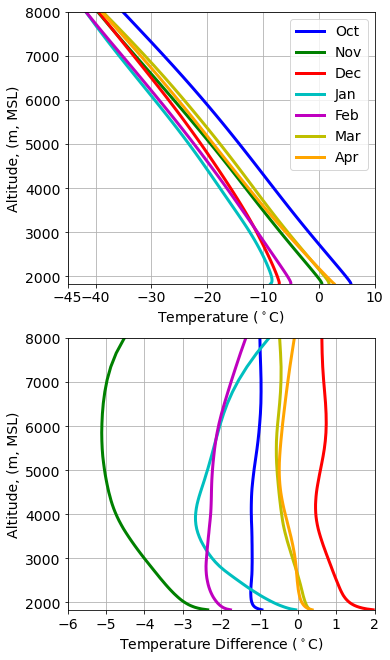

In [32]:
fig = plt.figure(figsize = [15,8])
ax1 = fig.add_subplot(2,1,2)
ax2 = fig.add_subplot(2,1,1)

ax1.plot(OctEventTemps-temp_means_oct, z_bins, 'b', linewidth = 3)
ax1.plot(NovEventTemps-temp_means_nov, z_bins, 'g', linewidth = 3)
ax1.plot(DecEventTemps-temp_means_dec, z_bins, 'r', linewidth = 3)
ax1.plot(JanEventTemps-temp_means_jan, z_bins, 'c', linewidth = 3)
ax1.plot(FebEventTemps-temp_means_feb, z_bins, 'm', linewidth = 3)
ax1.plot(MarEventTemps-temp_means_mar, z_bins, 'y', linewidth = 3)
ax1.plot(AprEventTemps-temp_means_apr, z_bins, 'orange', linewidth = 3)
ax1.set_ylim([z_bins[0], 8000])
ax1.set_xlim([-5.5, 2])
ax1.grid()
ax1.set_xticks([-6, -5, -4, -3, -2, -1, 0, 1, 2])  
ax1.set_yticks([2000, 3000, 4000, 5000, 6000, 7000, 8000])
# ax1.set_yticklabels([])
ax1.tick_params(axis='both', which='major', labelsize=14)
# ax1.legend(labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'], fontsize = 14, bbox_to_anchor = [0.2,1])
ax1.set_xlabel("Temperature Difference ($^\circ$C)", fontsize = 14)
ax1.set_ylabel('Altitude, (m, MSL)', fontsize = 14)
# ax1.set_title('Mean Atm. Temps - Mean Event Temps', fontsize = 14, weight = 'bold')

ax2.plot(OctEventTemps-273.15, z_bins, 'b', linewidth = 3)
ax2.plot(NovEventTemps-273.15, z_bins, 'g', linewidth = 3)
ax2.plot(DecEventTemps-273.15, z_bins, 'r', linewidth = 3)
ax2.plot(JanEventTemps-273.15, z_bins, 'c', linewidth = 3)
ax2.plot(FebEventTemps-273.15, z_bins, 'm', linewidth = 3)
ax2.plot(MarEventTemps-273.15, z_bins, 'y', linewidth = 3)
ax2.plot(AprEventTemps-273.15, z_bins, 'orange', linewidth = 3)
ax2.set_ylim([z_bins[0], 8000])
ax2.set_xlim([-45, 10])
ax2.set_xticks([-45, -40,-30, -20,-10, -0, 10])
# ax2.set_yticks([2000, 3000, 4000, 5000, 6000, 7000, 8000])
ax2.legend(labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'], fontsize = 14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel("Temperature ($^\circ$C)", fontsize = 14)
ax2.set_ylabel('Altitude, (m, MSL)', fontsize = 14)
ax2.grid()

# fig.tight_layout()
fig.set_size_inches(5.5,11)
plt.show()

## Figure 6 - Atmospheric Equivalent Temperature Profiles

In [16]:
# Scratch Paths for Temps by month
Oct_Path =  r'/glade/scratch/mwarms/temp/ThetaE_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/ThetaE_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/ThetaE_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/ThetaE_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/ThetaE_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/ThetaE_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/ThetaE_snowie_apr.nc'

# Load Temps
ThetaE_snowie_oct = xr.open_dataarray(Oct_Path)
ThetaE_snowie_nov = xr.open_dataarray(Nov_Path)
ThetaE_snowie_dec = xr.open_dataarray(Dec_Path)
ThetaE_snowie_jan = xr.open_dataarray(Jan_Path)
ThetaE_snowie_feb = xr.open_dataarray(Feb_Path)
ThetaE_snowie_mar = xr.open_dataarray(Mar_Path)
ThetaE_snowie_apr = xr.open_dataarray(Apr_Path)

In [65]:
# ThetaE_medians_oct = np.zeros(80)
ThetaE_means_oct = np.zeros(80)
# ThetaE_95percent_oct = np.zeros(80)
# ThetaE_5percent_oct = np.zeros(80)

for i in range(0,80):
    ThetaE_means_oct[i] = ThetaE_snowie_oct[:,i,:,:].mean()
    # ThetaE_medians_oct[i] = ThetaE_snowie_oct[:,i,:,:].median()
    # ThetaE_95percent_oct[i] = np.nanpercentile(ThetaE_snowie_oct[:,i,:,:], 95)
    # ThetaE_5percent_oct[i] = np.nanpercentile(ThetaE_snowie_oct[:,i,:,:], 5)

In [66]:
# ThetaE_medians_nov = np.zeros(80)
ThetaE_means_nov = np.zeros(80)
# ThetaE_95percent_nov = np.zeros(80)
# ThetaE_5percent_nov = np.zeros(80)

for i in range(0,80):
    ThetaE_means_nov[i] = ThetaE_snowie_nov[:,i,:,:].mean()
    # ThetaE_medians_nov[i] = ThetaE_snowie_nov[:,i,:,:].median()
    # ThetaE_95percent_nov[i] = np.nanpercentile(ThetaE_snowie_nov[:,i,:,:], 95)
    # ThetaE_5percent_nov[i] = np.nanpercentile(ThetaE_snowie_nov[:,i,:,:], 5)

In [67]:
# ThetaE_medians_dec = np.zeros(80)
ThetaE_means_dec = np.zeros(80)
# ThetaE_95percent_dec = np.zeros(80)
# ThetaE_5percent_dec = np.zeros(80)

for i in range(0,80):
    ThetaE_means_dec[i] = ThetaE_snowie_dec[:,i,:,:].mean()
    # ThetaE_medians_dec[i] = ThetaE_snowie_dec[:,i,:,:].median()
    # ThetaE_95percent_dec[i] = np.nanpercentile(ThetaE_snowie_dec[:,i,:,:], 95)
    # ThetaE_5percent_dec[i] = np.nanpercentile(ThetaE_snowie_dec[:,i,:,:], 5)

In [68]:
# ThetaE_medians_jan = np.zeros(80)
ThetaE_means_jan = np.zeros(80)
# ThetaE_95percent_jan = np.zeros(80)
# ThetaE_5percent_jan = np.zeros(80)

for i in range(0,80):
    ThetaE_means_jan[i] = ThetaE_snowie_jan[:,i,:,:].mean()
    # ThetaE_medians_jan[i] = ThetaE_snowie_jan[:,i,:,:].median()
    # ThetaE_95percent_jan[i] = np.nanpercentile(ThetaE_snowie_jan[:,i,:,:], 95)
    # ThetaE_5percent_jan[i] = np.nanpercentile(ThetaE_snowie_jan[:,i,:,:], 5)

In [69]:
# ThetaE_medians_feb = np.zeros(80)
ThetaE_means_feb = np.zeros(80)
# ThetaE_95percent_feb = np.zeros(80)
# ThetaE_5percent_feb = np.zeros(80)

for i in range(0,80):
    ThetaE_means_feb[i] = ThetaE_snowie_feb[:,i,:,:].mean()
    # ThetaE_medians_feb[i] = ThetaE_snowie_feb[:,i,:,:].median()
    # ThetaE_95percent_feb[i] = np.nanpercentile(ThetaE_snowie_feb[:,i,:,:], 95)
    # ThetaE_5percent_feb[i] = np.nanpercentile(ThetaE_snowie_feb[:,i,:,:], 5)

In [70]:
# ThetaE_medians_mar = np.zeros(80)
ThetaE_means_mar = np.zeros(80)
# ThetaE_95percent_mar = np.zeros(80)
# ThetaE_5percent_mar = np.zeros(80)

for i in range(0,80):
    ThetaE_means_mar[i] = ThetaE_snowie_mar[:,i,:,:].mean()
    # ThetaE_medians_mar[i] = ThetaE_snowie_mar[:,i,:,:].median()
    # ThetaE_95percent_mar[i] = np.nanpercentile(ThetaE_snowie_mar[:,i,:,:], 95)
    # ThetaE_5percent_mar[i] = np.nanpercentile(ThetaE_snowie_mar[:,i,:,:], 5)

In [71]:
# ThetaE_medians_apr = np.zeros(80)
ThetaE_means_apr = np.zeros(80)
# ThetaE_95percent_apr = np.zeros(80)
# ThetaE_5percent_apr = np.zeros(80)

for i in range(0,80):
    ThetaE_means_apr[i] = ThetaE_snowie_apr[:,i,:,:].mean()
    # ThetaE_medians_apr[i] = ThetaE_snowie_apr[:,i,:,:].median()
    # ThetaE_95percent_apr[i] = np.nanpercentile(ThetaE_snowie_apr[:,i,:,:], 95)
    # ThetaE_5percent_apr[i] = np.nanpercentile(ThetaE_snowie_apr[:,i,:,:], 5)

In [109]:
ThetaE_snowie_oct_chunked = ThetaE_snowie_oct.chunk({'Time':24, "bottom_top":1})
ThetaE_snowie_nov_chunked = ThetaE_snowie_nov.chunk({'Time':24, "bottom_top":1})
ThetaE_snowie_dec_chunked = ThetaE_snowie_dec.chunk({'Time':24, "bottom_top":1})
ThetaE_snowie_jan_chunked = ThetaE_snowie_jan.chunk({'Time':24, "bottom_top":1})
ThetaE_snowie_feb_chunked = ThetaE_snowie_feb.chunk({'Time':24, "bottom_top":1})
ThetaE_snowie_mar_chunked = ThetaE_snowie_mar.chunk({'Time':24, "bottom_top":1})
ThetaE_snowie_apr_chunked = ThetaE_snowie_apr.chunk({'Time':24, "bottom_top":1})

ThetaE_snowie_chunked = xr.concat([ThetaE_snowie_oct_chunked, ThetaE_snowie_nov_chunked, ThetaE_snowie_dec_chunked, ThetaE_snowie_jan_chunked, 
                                  ThetaE_snowie_feb_chunked, ThetaE_snowie_mar_chunked, ThetaE_snowie_apr_chunked], dim = 'Time')

Atm_ThetaE_Levels = np.zeros([sum(EventsPerMonth),80])

for i in range(0,80):
    for j in range(0,sum(EventsPerMonth)):
        Atm_ThetaE_Levels[j,i] = ThetaE_snowie_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:].mean().compute()

OctEventThetaEs = np.mean(Atm_ThetaE_Levels[0:EventCountsPerMonth[0],:], axis = 0) 
# NovEventThetaEs = np.mean(Atm_ThetaE_Levels[EventCountsPerMonth[0]:EventCountsPerMonth[1],:], axis = 0)
# DecEventThetaEs = np.mean(Atm_ThetaE_Levels[EventCountsPerMonth[1]:EventCountsPerMonth[2],:], axis = 0)
# JanEventThetaEs = np.mean(Atm_ThetaE_Levels[EventCountsPerMonth[2]:EventCountsPerMonth[3],:], axis = 0)
# FebEventThetaEs = np.mean(Atm_ThetaE_Levels[EventCountsPerMonth[3]:EventCountsPerMonth[4],:], axis = 0)
# MarEventThetaEs = np.mean(Atm_ThetaE_Levels[EventCountsPerMonth[4]:EventCountsPerMonth[5],:], axis = 0)
# AprEventThetaEs = np.mean(Atm_ThetaE_Levels[EventCountsPerMonth[5]:EventCountsPerMonth[6],:], axis = 0)

In [110]:
# Save for later
with open(Saved_Data_Path + 'OctEventThetaEs.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(OctEventThetaEs)
# with open(Saved_Data_Path + 'NovEventThetaEs.csv', 'w') as f:
#     write = csv.writer(f)
#     write.writerow(NovEventThetaEs)
# with open(Saved_Data_Path + 'DecEventThetaEs.csv', 'w') as f:
#     write = csv.writer(f)
#     write.writerow(DecEventThetaEs)
# with open(Saved_Data_Path + 'JanEventThetaEs.csv', 'w') as f:
#     write = csv.writer(f)
#     write.writerow(JanEventThetaEs)
# with open(Saved_Data_Path + 'FebEventThetaEs.csv', 'w') as f:
#     write = csv.writer(f)
#     write.writerow(FebEventThetaEs)
# with open(Saved_Data_Path + 'MarEventThetaEs.csv', 'w') as f:
#     write = csv.writer(f)
#     write.writerow(MarEventThetaEs)
# with open(Saved_Data_Path + 'AprEventThetaEs.csv', 'w') as f:
#     write = csv.writer(f)
#     write.writerow(AprEventThetaEs)

# with open(Saved_Data_Path + 'ThetaE_means_oct.csv', 'w') as f:
#     write = csv.writer(f)
#     write.writerow(ThetaE_means_oct)
# with open(Saved_Data_Path + 'ThetaE_means_nov.csv', 'w') as f:
#     write = csv.writer(f)
#     write.writerow(ThetaE_means_nov)
# with open(Saved_Data_Path + 'ThetaE_means_dec.csv', 'w') as f:
#     write = csv.writer(f)
#     write.writerow(ThetaE_means_dec)
# with open(Saved_Data_Path + 'ThetaE_means_jan.csv', 'w') as f:
#     write = csv.writer(f)
#     write.writerow(ThetaE_means_jan)
# with open(Saved_Data_Path + 'ThetaE_means_feb.csv', 'w') as f:
#     write = csv.writer(f)
#     write.writerow(ThetaE_means_feb)
# with open(Saved_Data_Path + 'ThetaE_means_mar.csv', 'w') as f:
#     write = csv.writer(f)
#     write.writerow(ThetaE_means_mar)
# with open(Saved_Data_Path + 'ThetaE_means_apr.csv', 'w') as f:
#     write = csv.writer(f)
#     write.writerow(ThetaE_means_apr)

In [17]:
with open(Saved_Data_Path + 'ThetaE_means_oct.csv') as f:
    reader = csv.reader(f)
    ThetaE_means_oct = list(reader)
ThetaE_means_oct = ThetaE_means_oct[0]
ThetaE_means_oct = [float(i) for i in ThetaE_means_oct]

with open(Saved_Data_Path + 'ThetaE_means_nov.csv') as f:
    reader = csv.reader(f)
    ThetaE_means_nov = list(reader)
ThetaE_means_nov = ThetaE_means_nov[0]
ThetaE_means_nov = [float(i) for i in ThetaE_means_nov]

with open(Saved_Data_Path + 'ThetaE_means_dec.csv') as f:
    reader = csv.reader(f)
    ThetaE_means_dec = list(reader)
ThetaE_means_dec = ThetaE_means_dec[0]
ThetaE_means_dec = [float(i) for i in ThetaE_means_dec]

with open(Saved_Data_Path + 'ThetaE_means_jan.csv') as f:
    reader = csv.reader(f)
    ThetaE_means_jan = list(reader)
ThetaE_means_jan = ThetaE_means_jan[0]
ThetaE_means_jan = [float(i) for i in ThetaE_means_jan]

with open(Saved_Data_Path + 'ThetaE_means_feb.csv') as f:
    reader = csv.reader(f)
    ThetaE_means_feb = list(reader)
ThetaE_means_feb = ThetaE_means_feb[0]
ThetaE_means_feb = [float(i) for i in ThetaE_means_feb]

with open(Saved_Data_Path + 'ThetaE_means_mar.csv') as f:
    reader = csv.reader(f)
    ThetaE_means_mar = list(reader)
ThetaE_means_mar = ThetaE_means_mar[0]
ThetaE_means_mar = [float(i) for i in ThetaE_means_mar]

with open(Saved_Data_Path + 'ThetaE_means_apr.csv') as f:
    reader = csv.reader(f)
    ThetaE_means_apr = list(reader)
ThetaE_means_apr = ThetaE_means_apr[0]
ThetaE_means_apr = [float(i) for i in ThetaE_means_apr]

with open(Saved_Data_Path + 'OctEventThetaEs.csv') as f:
    reader = csv.reader(f)
    OctEventThetaEs = list(reader)
OctEventThetaEs = OctEventThetaEs[0]
OctEventThetaEs = [float(i) for i in OctEventThetaEs]

with open(Saved_Data_Path + 'NovEventThetaEs.csv') as f:
    reader = csv.reader(f)
    NovEventThetaEs = list(reader)
NovEventThetaEs = NovEventThetaEs[0]
NovEventThetaEs = [float(i) for i in NovEventThetaEs]

with open(Saved_Data_Path + 'DecEventThetaEs.csv') as f:
    reader = csv.reader(f)
    DecEventThetaEs = list(reader)
DecEventThetaEs = DecEventThetaEs[0]
DecEventThetaEs = [float(i) for i in DecEventThetaEs]

with open(Saved_Data_Path + 'JanEventThetaEs.csv') as f:
    reader = csv.reader(f)
    JanEventThetaEs = list(reader)
JanEventThetaEs = JanEventThetaEs[0]
JanEventThetaEs = [float(i) for i in JanEventThetaEs]

with open(Saved_Data_Path + 'FebEventThetaEs.csv') as f:
    reader = csv.reader(f)
    FebEventThetaEs = list(reader)
FebEventThetaEs = FebEventThetaEs[0]
FebEventThetaEs = [float(i) for i in FebEventThetaEs]

with open(Saved_Data_Path + 'MarEventThetaEs.csv') as f:
    reader = csv.reader(f)
    MarEventThetaEs = list(reader)
MarEventThetaEs = MarEventThetaEs[0]
MarEventThetaEs = [float(i) for i in MarEventThetaEs]

with open(Saved_Data_Path + 'AprEventThetaEs.csv') as f:
    reader = csv.reader(f)
    AprEventThetaEs = list(reader)
AprEventThetaEs = AprEventThetaEs[0]
AprEventThetaEs = [float(i) for i in AprEventThetaEs]

In [19]:
fig = plt.figure(figsize = [20,10])
ax1 = fig.add_subplot(2,4,1)
ax2 = fig.add_subplot(2,4,2)
ax3 = fig.add_subplot(2,4,3)
ax4 = fig.add_subplot(2,4,4)
ax5 = fig.add_subplot(2,4,5)
ax6 = fig.add_subplot(2,4,6)
ax7 = fig.add_subplot(2,4,7)
ax8 = fig.add_subplot(2,4,8)

ax1.plot(ThetaE_medians_oct-273.15, z_bins, 'b')
ax1.plot(ThetaE_95percent_oct-273.15, z_bins, '--b')
ax1.plot(ThetaE_5percent_oct-273.15, z_bins, '--b')
ax1.plot(OctEventThetaEs-273.15 ,z_bins, 'k', linewidth = 3)
ax1.set_ylim([z_bins[0], 12000])
ax1.set_xlim([0, 250])
ax1.grid()
# ax1.set_xticks([-60, -40, -20, -0, 20])
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.plot(ThetaE_medians_nov-273.15, z_bins, 'g')
ax2.plot(ThetaE_95percent_nov-273.15, z_bins, '--g')
ax2.plot(ThetaE_5percent_nov-273.15, z_bins, '--g')
ax2.plot(NovEventThetaEs-273.15,z_bins, 'k', linewidth = 3)
ax2.set_ylim([z_bins[0], 12000])
ax2.set_xlim([0, 250])
ax2.grid()
# ax2.set_xticks([-60, -40, -20, -0, 20])
ax2.tick_params(axis='both', which='major', labelsize=12)

ax3.plot(ThetaE_medians_dec-273.15, z_bins, 'r')
ax3.plot(ThetaE_95percent_dec-273.15, z_bins, '--r')
ax3.plot(ThetaE_5percent_dec-273.15, z_bins, '--r')
ax3.plot(DecEventThetaEs-273.15,z_bins, 'k', linewidth = 3)
ax3.set_ylim([z_bins[0], 12000])
ax3.set_xlim([0, 250])
ax3.grid()
# ax3.set_xticks([-60, -40, -20, -0, 20])
ax3.tick_params(axis='both', which='major', labelsize=12)

ax4.plot(ThetaE_medians_jan-273.15, z_bins, 'c')
ax4.plot(ThetaE_95percent_jan-273.15, z_bins, '--c')
ax4.plot(ThetaE_5percent_jan-273.15, z_bins, '--c')
ax4.plot(JanEventThetaEs-273.15,z_bins, 'k', linewidth = 3)
ax4.set_ylim([z_bins[0], 12000])
ax4.set_xlim([0, 250])
ax4.grid()
# ax4.set_xticks([-60, -40, -20, -0, 20])
ax4.tick_params(axis='both', which='major', labelsize=12)

ax5.plot(ThetaE_medians_feb-273.15, z_bins, 'm')
ax5.plot(ThetaE_95percent_feb-273.15, z_bins, '--m')
ax5.plot(ThetaE_5percent_feb-273.15, z_bins, '--m')
ax5.plot(FebEventThetaEs-273.15,z_bins, 'k', linewidth = 3)
ax5.set_ylim([z_bins[0], 12000])
ax5.set_xlim([0, 250])
ax5.grid()
# ax5.set_xticks([-60, -40, -20, -0, 20])
ax5.tick_params(axis='both', which='major', labelsize=12)

ax6.plot(ThetaE_medians_mar-273.15, z_bins, 'y')
ax6.plot(ThetaE_95percent_mar-273.15, z_bins, '--y')
ax6.plot(ThetaE_5percent_mar-273.15, z_bins, '--y')
ax6.plot(MarEventThetaEs-273.15,z_bins, 'k', linewidth = 3)
ax6.set_ylim([z_bins[0], 12000])
ax6.set_xlim([0, 250])
ax6.grid()
# ax6.set_xticks([-60, -40, -20, -0, 20])
ax6.tick_params(axis='both', which='major', labelsize=12)

ax7.plot(ThetaE_medians_apr-273.15, z_bins, 'orange')
ax7.plot(ThetaE_95percent_apr-273.15, z_bins, '--', color = 'orange')
ax7.plot(ThetaE_5percent_apr-273.15, z_bins, '--', color = 'orange')
ax7.plot(AprEventThetaEs-273.15,z_bins, 'k', linewidth = 3)
ax7.set_ylim([z_bins[0], 12000])
ax7.set_xlim([0, 250])
ax7.grid() 
# ax7.set_xticks([-60, -40, -20, -0, 20])
ax7.tick_params(axis='both', which='major', labelsize=12)

ax1.set_title('October', fontsize = 18, weight = 'bold')
ax2.set_title('November', fontsize = 18, weight = 'bold')
ax3.set_title('December', fontsize = 18, weight = 'bold')
ax4.set_title('January', fontsize = 18, weight = 'bold')
ax5.set_title('February', fontsize = 18, weight = 'bold')
ax6.set_title('March', fontsize = 18, weight = 'bold')
ax7.set_title('April', fontsize = 18, weight = 'bold')
ax8.set_title('Event Means', fontsize = 18, weight = 'bold')

ax8.plot(OctEventThetaEs-273.15, z_bins, 'b', linewidth = 3)
ax8.plot(NovEventThetaEs-273.15, z_bins, 'g', linewidth = 3)
ax8.plot(DecEventThetaEs-273.15, z_bins, 'r', linewidth = 3)
ax8.plot(JanEventThetaEs-273.15, z_bins, 'c', linewidth = 3)
ax8.plot(FebEventThetaEs-273.15, z_bins, 'm', linewidth = 3)
ax8.plot(MarEventThetaEs-273.15, z_bins, 'y', linewidth = 3)
ax8.plot(AprEventThetaEs-273.15, z_bins, 'orange', linewidth = 3)
ax8.set_ylim([z_bins[0], 12000])
ax8.set_xlim([0, 250])
ax8.grid()
ax8.legend(labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'], fontsize = 16)
ax8.tick_params(axis='both', which='major', labelsize=12)

ax1.set_ylabel('Altitude, (m)', fontsize = 16, style = 'italic')
ax5.set_ylabel('Altitude, (m)', fontsize = 16, style = 'italic')

ax1.set_xlabel("Equiv. Potential Temperature ($^\circ$C)", fontsize = 16, style = 'italic')
ax2.set_xlabel("Equiv. Potential Temperature ($^\circ$C)", fontsize = 16, style = 'italic')
ax3.set_xlabel("Equiv. Potential Temperature ($^\circ$C)", fontsize = 16, style = 'italic')
ax4.set_xlabel("Equiv. Potential Temperature ($^\circ$C)", fontsize = 16, style = 'italic')
ax5.set_xlabel("Equiv. Potential Temperature ($^\circ$C)", fontsize = 16, style = 'italic')
ax6.set_xlabel("Equiv. Potential Temperature ($^\circ$C)", fontsize = 16, style = 'italic')
ax7.set_xlabel("Equiv. Potential Temperature ($^\circ$C)", fontsize = 16, style = 'italic')
ax8.set_xlabel("Equiv. Potential Temperature ($^\circ$C)", fontsize = 16, style = 'italic')

fig.legend(labels = ['Median', '95th percentile', '5th percentile', 'Event Mean'], loc= 'upper center', fontsize = 18, ncol = 4)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.33)

plt.show()

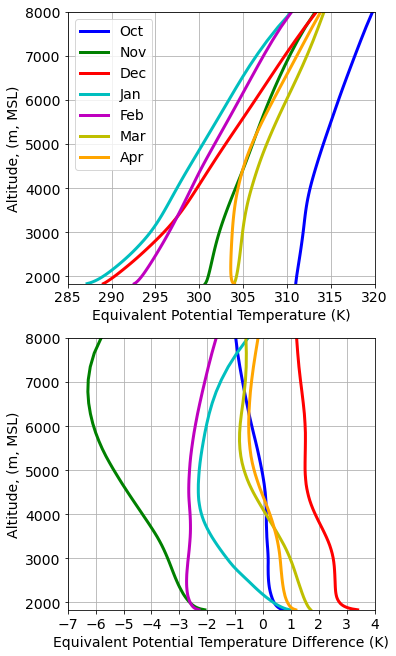

In [31]:
fig = plt.figure(figsize = [15,8])
ax1 = fig.add_subplot(2,1,2)
ax2 = fig.add_subplot(2,1,1)

ax1.plot(np.array(OctEventThetaEs)-np.array(ThetaE_means_oct), z_bins, 'b', linewidth = 3)
ax1.plot(np.array(NovEventThetaEs)-np.array(ThetaE_means_nov), z_bins, 'g', linewidth = 3)
ax1.plot(np.array(DecEventThetaEs)-np.array(ThetaE_means_dec), z_bins, 'r', linewidth = 3)
ax1.plot(np.array(JanEventThetaEs)-np.array(ThetaE_means_jan), z_bins, 'c', linewidth = 3)
ax1.plot(np.array(FebEventThetaEs)-np.array(ThetaE_means_feb), z_bins, 'm', linewidth = 3)
ax1.plot(np.array(MarEventThetaEs)-np.array(ThetaE_means_mar), z_bins, 'y', linewidth = 3)
ax1.plot(np.array(AprEventThetaEs)-np.array(ThetaE_means_apr), z_bins, 'orange', linewidth = 3)
ax1.set_ylim([z_bins[0], 8000])
ax1.set_xlim([-7, 4])
ax1.grid()
ax1.set_xticks([-7, -6, -5, -4,-3,-2,-1, 0,1,2,3,4])
ax1.set_yticks([2000, 3000, 4000, 5000, 6000, 7000, 8000])
# ax1.set_yticklabels([])
ax1.tick_params(axis='both', which='major', labelsize=14)
# ax1.legend(labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'], fontsize = 14)
ax1.set_xlabel("Equivalent Potential Temperature Difference (K)", fontsize = 14)
ax1.set_ylabel('Altitude, (m, MSL)', fontsize = 14,)

ax2.plot(OctEventThetaEs, z_bins, 'b', linewidth = 3)
ax2.plot(NovEventThetaEs, z_bins, 'g', linewidth = 3)
ax2.plot(DecEventThetaEs, z_bins, 'r', linewidth = 3)
ax2.plot(JanEventThetaEs, z_bins, 'c', linewidth = 3)
ax2.plot(FebEventThetaEs, z_bins, 'm', linewidth = 3)
ax2.plot(MarEventThetaEs, z_bins, 'y', linewidth = 3)
ax2.plot(AprEventThetaEs, z_bins, 'orange', linewidth = 3)
ax2.set_ylim([z_bins[0], 8000])
ax2.set_xlim([285, 320])
ax2.grid()
ax2.set_xticks(np.arange(285,325,5).tolist())
ax2.set_yticks([2000, 3000, 4000, 5000, 6000, 7000, 8000])
ax2.legend(labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'], fontsize = 14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel("Equivalent Potential Temperature (K)", fontsize = 14)
ax2.set_ylabel('Altitude, (m, MSL)', fontsize = 14,)

fig.set_size_inches(5.5,11)
plt.show()

## Figure 7 - Integrated Vapor Transport (IVT)

## Figure 8 - Liquid Water Content during Snowfall Events

- Load in and Chunk Data

In [6]:
# Scratch Paths for QSNOW by month
Oct_Path =  r'/glade/scratch/mwarms/temp/QSNOW_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/QSNOW_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/QSNOW_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/QSNOW_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/QSNOW_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/QSNOW_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/QSNOW_snowie_apr.nc'

# Load QSNOWs
QSNOW_snowie_oct = xr.open_dataarray(Oct_Path)
QSNOW_snowie_nov = xr.open_dataarray(Nov_Path)
QSNOW_snowie_dec = xr.open_dataarray(Dec_Path)
QSNOW_snowie_jan = xr.open_dataarray(Jan_Path)
QSNOW_snowie_feb = xr.open_dataarray(Feb_Path)
QSNOW_snowie_mar = xr.open_dataarray(Mar_Path)
QSNOW_snowie_apr = xr.open_dataarray(Apr_Path)

In [7]:
QSNOW_snowie_oct_chunked = QSNOW_snowie_oct.chunk({'Time':24, "bottom_top":1})
QSNOW_snowie_nov_chunked = QSNOW_snowie_nov.chunk({'Time':24, "bottom_top":1})
QSNOW_snowie_dec_chunked = QSNOW_snowie_dec.chunk({'Time':24, "bottom_top":1})
QSNOW_snowie_jan_chunked = QSNOW_snowie_jan.chunk({'Time':24, "bottom_top":1})
QSNOW_snowie_feb_chunked = QSNOW_snowie_feb.chunk({'Time':24, "bottom_top":1})
QSNOW_snowie_mar_chunked = QSNOW_snowie_mar.chunk({'Time':24, "bottom_top":1})
QSNOW_snowie_apr_chunked = QSNOW_snowie_apr.chunk({'Time':24, "bottom_top":1})

In [8]:
# Scratch Paths for QCLOUD by month
Oct_Path =  r'/glade/scratch/mwarms/temp/QCLOUD_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/QCLOUD_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/QCLOUD_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/QCLOUD_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/QCLOUD_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/QCLOUD_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/QCLOUD_snowie_apr.nc'

# Load QCLOUDs
QCLOUD_snowie_oct = xr.open_dataarray(Oct_Path)
QCLOUD_snowie_nov = xr.open_dataarray(Nov_Path)
QCLOUD_snowie_dec = xr.open_dataarray(Dec_Path)
QCLOUD_snowie_jan = xr.open_dataarray(Jan_Path)
QCLOUD_snowie_feb = xr.open_dataarray(Feb_Path)
QCLOUD_snowie_mar = xr.open_dataarray(Mar_Path)
QCLOUD_snowie_apr = xr.open_dataarray(Apr_Path)

In [9]:
QCLOUD_snowie_oct_chunked = QCLOUD_snowie_oct.chunk({'Time':24, "bottom_top":1})
QCLOUD_snowie_nov_chunked = QCLOUD_snowie_nov.chunk({'Time':24, "bottom_top":1})
QCLOUD_snowie_dec_chunked = QCLOUD_snowie_dec.chunk({'Time':24, "bottom_top":1})
QCLOUD_snowie_jan_chunked = QCLOUD_snowie_jan.chunk({'Time':24, "bottom_top":1})
QCLOUD_snowie_feb_chunked = QCLOUD_snowie_feb.chunk({'Time':24, "bottom_top":1})
QCLOUD_snowie_mar_chunked = QCLOUD_snowie_mar.chunk({'Time':24, "bottom_top":1})
QCLOUD_snowie_apr_chunked = QCLOUD_snowie_apr.chunk({'Time':24, "bottom_top":1})

In [10]:
# Scratch Paths for QICE by month
Oct_Path =  r'/glade/scratch/mwarms/temp/QICE_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/QICE_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/QICE_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/QICE_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/QICE_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/QICE_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/QICE_snowie_apr.nc'

# Load QICEs
QICE_snowie_oct = xr.open_dataarray(Oct_Path)
QICE_snowie_nov = xr.open_dataarray(Nov_Path)
QICE_snowie_dec = xr.open_dataarray(Dec_Path)
QICE_snowie_jan = xr.open_dataarray(Jan_Path)
QICE_snowie_feb = xr.open_dataarray(Feb_Path)
QICE_snowie_mar = xr.open_dataarray(Mar_Path)
QICE_snowie_apr = xr.open_dataarray(Apr_Path)

In [12]:
QICE_snowie_oct_chunked = QICE_snowie_oct.chunk({'Time':24, "bottom_top":1})
QICE_snowie_nov_chunked = QICE_snowie_nov.chunk({'Time':24, "bottom_top":1})
QICE_snowie_dec_chunked = QICE_snowie_dec.chunk({'Time':24, "bottom_top":1})
QICE_snowie_jan_chunked = QICE_snowie_jan.chunk({'Time':24, "bottom_top":1})
QICE_snowie_feb_chunked = QICE_snowie_feb.chunk({'Time':24, "bottom_top":1})
QICE_snowie_mar_chunked = QICE_snowie_mar.chunk({'Time':24, "bottom_top":1})
QICE_snowie_apr_chunked = QICE_snowie_apr.chunk({'Time':24, "bottom_top":1})

In [11]:
# Scratch Paths for QGRAUP by month
Oct_Path =  r'/glade/scratch/mwarms/temp/QGRAUP_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/QGRAUP_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/QGRAUP_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/QGRAUP_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/QGRAUP_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/QGRAUP_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/QGRAUP_snowie_apr.nc'

# Load QGRAUPs
QGRAUP_snowie_oct = xr.open_dataarray(Oct_Path)
QGRAUP_snowie_nov = xr.open_dataarray(Nov_Path)
QGRAUP_snowie_dec = xr.open_dataarray(Dec_Path)
QGRAUP_snowie_jan = xr.open_dataarray(Jan_Path)
QGRAUP_snowie_feb = xr.open_dataarray(Feb_Path)
QGRAUP_snowie_mar = xr.open_dataarray(Mar_Path)
QGRAUP_snowie_apr = xr.open_dataarray(Apr_Path)

In [13]:
QGRAUP_snowie_oct_chunked = QGRAUP_snowie_oct.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_nov_chunked = QGRAUP_snowie_nov.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_dec_chunked = QGRAUP_snowie_dec.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_jan_chunked = QGRAUP_snowie_jan.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_feb_chunked = QGRAUP_snowie_feb.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_mar_chunked = QGRAUP_snowie_mar.chunk({'Time':24, "bottom_top":1})
QGRAUP_snowie_apr_chunked = QGRAUP_snowie_apr.chunk({'Time':24, "bottom_top":1})

In [14]:
# Scratch Paths for QRAIN by month
Oct_Path =  r'/glade/scratch/mwarms/temp/QRAIN_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/QRAIN_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/QRAIN_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/QRAIN_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/QRAIN_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/QRAIN_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/QRAIN_snowie_apr.nc'

# Load QRAINs
QRAIN_snowie_oct = xr.open_dataarray(Oct_Path)
QRAIN_snowie_nov = xr.open_dataarray(Nov_Path)
QRAIN_snowie_dec = xr.open_dataarray(Dec_Path)
QRAIN_snowie_jan = xr.open_dataarray(Jan_Path)
QRAIN_snowie_feb = xr.open_dataarray(Feb_Path)
QRAIN_snowie_mar = xr.open_dataarray(Mar_Path)
QRAIN_snowie_apr = xr.open_dataarray(Apr_Path)

In [15]:
QRAIN_snowie_oct_chunked = QRAIN_snowie_oct.chunk({'Time':24, "bottom_top":1})
QRAIN_snowie_nov_chunked = QRAIN_snowie_nov.chunk({'Time':24, "bottom_top":1})
QRAIN_snowie_dec_chunked = QRAIN_snowie_dec.chunk({'Time':24, "bottom_top":1})
QRAIN_snowie_jan_chunked = QRAIN_snowie_jan.chunk({'Time':24, "bottom_top":1})
QRAIN_snowie_feb_chunked = QRAIN_snowie_feb.chunk({'Time':24, "bottom_top":1})
QRAIN_snowie_mar_chunked = QRAIN_snowie_mar.chunk({'Time':24, "bottom_top":1})
QRAIN_snowie_apr_chunked = QRAIN_snowie_apr.chunk({'Time':24, "bottom_top":1})

In [16]:
# Scratch Paths for z by month
Oct_Path =  r'/glade/scratch/mwarms/temp/z_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/z_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/z_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/z_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/z_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/z_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/z_snowie_apr.nc'

# Load zs
z_snowie_oct = xr.open_dataarray(Oct_Path)
z_snowie_nov = xr.open_dataarray(Nov_Path)
z_snowie_dec = xr.open_dataarray(Dec_Path)
z_snowie_jan = xr.open_dataarray(Jan_Path)
z_snowie_feb = xr.open_dataarray(Feb_Path)
z_snowie_mar = xr.open_dataarray(Mar_Path)
z_snowie_apr = xr.open_dataarray(Apr_Path)

In [17]:
z_snowie_oct_chunked = z_snowie_oct.chunk({'Time':24, "bottom_top":1})
z_snowie_nov_chunked = z_snowie_nov.chunk({'Time':24, "bottom_top":1})
z_snowie_dec_chunked = z_snowie_dec.chunk({'Time':24, "bottom_top":1})
z_snowie_jan_chunked = z_snowie_jan.chunk({'Time':24, "bottom_top":1})
z_snowie_feb_chunked = z_snowie_feb.chunk({'Time':24, "bottom_top":1})
z_snowie_mar_chunked = z_snowie_mar.chunk({'Time':24, "bottom_top":1})
z_snowie_apr_chunked = z_snowie_apr.chunk({'Time':24, "bottom_top":1})

In [18]:
# Scratch Paths for Temps by month
Oct_Path =  r'/glade/scratch/mwarms/temp/temp_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/temp_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/temp_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/temp_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/temp_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/temp_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/temp_snowie_apr.nc'

# Load Temps
temp_snowie_oct = xr.open_dataarray(Oct_Path)
temp_snowie_nov = xr.open_dataarray(Nov_Path)
temp_snowie_dec = xr.open_dataarray(Dec_Path)
temp_snowie_jan = xr.open_dataarray(Jan_Path)
temp_snowie_feb = xr.open_dataarray(Feb_Path)
temp_snowie_mar = xr.open_dataarray(Mar_Path)
temp_snowie_apr = xr.open_dataarray(Apr_Path)

In [19]:
temp_snowie_oct_chunked = temp_snowie_oct.chunk({'Time':24, "bottom_top":1})
temp_snowie_nov_chunked = temp_snowie_nov.chunk({'Time':24, "bottom_top":1})
temp_snowie_dec_chunked = temp_snowie_dec.chunk({'Time':24, "bottom_top":1})
temp_snowie_jan_chunked = temp_snowie_jan.chunk({'Time':24, "bottom_top":1})
temp_snowie_feb_chunked = temp_snowie_feb.chunk({'Time':24, "bottom_top":1})
temp_snowie_mar_chunked = temp_snowie_mar.chunk({'Time':24, "bottom_top":1})
temp_snowie_apr_chunked = temp_snowie_apr.chunk({'Time':24, "bottom_top":1})

In [20]:
# Scratch Paths for pressure by month
Oct_Path =  r'/glade/scratch/mwarms/temp/p_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/p_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/p_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/p_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/p_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/p_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/p_snowie_apr.nc'

# Load Temps
p_snowie_oct = xr.open_dataarray(Oct_Path)
p_snowie_nov = xr.open_dataarray(Nov_Path)
p_snowie_dec = xr.open_dataarray(Dec_Path)
p_snowie_jan = xr.open_dataarray(Jan_Path)
p_snowie_feb = xr.open_dataarray(Feb_Path)
p_snowie_mar = xr.open_dataarray(Mar_Path)
p_snowie_apr = xr.open_dataarray(Apr_Path)

In [21]:
p_snowie_oct_chunked = p_snowie_oct.chunk({'Time':24, "bottom_top":1})
p_snowie_nov_chunked = p_snowie_nov.chunk({'Time':24, "bottom_top":1})
p_snowie_dec_chunked = p_snowie_dec.chunk({'Time':24, "bottom_top":1})
p_snowie_jan_chunked = p_snowie_jan.chunk({'Time':24, "bottom_top":1})
p_snowie_feb_chunked = p_snowie_feb.chunk({'Time':24, "bottom_top":1})
p_snowie_mar_chunked = p_snowie_mar.chunk({'Time':24, "bottom_top":1})
p_snowie_apr_chunked = p_snowie_apr.chunk({'Time':24, "bottom_top":1})

In [22]:
# Scratch Paths for Virtual Temps by month
Oct_Path =  r'/glade/scratch/mwarms/temp/tv_snowie_oct.nc'
Nov_Path =  r'/glade/scratch/mwarms/temp/tv_snowie_nov.nc'
Dec_Path =  r'/glade/scratch/mwarms/temp/tv_snowie_dec.nc'
Jan_Path =  r'/glade/scratch/mwarms/temp/tv_snowie_jan.nc'
Feb_Path =  r'/glade/scratch/mwarms/temp/tv_snowie_feb.nc'
Mar_Path =  r'/glade/scratch/mwarms/temp/tv_snowie_mar.nc'
Apr_Path =  r'/glade/scratch/mwarms/temp/tv_snowie_apr.nc'

# Load Temps
tv_snowie_oct = xr.open_dataarray(Oct_Path)
tv_snowie_nov = xr.open_dataarray(Nov_Path)
tv_snowie_dec = xr.open_dataarray(Dec_Path)
tv_snowie_jan = xr.open_dataarray(Jan_Path)
tv_snowie_feb = xr.open_dataarray(Feb_Path)
tv_snowie_mar = xr.open_dataarray(Mar_Path)
tv_snowie_apr = xr.open_dataarray(Apr_Path)

In [23]:
tv_snowie_oct_chunked = tv_snowie_oct.chunk({'Time':24, "bottom_top":1})
tv_snowie_nov_chunked = tv_snowie_nov.chunk({'Time':24, "bottom_top":1})
tv_snowie_dec_chunked = tv_snowie_dec.chunk({'Time':24, "bottom_top":1})
tv_snowie_jan_chunked = tv_snowie_jan.chunk({'Time':24, "bottom_top":1})
tv_snowie_feb_chunked = tv_snowie_feb.chunk({'Time':24, "bottom_top":1})
tv_snowie_mar_chunked = tv_snowie_mar.chunk({'Time':24, "bottom_top":1})
tv_snowie_apr_chunked = tv_snowie_apr.chunk({'Time':24, "bottom_top":1})

In [73]:
z_bins = np.genfromtxt(Saved_Data_Path + 'z_bins.csv', delimiter = ",")
z_bins_below_zero = np.genfromtxt(Saved_Data_Path + 'z_bins_below_zero.csv', delimiter = ",")
MonthlyLastTimestep = [0, 744, 1463, 2207, 2951, 3623, 4367, 5087]
Months = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr"]
EventsPerMonth = [17, 11, 11, 12, 9, 12, 15]
EventCountsPerMonth = [17, 28, 39, 51, 60, 72, 87]

with open(Saved_Data_Path + 'EventLengths.csv') as f:
    reader = csv.reader(f)
    EventLengths = list(reader)
EventLengths = EventLengths[0]
EventLengths = [int(i) for i in EventLengths]

with open(Saved_Data_Path + 'EventTimesStart.csv') as f:
    reader = csv.reader(f)
    EventTimesStart = list(reader)
EventTimesStart = EventTimesStart[0]
EventTimesStart = [int(i) for i in EventTimesStart]

with open(Saved_Data_Path + 'EventTimesEnd.csv') as f:
    reader = csv.reader(f)
    EventTimesEnd = list(reader)
EventTimesEnd = EventTimesEnd[0]
EventTimesEnd = [int(i) for i in EventTimesEnd]

with open(Saved_Data_Path + 'SnowfallEventNumbered.csv') as f:
    reader = csv.reader(f)
    SnowfallEventNumbered = list(reader)
SnowfallEventNumbered = SnowfallEventNumbered[0]
SnowfallEventNumbered = [int(float(i)) for i in SnowfallEventNumbered]

with open(Saved_Data_Path + 'MonthlyEventIndices.csv') as f:
    reader = csv.reader(f)
    MonthlyEventIndices = list(reader)
MonthlyEventIndices = MonthlyEventIndices[0]
MonthlyEventIndices = [int(i) for i in MonthlyEventIndices]

with open(Saved_Data_Path + 'EventPrecip.csv') as f:
    reader = csv.reader(f)
    EventPrecip = list(reader)
EventPrecip = EventPrecip[0]
EventPrecip = [float(i) for i in EventPrecip]

- Averaging Microphysics Variables for each Event along 'z' levels

In [25]:
QRAIN_snowie_chunked = xr.concat([QRAIN_snowie_oct_chunked, QRAIN_snowie_nov_chunked, QRAIN_snowie_dec_chunked, QRAIN_snowie_jan_chunked, 
                                  QRAIN_snowie_feb_chunked, QRAIN_snowie_mar_chunked, QRAIN_snowie_apr_chunked], dim = 'Time')

QSNOW_snowie_chunked = xr.concat([QSNOW_snowie_oct_chunked, QSNOW_snowie_nov_chunked, QSNOW_snowie_dec_chunked, QSNOW_snowie_jan_chunked, 
                                  QSNOW_snowie_feb_chunked, QSNOW_snowie_mar_chunked, QSNOW_snowie_apr_chunked], dim = 'Time')

QICE_snowie_chunked = xr.concat([QICE_snowie_oct_chunked, QICE_snowie_nov_chunked, QICE_snowie_dec_chunked, QICE_snowie_jan_chunked, 
                                  QICE_snowie_feb_chunked, QICE_snowie_mar_chunked, QICE_snowie_apr_chunked], dim = 'Time')

QGRAUP_snowie_chunked = xr.concat([QGRAUP_snowie_oct_chunked, QGRAUP_snowie_nov_chunked, QGRAUP_snowie_dec_chunked, QGRAUP_snowie_jan_chunked, 
                                  QGRAUP_snowie_feb_chunked, QGRAUP_snowie_mar_chunked, QGRAUP_snowie_apr_chunked], dim = 'Time')

QCLOUD_snowie_chunked = xr.concat([QCLOUD_snowie_oct_chunked, QCLOUD_snowie_nov_chunked, QCLOUD_snowie_dec_chunked, QCLOUD_snowie_jan_chunked, 
                                  QCLOUD_snowie_feb_chunked, QCLOUD_snowie_mar_chunked, QCLOUD_snowie_apr_chunked], dim = 'Time')

tv_snowie_chunked = xr.concat([tv_snowie_oct_chunked, tv_snowie_nov_chunked, tv_snowie_dec_chunked, tv_snowie_jan_chunked, 
                                  tv_snowie_feb_chunked, tv_snowie_mar_chunked, tv_snowie_apr_chunked], dim = 'Time')

p_snowie_chunked = xr.concat([p_snowie_oct_chunked, p_snowie_nov_chunked, p_snowie_dec_chunked, p_snowie_jan_chunked, 
                                  p_snowie_feb_chunked, p_snowie_mar_chunked, p_snowie_apr_chunked], dim = 'Time')

z_snowie_chunked = xr.concat([z_snowie_oct_chunked, z_snowie_nov_chunked, z_snowie_dec_chunked, z_snowie_jan_chunked, 
                                  z_snowie_feb_chunked, z_snowie_mar_chunked, z_snowie_apr_chunked], dim = 'Time')

- Old Method

In [24]:
QRAIN_Events_Levels = np.zeros([sum(EventsPerMonth),80])
QSNOW_Events_Levels = np.zeros([sum(EventsPerMonth),80])
QICE_Events_Levels = np.zeros([sum(EventsPerMonth),80])
QGRAUP_Events_Levels = np.zeros([sum(EventsPerMonth),80])
QCLOUD_Events_Levels = np.zeros([sum(EventsPerMonth),80])

for i in range(0,80):
    for j in range(0,sum(EventsPerMonth)):
        QRAIN_Events_Levels[j,i] = QRAIN_snowie_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:].mean().compute()
        QSNOW_Events_Levels[j,i] = QSNOW_snowie_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:].mean().compute()
        QICE_Events_Levels[j,i] = QICE_snowie_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:].mean().compute()
        QGRAUP_Events_Levels[j,i] = QGRAUP_snowie_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:].mean().compute()
        QCLOUD_Events_Levels[j,i] = QGRAUP_snowie_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:].mean().compute()

In [20]:
temp_snowie_chunked = xr.concat([temp_snowie_oct_chunked, temp_snowie_nov_chunked, temp_snowie_dec_chunked, temp_snowie_jan_chunked, 
                                  temp_snowie_feb_chunked, temp_snowie_mar_chunked, temp_snowie_apr_chunked], dim = 'Time')

Atm_Temp_Levels = np.zeros([sum(EventsPerMonth),80])

for i in range(0,80):
    for j in range(0,sum(EventsPerMonth)):
        Atm_Temp_Levels[j,i] = temp_snowie_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:].mean().compute()
        
Atm_Temp_BelowZero = np.zeros([sum(EventsPerMonth),80])

for i in range(0,80):
    for j in range(0,sum(EventsPerMonth)):
            if temp_snowie_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:].mean().compute() < 273.15:
                Atm_Temp_BelowZero[j,i] = 0
            else:
                Atm_Temp_BelowZero[j,i] = 1
                
z_bins_index_Temp_Below_Zero = []

z_bins_below_zero = np.zeros(87)

for j in range(0,sum(EventsPerMonth)):
    for i in range(0,80):
        if Atm_Temp_BelowZero[j,i] == 0:
            z_bins_index_Temp_Below_Zero.append(i)
            break

for k in range(0,sum(EventsPerMonth)):
    z_bins_below_zero[k] = z_bins[z_bins_index_Temp_Below_Zero[k]] 

In [34]:
with open(Saved_Data_Path + 'z_bins_below_zero.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(z_bins_below_zero)

In [21]:
np.savetxt(Saved_Data_Path + 'Atm_Temp_BelowZero.csv', Atm_Temp_BelowZero, delimiter=",")

- New Method (only average where clouds exist)

In [62]:
QCLOUD_new_chunked = QCLOUD_snowie_chunked.where((QCLOUD_snowie_chunked + QRAIN_snowie_chunked)*1000 > 0.001)
QRAIN_new_chunked = QRAIN_snowie_chunked.where((QCLOUD_snowie_chunked + QRAIN_snowie_chunked)*1000 > 0.001)

In [24]:
QICE_new_chunked = QICE_snowie_chunked.where((QICE_snowie_chunked + QSNOW_snowie_chunked + QGRAUP_snowie_chunked)*1000 > 0.001)
QGRAUP_new_chunked = QGRAUP_snowie_chunked.where((QICE_snowie_chunked + QSNOW_snowie_chunked + QGRAUP_snowie_chunked)*1000 > 0.001)
QSNOW_new_chunked = QSNOW_snowie_chunked.where((QICE_snowie_chunked + QSNOW_snowie_chunked + QGRAUP_snowie_chunked)*1000 > 0.001)

In [27]:
QRAIN_Events_Levels_new = np.zeros([sum(EventsPerMonth),80])
QSNOW_Events_Levels_new = np.zeros([sum(EventsPerMonth),80])
QICE_Events_Levels_new = np.zeros([sum(EventsPerMonth),80])
QGRAUP_Events_Levels_new = np.zeros([sum(EventsPerMonth),80])
QCLOUD_Events_Levels_new = np.zeros([sum(EventsPerMonth),80])

for i in range(0,80):
    for j in range(0,sum(EventsPerMonth)):
        QRAIN_Events_Levels_new[j,i] = QRAIN_new_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:].mean().compute()
        QSNOW_Events_Levels_new[j,i] = QSNOW_new_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:].mean().compute()
        QICE_Events_Levels_new[j,i] = QICE_new_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:].mean().compute()
        QGRAUP_Events_Levels_new[j,i] = QGRAUP_new_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:].mean().compute()
        QCLOUD_Events_Levels_new[j,i] = QCLOUD_new_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:].mean().compute()

In [35]:
np.savetxt(Saved_Data_Path + 'QRAIN_Events_Levels.csv', QRAIN_Events_Levels_new, delimiter=",")
np.savetxt(Saved_Data_Path + 'QSNOW_Events_Levels.csv', QSNOW_Events_Levels_new, delimiter=",")
np.savetxt(Saved_Data_Path + 'QICE_Events_Levels.csv', QICE_Events_Levels_new, delimiter=",")
np.savetxt(Saved_Data_Path + 'QGRAUP_Events_Levels.csv', QGRAUP_Events_Levels_new, delimiter=",")
np.savetxt(Saved_Data_Path + 'QCLOUD_Events_Levels.csv', QCLOUD_Events_Levels_new, delimiter=",")

In [74]:
QRAIN_Events_Levels_new = np.genfromtxt(Saved_Data_Path + 'QRAIN_Events_Levels.csv', delimiter = ",")
QSNOW_Events_Levels_new = np.genfromtxt(Saved_Data_Path + 'QSNOW_Events_Levels.csv', delimiter = ",")
QICE_Events_Levels_new = np.genfromtxt(Saved_Data_Path + 'QICE_Events_Levels.csv', delimiter = ",")
QGRAUP_Events_Levels_new = np.genfromtxt(Saved_Data_Path + 'QGRAUP_Events_Levels.csv', delimiter = ",")
QCLOUD_Events_Levels_new = np.genfromtxt(Saved_Data_Path + 'QCLOUD_Events_Levels.csv', delimiter = ",")

- "Juiciness" from Liquid and Ice Water Paths

In [14]:
countNaN = 0
for i in range(0,388):
    for j in range(0,540):
        if (np.isnan(SNOWNC_snowie[0,i,j]) == True):
            countNaN+=1

In [25]:
LWP = np.zeros([5087,388,540])

# loop through time
for t in range (0, 5087):

    # loop through 80 pressure levels (1 minus total = 80 - 1 = 79)
    for z in range(0, 79):
        
        # LWP in g/m^2
        LWP[t] = LWP[t] + 1000 * (100 * (p_snowie_chunked[t,z] - p_snowie_chunked[t,z+1]) *            # pressure level (dp) * 100 [hPa to Pa]
                          ((QCLOUD_snowie_chunked[t,z] + QCLOUD_snowie_chunked[t,z+1] +
                            QRAIN_snowie_chunked[t,z] + QRAIN_snowie_chunked[t,z+1]) / 2) / 9.81)  # average liquid water content within pressure level / g

In [26]:
LWP_da = xr.DataArray(
                  data = LWP,
                  dims = ["time", "south_north", "west_east"],
                  coords = dict(
                      XLONG = (["south_north", "west_east"], p_snowie_chunked[0].XLONG.data),
                      XLAT = (["south_north", "west_east"], p_snowie_chunked[0].XLAT.data),
                      time = p_snowie_chunked.Time.data,
                      reference_time = p_snowie_chunked[0].Time.data
                  ),
                  attrs = dict(
                      description = "Liquid Water Path",
                      units = "g m-2",
                  ),
                         )

In [27]:
# Save to Scratch
write_xarray_to_netcdf(LWP_da, Scratch_Path + "LWP.nc",
                       mode = 'w', format = 'NETCDF4', group=None,
                       engine=None, encoding=None)

In [28]:
del LWP

In [30]:
LWP2 = np.zeros([5087,388,540])
Rd = 287.053 # dry air constant, J / (kg K)

# loop through time
for t in range (0, 5087):

    # loop through 80 pressure levels (1 minus total = 80 - 1 = 79)
    for z in range(0, 79):
        rho_m2 = 100 * ((p_snowie_chunked[t,z] / (Rd * tv_snowie_chunked[t,z]) + p_snowie_chunked[t,z+1] / (Rd * tv_snowie_chunked[t,z+1])) / 2)   # average moist air density
        dz = z_snowie_chunked[t,z+1] - z_snowie_chunked[t,z]  # dz
        r_L = ((QCLOUD_snowie_chunked[t,z] + QCLOUD_snowie_chunked[t,z+1] +
                            QRAIN_snowie_chunked[t,z] + QRAIN_snowie_chunked[t,z+1]) / 2)  # average liquid water mixing ratio

        # LWP in g/m^2
        LWP2[t] = LWP2[t] + 1000 * (rho_m2 * dz * r_L).compute()

In [31]:
LWP_da2 = xr.DataArray(
                  data = LWP2,
                  dims = ["time", "south_north", "west_east"],
                  coords = dict(
                      XLONG = (["south_north", "west_east"], p_snowie_chunked[0].XLONG.data),
                      XLAT = (["south_north", "west_east"], p_snowie_chunked[0].XLAT.data),
                      time = p_snowie_chunked.Time.data,
                      reference_time = p_snowie_chunked[0].Time.data
                  ),
                  attrs = dict(
                      description = "Liquid Water Path",
                      units = "g m-2",
                  ),
                         )

In [32]:
del LWP2

In [33]:
# Save to Scratch
write_xarray_to_netcdf(LWP_da2, Scratch_Path + "LWP2.nc",
                       mode = 'w', format = 'NETCDF4', group=None,
                       engine=None, encoding=None)

In [26]:
IWP = np.zeros([5087,388,540])
Rd = 287.053 # dry air constant, J / (kg K)

# loop through time
for t in range (0, 5087):

    # loop through 80 pressure levels (1 minus total = 80 - 1 = 79)
    for z in range(0, 79):
        rho_m2 = 100 * ((p_snowie_chunked[t,z] / (Rd * tv_snowie_chunked[t,z]) + p_snowie_chunked[t,z+1] / (Rd * tv_snowie_chunked[t,z+1])) / 2)   # average moist air density
        dz = z_snowie_chunked[t,z+1] - z_snowie_chunked[t,z]  # dz
        r_L = ((QGRAUP_snowie_chunked[t,z+1] + QSNOW_snowie_chunked[t,z+1] + QICE_snowie_chunked[t,z+1] +
                            QGRAUP_snowie_chunked[t,z] + QSNOW_snowie_chunked[t,z] + QICE_snowie_chunked[t,z]) / 2)  # average ice water mixing ratio

        # LWP in g/m^2
        IWP[t] = IWP[t] + 1000 * (rho_m2 * dz * r_L).compute()

In [27]:
IWP_da = xr.DataArray(
                  data = IWP,
                  dims = ["time", "south_north", "west_east"],
                  coords = dict(
                      XLONG = (["south_north", "west_east"], p_snowie_chunked[0].XLONG.data),
                      XLAT = (["south_north", "west_east"], p_snowie_chunked[0].XLAT.data),
                      time = p_snowie_chunked.Time.data,
                      reference_time = p_snowie_chunked[0].Time.data
                  ),
                  attrs = dict(
                      description = "Ice Water Path",
                      units = "g m-2",
                  ),
                         )

In [29]:
# Save to Scratch
write_xarray_to_netcdf(IWP_da, Scratch_Path + "IWP.nc",
                       mode = 'w', format = 'NETCDF4', group=None,
                       engine=None, encoding=None)

In [36]:
# Scratch Paths for LWP and IWP
IWP_Path = r'/glade/scratch/mwarms/temp/IWP.nc'
LWP_Path =  r'/glade/scratch/mwarms/temp/LWP.nc'
LWP2_Path =  r'/glade/scratch/mwarms/temp/LWP2.nc'

# Load
IWP = xr.open_dataarray(IWP_Path)
LWP = xr.open_dataarray(LWP_Path)
LWP2 = xr.open_dataarray(LWP2_Path)

In [42]:
del test

In [30]:
# Scratch Paths for IVT by month
Path =  r'/glade/scratch/mwarms/temp/LWP.nc'

# Load LWP
LWP = xr.open_dataarray(Path)

LWP_chunked = LWP.chunk({'time':24})

In [5]:
LWP_chunked = LWP.chunk({'time':24})
LWP2_chunked = LWP2.chunk({'time':24})

In [6]:
LWP_new_chunked = LWP_chunked.where(LWP_chunked > 0.02)
LWP2_new_chunked = LWP2_chunked.where(LWP2_chunked > 0.02)

In [7]:
del LWP, LWP2, LWP_chunked, LWP2_chunked

In [79]:
PercentGridCellsCloudyPerEvent = np.zeros(len(EventPrecip))
PercentGridCellsCloudyPerEvent_new = np.zeros(len(EventPrecip))
numNansPerEvent = np.zeros(len(EventPrecip))

PercentGridCellsCloudyPerEvent2 = np.zeros(len(EventPrecip))
PercentGridCellsCloudyPerEvent2_new = np.zeros(len(EventPrecip))

numNansPerEvent2 = np.zeros(len(EventPrecip))

countNaN = 14508
TotalGridCells = 388*540
TotalUsedGridCells = TotalGridCells - countNaN

for i in range(0,87):
    
    numNansPerEvent[i] = np.sum(np.isnan(LWP_new_chunked[EventTimesStart[i]:EventTimesEnd[i]]).compute())
    numNansPerEvent2[i] = np.sum(np.isnan(LWP2_new_chunked[EventTimesStart[i]:EventTimesEnd[i]]).compute())
    
    PercentGridCellsCloudyPerEvent[i] = ((TotalGridCells * EventLengths[i] - numNansPerEvent[i]) / (TotalUsedGridCells * EventLengths[i])) * 100
    PercentGridCellsCloudyPerEvent2[i] = ((TotalGridCells * EventLengths[i] - numNansPerEvent2[i]) / (TotalUsedGridCells * EventLengths[i])) * 100

In [37]:
# Scratch Paths for IW{ by month
Path =  r'/glade/scratch/mwarms/temp/IWP.nc'

# Load LWP
IWP = xr.open_dataarray(Path)

IWP_chunked = LWP.chunk({'time':24})

In [33]:
IWP_new_chunked = IWP_chunked.where(IWP_chunked > 0.02)

In [34]:
PercentGridCellsIcyPerEvent = np.zeros(len(EventPrecip))
numNansPerEvent = np.zeros(len(EventPrecip))

countNaN = 14508
TotalGridCells = 388*540
TotalUsedGridCells = TotalGridCells - countNaN

for i in range(0,87):
    
    numNansPerEvent[i] = np.sum(np.isnan(IWP_new_chunked[EventTimesStart[i]:EventTimesEnd[i]]).compute())
    
    PercentGridCellsIcyPerEvent[i] = ((TotalGridCells * EventLengths[i] - numNansPerEvent[i]) / (TotalUsedGridCells * EventLengths[i])) * 100


In [81]:
with open(Saved_Data_Path + 'PercentGridCellsCloudyPerEvent.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(PercentGridCellsCloudyPerEvent2)

In [36]:
with open(Saved_Data_Path + 'PercentGridCellsIcyPerEvent.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(PercentGridCellsIcyPerEvent)

In [38]:
with open(Saved_Data_Path + 'PercentGridCellsCloudyPerEvent.csv') as f:
    reader = csv.reader(f)
    PercentGridCellsCloudyPerEvent = list(reader)
PercentGridCellsCloudyPerEvent = PercentGridCellsCloudyPerEvent[0]
PercentGridCellsCloudyPerEvent = [float(i) for i in PercentGridCellsCloudyPerEvent]

In [39]:
with open(Saved_Data_Path + 'PercentGridCellsIcyPerEvent.csv') as f:
    reader = csv.reader(f)
    PercentGridCellsIcyPerEvent = list(reader)
PercentGridCellsIcyPerEvent = PercentGridCellsIcyPerEvent[0]
PercentGridCellsIcyPerEvent = [float(i) for i in PercentGridCellsIcyPerEvent]

In [9]:
Monthly_Avg_PercentCloudy_events = np.zeros(7)  # value in g m-3

Monthly_Avg_PercentCloudy_events[0] = np.mean(PercentGridCellsCloudyPerEvent[0:EventCountsPerMonth[0]])
Monthly_Avg_PercentCloudy_events[1] = np.mean(PercentGridCellsCloudyPerEvent[EventCountsPerMonth[0]:EventCountsPerMonth[1]])
Monthly_Avg_PercentCloudy_events[2] = np.mean(PercentGridCellsCloudyPerEvent[EventCountsPerMonth[1]:EventCountsPerMonth[2]])
Monthly_Avg_PercentCloudy_events[3] = np.mean(PercentGridCellsCloudyPerEvent[EventCountsPerMonth[2]:EventCountsPerMonth[3]])
Monthly_Avg_PercentCloudy_events[4] = np.mean(PercentGridCellsCloudyPerEvent[EventCountsPerMonth[3]:EventCountsPerMonth[4]])
Monthly_Avg_PercentCloudy_events[5] = np.mean(PercentGridCellsCloudyPerEvent[EventCountsPerMonth[4]:EventCountsPerMonth[5]])
Monthly_Avg_PercentCloudy_events[6] = np.mean(PercentGridCellsCloudyPerEvent[EventCountsPerMonth[5]:EventCountsPerMonth[6]])

In [10]:
print("Average Monthly Percent Cloudy during events in...", end = " "),
for i in range(0,len(Monthly_Avg_PercentCloudy_events)):
    print(Months[i], "=", "{:.3f}".format(Monthly_Avg_PercentCloudy_events[i]), "%", end = "; "),

Average Monthly Percent Cloudy during events in... Oct = 56.365 %; Nov = 40.648 %; Dec = 49.551 %; Jan = 48.303 %; Feb = 40.356 %; Mar = 52.152 %; Apr = 41.738 %; 

- Calculate LWC

In [37]:
Rd = 287.053 # dry air constant, J / (kg K)
LWC_Events_Levels = np.zeros([sum(EventsPerMonth),80])
rho_m_Events_Levels = np.zeros([sum(EventsPerMonth),80,388,540])

for i in range(0,80):
    for j in range(0,sum(EventsPerMonth)):
        rho_m_Events_Levels[j,i] = (p_snowie_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:] / (Rd * tv_snowie_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:])).mean().compute() # Ideal Gas Law, moist air density
        rho_m = (p_snowie_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:] / (Rd * tv_snowie_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:]))
        LWC_Events_Levels[j,i] = ((QRAIN_new_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:] + QCLOUD_new_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:]) * rho_m).mean().compute() # Liquid Water Content = (QCLOUD + QRAIN) * rho

In [69]:
np.savetxt(Saved_Data_Path + 'LWC_Events_Levels.csv', LWC_Events_Levels, delimiter=",")
np.savetxt(Saved_Data_Path + 'rho_m_avg.csv', rho_m_avg, delimiter=",")

In [75]:
LWC_Events_Levels = np.genfromtxt(Saved_Data_Path + 'LWC_Events_Levels.csv', delimiter = ",")
rho_m_avg = np.genfromtxt(Saved_Data_Path + 'rho_m_avg.csv', delimiter = ",")

- Calculate IWC

In [67]:
Rd = 287.053 # dry air constant, J / (kg K)
IWC_Events_Levels = np.zeros([sum(EventsPerMonth),80])

for i in range(0,80):
    for j in range(0,sum(EventsPerMonth)):
        rho_m = (p_snowie_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:] / (Rd * tv_snowie_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:]))
        IWC_Events_Levels[j,i] = ((QICE_new_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:] + 
                                   QSNOW_new_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:] + 
                                   QGRAUP_new_chunked[EventTimesStart[j]:EventTimesEnd[j],i,:,:]) * rho_m).mean().compute() # Ice Water Content = (QICE + QSNOW + QGRAUP) * rho

In [68]:
np.savetxt(Saved_Data_Path + 'IWC_Events_Levels.csv', IWC_Events_Levels, delimiter=",")

In [76]:
IWC_Events_Levels = np.genfromtxt(Saved_Data_Path + 'IWC_Events_Levels.csv', delimiter = ",")

- Density Plot

/glade/u/home/mwarms/miniconda3/envs/snowie_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


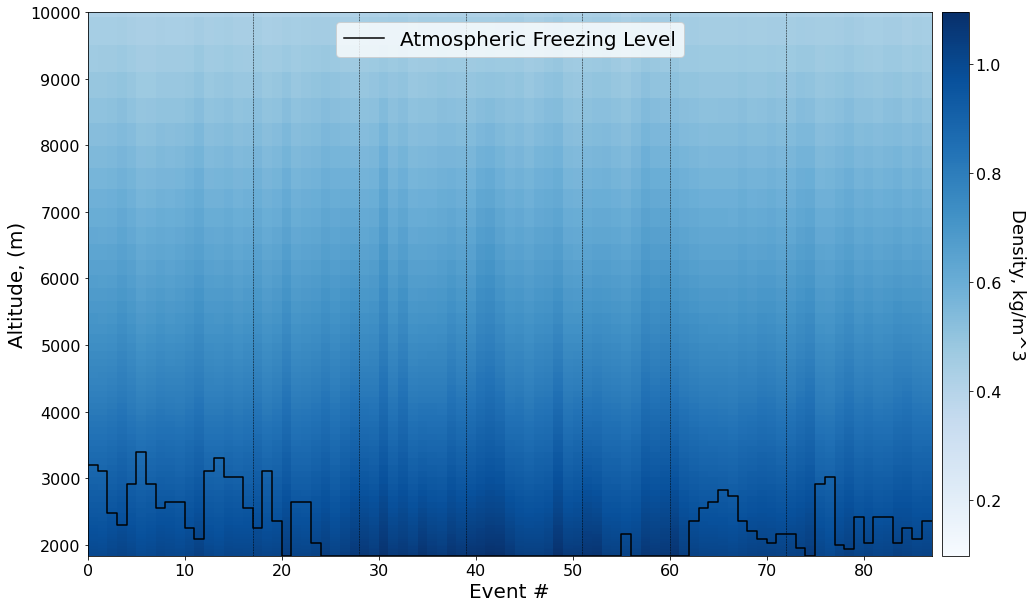

In [28]:
test = np.array(3201.359375)
EventNum = np.arange(0,88,1)
z_bins_below_zero_step_plot = np.append(test, PercentGridCellsCloudyPerEvent)

plt.figure(figsize=[18,10])
plt.pcolormesh(EventNum, z_bins, np.transpose(rho_m_avg)*100, cmap = 'Blues')
plt.step(EventNum, z_bins_below_zero_step_plot, 'k')
plt.legend(labels = ['Atmospheric Freezing Level'], fontsize = 20, loc = 'upper center')
plt.plot([17, 17], [0, 12000], '--k', linewidth = 0.5)
plt.plot([28, 28], [0, 12000], '--k', linewidth = 0.5)
plt.plot([39, 39], [0, 12000], '--k', linewidth = 0.5)
plt.plot([51, 51], [0, 12000], '--k', linewidth = 0.5)
plt.plot([60, 60], [0, 12000], '--k', linewidth = 0.5)
plt.plot([72, 72], [0, 12000], '--k', linewidth = 0.5)
plt.xlabel('Event #', fontsize = 20)
plt.ylabel('Altitude, (m)', fontsize = 20)
# plt.title('Liquid Water Content (QCLOUD + QRAIN) per event', fontsize = 26, weight = 'bold')
cbar = plt.colorbar(pad = 0.01)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(label = 'Density, kg/m^3', size=18, rotation = 270, labelpad = 25)
plt.ylim([z_bins[0], 10000])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

/glade/u/home/mwarms/miniconda3/envs/snowie_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


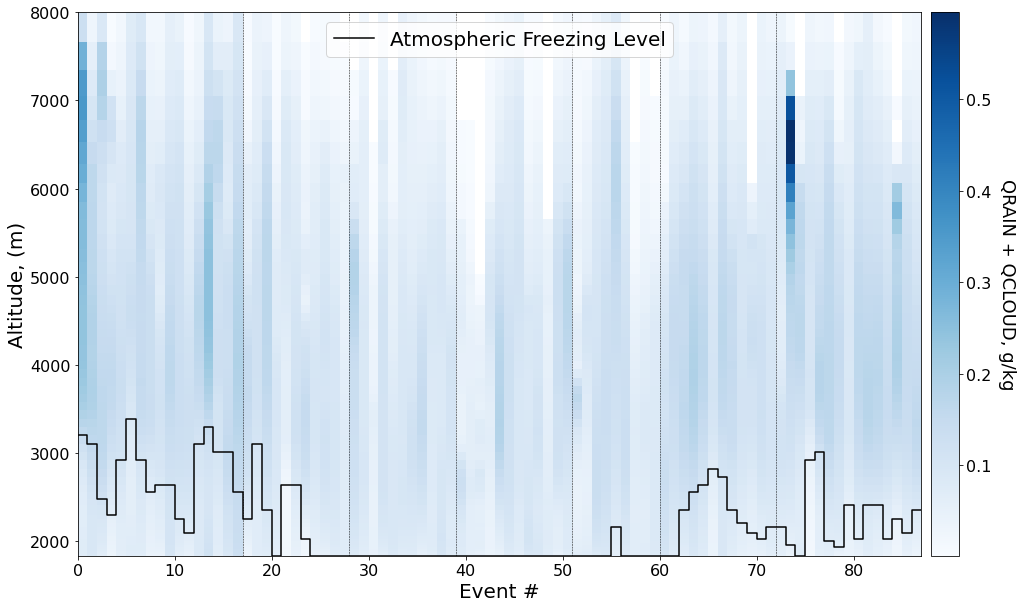

In [42]:
test = np.array(3201.359375)
EventNum = np.arange(0,88,1)
z_bins_below_zero_step_plot = np.append(test, z_bins_below_zero)

plt.figure(figsize=[18,10])
plt.pcolormesh(EventNum, z_bins, np.transpose(QRAIN_Events_Levels_new+QCLOUD_Events_Levels_new)*1000, cmap = 'Blues')
plt.step(EventNum, z_bins_below_zero_step_plot, 'k')
plt.legend(labels = ['Atmospheric Freezing Level'], fontsize = 20, loc = 'upper center')
plt.plot([17, 17], [0, 12000], '--k', linewidth = 0.5)
plt.plot([28, 28], [0, 12000], '--k', linewidth = 0.5)
plt.plot([39, 39], [0, 12000], '--k', linewidth = 0.5)
plt.plot([51, 51], [0, 12000], '--k', linewidth = 0.5)
plt.plot([60, 60], [0, 12000], '--k', linewidth = 0.5)
plt.plot([72, 72], [0, 12000], '--k', linewidth = 0.5)
plt.xlabel('Event #', fontsize = 20)
plt.ylabel('Altitude, (m)', fontsize = 20)
# plt.title('Liquid Water Content (QCLOUD + QRAIN) per event', fontsize = 26, weight = 'bold')
cbar = plt.colorbar(pad = 0.01)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(label = 'QRAIN + QCLOUD, g/kg', size=18, rotation = 270, labelpad = 25)
plt.ylim([z_bins[0], 8000])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

- Liquid Water Content

/glade/u/home/mwarms/miniconda3/envs/snowie_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


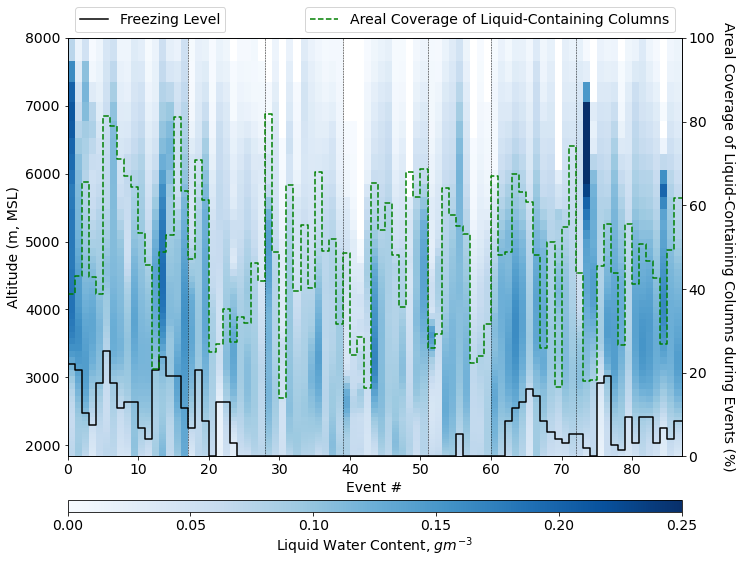

In [77]:
test = np.array(3201.359375)
EventNum = np.arange(0,88,1)
z_bins_below_zero_step_plot = np.append(test, z_bins_below_zero)
juicybins_step_plot = np.append(PercentGridCellsCloudyPerEvent[0],PercentGridCellsCloudyPerEvent)

fig = plt.figure(figsize=[18,15])
fig.set_size_inches(11, 10)
ax = fig.add_subplot(111)
plt.pcolormesh(EventNum, z_bins, np.transpose(LWC_Events_Levels)*1000*100, cmap = 'Blues', vmin = 0, vmax = 0.25)
plt.step(EventNum, z_bins_below_zero_step_plot, 'k')
plt.legend(labels = ['Freezing Level'], fontsize = 14, loc = 'upper left', bbox_to_anchor=(0,1.09))
plt.plot([17, 17], [0, 12000], '--k', linewidth = 0.5)
plt.plot([28, 28], [0, 12000], '--k', linewidth = 0.5)
plt.plot([39, 39], [0, 12000], '--k', linewidth = 0.5)
plt.plot([51, 51], [0, 12000], '--k', linewidth = 0.5)
plt.plot([60, 60], [0, 12000], '--k', linewidth = 0.5)
plt.plot([72, 72], [0, 12000], '--k', linewidth = 0.5)
plt.xlabel('Event #', fontsize = 14)
plt.ylabel('Altitude (m, MSL)', fontsize = 14)
cbar = plt.colorbar(pad = 0.08, orientation = 'horizontal', aspect = 50)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(label = 'Liquid Water Content, $gm^{-3}$', size=14, labelpad =2)

plt.ylim([z_bins[0], 8000])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

ax2 = ax.twinx()
ax2.step(EventNum, juicybins_step_plot, '--g')
ax2.set_ylabel('Areal Coverage of Liquid-Containing Columns during Events (%)', fontsize = 14, rotation = 270, labelpad = 20)
ax2.set_ylim([0,100])
plt.legend(labels = ['Areal Coverage of Liquid-Containing Columns'], fontsize = 14, loc = 'upper right', bbox_to_anchor=(1,1.09))
plt.yticks(fontsize = 14)
plt.show()

In [44]:
EventCountsPerMonth = [17, 28, 39, 51, 60, 72, 87]
Months = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr"]
Diff_bt_atm_levels_below_8km = z_bins[1:60] - z_bins[0:59]
Diff_bt_atm_levels_below_10km = z_bins[1:65] - z_bins[0:64]

In [45]:
Atm_Temp_BelowZero = np.genfromtxt(Saved_Data_Path + 'Atm_Temp_BelowZero.csv', delimiter = ",")

In [105]:
LWC_below_zero_all_levels = np.zeros([87,80])

for j in range(0,sum(EventsPerMonth)):
    for i in range(0,80):
        if Atm_Temp_BelowZero[j,i] == 0:
            LWC_below_zero_all_levels[j,i] = LWC_Events_Levels[j,i]
        else:     
            LWC_below_zero_all_levels[j,i] = 0

In [29]:
Monthly_Avg_LWC_events = np.zeros(7)  # value in g m-3

Monthly_Avg_LWC_events[0] = np.nansum((LWC_Events_Levels[0:EventCountsPerMonth[0],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / sum(Diff_bt_atm_levels_below_8km) / EventsPerMonth[0]
Monthly_Avg_LWC_events[1] = np.nansum((LWC_Events_Levels[EventCountsPerMonth[0]:EventCountsPerMonth[1],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / sum(Diff_bt_atm_levels_below_8km) / EventsPerMonth[1]
Monthly_Avg_LWC_events[2] = np.nansum((LWC_Events_Levels[EventCountsPerMonth[1]:EventCountsPerMonth[2],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / sum(Diff_bt_atm_levels_below_8km) / EventsPerMonth[2]
Monthly_Avg_LWC_events[3] = np.nansum((LWC_Events_Levels[EventCountsPerMonth[2]:EventCountsPerMonth[3],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / sum(Diff_bt_atm_levels_below_8km) / EventsPerMonth[3]
Monthly_Avg_LWC_events[4] = np.nansum((LWC_Events_Levels[EventCountsPerMonth[3]:EventCountsPerMonth[4],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / sum(Diff_bt_atm_levels_below_8km) / EventsPerMonth[4]
Monthly_Avg_LWC_events[5] = np.nansum((LWC_Events_Levels[EventCountsPerMonth[4]:EventCountsPerMonth[5],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / sum(Diff_bt_atm_levels_below_8km) / EventsPerMonth[5]
Monthly_Avg_LWC_events[6] = np.nansum((LWC_Events_Levels[EventCountsPerMonth[5]:EventCountsPerMonth[6],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / sum(Diff_bt_atm_levels_below_8km) / EventsPerMonth[6]

In [30]:
print("Average Monthly LWC during events in...", end = " "),
for i in range(0,len(Monthly_Avg_LWC_events)):
    print(Months[i], "=", "{:.3f}".format(Monthly_Avg_LWC_events[i]), "g m-3", end = "; "),

Average Monthly LWC during events in... Oct = 0.091 g m-3; Nov = 0.060 g m-3; Dec = 0.059 g m-3; Jan = 0.056 g m-3; Feb = 0.059 g m-3; Mar = 0.076 g m-3; Apr = 0.084 g m-3; 

In [97]:
LWC_averages_all_events = np.nansum(LWC_Events_Levels[:,0:59]*100*1000 * Diff_bt_atm_levels_below_8km, axis = 1) / sum(Diff_bt_atm_levels_below_8km)
LWC_averages_all_events[20:60].min(), LWC_averages_all_events[20:60].max()

(0.02444056989576856, 0.09663222825698763)

In [12]:
Monthly_integ_LWC_events = np.zeros(7)

Monthly_integ_LWC_events[0] = np.nansum((LWC_Events_Levels[0:EventCountsPerMonth[0],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[0] / 1000 
Monthly_integ_LWC_events[1] = np.nansum((LWC_Events_Levels[EventCountsPerMonth[0]:EventCountsPerMonth[1],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[1] / 1000
Monthly_integ_LWC_events[2] = np.nansum((LWC_Events_Levels[EventCountsPerMonth[1]:EventCountsPerMonth[2],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[2] / 1000
Monthly_integ_LWC_events[3] = np.nansum((LWC_Events_Levels[EventCountsPerMonth[2]:EventCountsPerMonth[3],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[3] / 1000
Monthly_integ_LWC_events[4] = np.nansum((LWC_Events_Levels[EventCountsPerMonth[3]:EventCountsPerMonth[4],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[4] / 1000
Monthly_integ_LWC_events[5] = np.nansum((LWC_Events_Levels[EventCountsPerMonth[4]:EventCountsPerMonth[5],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[5] / 1000
Monthly_integ_LWC_events[6] = np.nansum((LWC_Events_Levels[EventCountsPerMonth[5]:EventCountsPerMonth[6],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[6] / 1000

In [13]:
print("Average Monthly integerated LWC during events in...", end = " "),
for i in range(0,len(Monthly_integ_LWC_events)):
    print(Months[i], "=", "{:.3f}".format(Monthly_integ_LWC_events[i]), "kg m-2", end = "; "),

Average Monthly integerated LWC during events in... Oct = 0.561 kg m-2; Nov = 0.370 kg m-2; Dec = 0.362 kg m-2; Jan = 0.344 kg m-2; Feb = 0.363 kg m-2; Mar = 0.469 kg m-2; Apr = 0.517 kg m-2; 

In [106]:
integ_SLW_events = np.zeros(87)
integ_IWC_events = np.zeros(87)

for i in range(0,87):
    integ_SLW_events[i] = np.nansum((LWC_below_zero_all_levels[i,0:59]*100*1000 * Diff_bt_atm_levels_below_8km) / 1000)
    integ_IWC_events[i] = np.nansum((IWC_Events_Levels[i,0:64]*100*1000 * Diff_bt_atm_levels_below_10km) / 1000)

In [106]:
pearson_r_SLW = stats.pearsonr(integ_SLW_events, SNOWNC_snowie_Events_new)
pearson_r_SLW

(0.19242311332497392, 0.07416883776409741)

In [105]:
pearson_r_IWC = stats.pearsonr(integ_IWC_events, SNOWNC_snowie_Events_new)
pearson_r_IWC

(0.10981976718252018, 0.3112600418113743)

(0.0, 1.0)

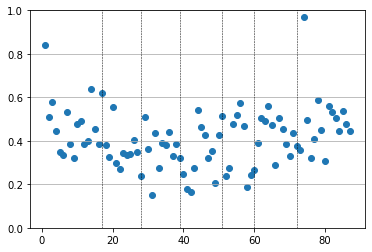

In [30]:
EventNum = np.arange(1,88,1)

plt.scatter(EventNum, integ_SLW_events)
plt.plot([17, 17], [0, 12000], '--k', linewidth = 0.5)
plt.plot([28, 28], [0, 12000], '--k', linewidth = 0.5)
plt.plot([39, 39], [0, 12000], '--k', linewidth = 0.5)
plt.plot([51, 51], [0, 12000], '--k', linewidth = 0.5)
plt.plot([60, 60], [0, 12000], '--k', linewidth = 0.5)
plt.plot([72, 72], [0, 12000], '--k', linewidth = 0.5)
plt.grid(axis = 'y')
plt.ylim([0,1])

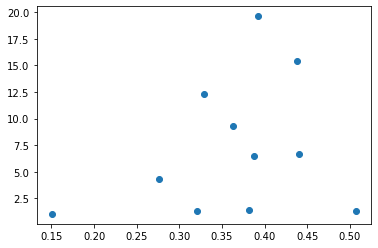

In [43]:
plt.scatter(integ_SLW_events[EventCountsPerMonth[1]:EventCountsPerMonth[2]], SNOWNC_snowie_Events_new[EventCountsPerMonth[1]:EventCountsPerMonth[2]])

- oct

In [57]:
integ_SLW_events[0:EventCountsPerMonth[0]].max(), integ_SLW_events[0:EventCountsPerMonth[0]].mean(), integ_SLW_events[0:EventCountsPerMonth[0]].min()

(0.8418201725200636, 0.4793405043870507, 0.3220152154834649)

- nov

In [50]:
integ_SLW_events[EventCountsPerMonth[0]:EventCountsPerMonth[1]].max(), integ_SLW_events[EventCountsPerMonth[0]:EventCountsPerMonth[1]].mean(), integ_SLW_events[EventCountsPerMonth[0]:EventCountsPerMonth[1]].min()

(0.5548651270066942, 0.3492982615893551, 0.23811532006614125)

In [52]:
integ_SLW_events[EventCountsPerMonth[0]:EventCountsPerMonth[1]]

array([0.37935247, 0.32385981, 0.55486513, 0.30016094, 0.27128273,
       0.34529191, 0.3365064 , 0.34101914, 0.40525373, 0.3465733 ,
       0.23811532])

- dec

In [47]:
integ_SLW_events[EventCountsPerMonth[1]:EventCountsPerMonth[2]].max(), integ_SLW_events[EventCountsPerMonth[1]:EventCountsPerMonth[2]].mean(), integ_SLW_events[EventCountsPerMonth[1]:EventCountsPerMonth[2]].min()

(0.5073859335054546, 0.3621653770294069, 0.15041072796144533)

In [53]:
integ_SLW_events[EventCountsPerMonth[1]:EventCountsPerMonth[2]]

array([0.50738593, 0.36245139, 0.15041073, 0.43785465, 0.27564772,
       0.39218674, 0.38168696, 0.43986114, 0.32851506, 0.38767452,
       0.32014432])

- jan

In [48]:
integ_SLW_events[EventCountsPerMonth[2]:EventCountsPerMonth[3]].max(), integ_SLW_events[EventCountsPerMonth[2]:EventCountsPerMonth[3]].mean(), integ_SLW_events[EventCountsPerMonth[2]:EventCountsPerMonth[3]].min()

(0.543114547345918, 0.344042718997887, 0.1666992426626996)

In [54]:
integ_SLW_events[EventCountsPerMonth[2]:EventCountsPerMonth[3]]

array([0.24873695, 0.17913495, 0.16669924, 0.27621193, 0.54311455,
       0.46504963, 0.42723211, 0.32322963, 0.3514586 , 0.20810261,
       0.42624835, 0.51329407])

- feb

In [49]:
integ_SLW_events[EventCountsPerMonth[3]:EventCountsPerMonth[4]].max(), integ_SLW_events[EventCountsPerMonth[3]:EventCountsPerMonth[4]].mean(), integ_SLW_events[EventCountsPerMonth[3]:EventCountsPerMonth[4]].min()

(0.5723020907197354, 0.3606053118068018, 0.18801675626301745)

In [55]:
integ_SLW_events[EventCountsPerMonth[3]:EventCountsPerMonth[4]]

array([0.23994778, 0.2766202 , 0.47629056, 0.51690951, 0.57230209,
       0.46659116, 0.18801676, 0.24240597, 0.26636377])

- mar

In [51]:
integ_SLW_events[EventCountsPerMonth[4]:EventCountsPerMonth[5]].max(), integ_SLW_events[EventCountsPerMonth[4]:EventCountsPerMonth[5]].mean(), integ_SLW_events[EventCountsPerMonth[4]:EventCountsPerMonth[5]].min()

(0.560058312676899, 0.43292594218897995, 0.286551191232634)

In [56]:
integ_SLW_events[EventCountsPerMonth[4]:EventCountsPerMonth[5]]

array([0.38984704, 0.50320082, 0.49251997, 0.56005831, 0.47405326,
       0.28655119, 0.50669073, 0.454502  , 0.38752677, 0.33069018,
       0.43401909, 0.37545194])

In [49]:
Monthly_integ_SLW_events = np.zeros(7)

Monthly_integ_SLW_events[0] = np.nansum((LWC_below_zero_all_levels[0:EventCountsPerMonth[0],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[0] / 1000 
Monthly_integ_SLW_events[1] = np.nansum((LWC_below_zero_all_levels[EventCountsPerMonth[0]:EventCountsPerMonth[1],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[1] / 1000
Monthly_integ_SLW_events[2] = np.nansum((LWC_below_zero_all_levels[EventCountsPerMonth[1]:EventCountsPerMonth[2],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[2] / 1000
Monthly_integ_SLW_events[3] = np.nansum((LWC_below_zero_all_levels[EventCountsPerMonth[2]:EventCountsPerMonth[3],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[3] / 1000
Monthly_integ_SLW_events[4] = np.nansum((LWC_below_zero_all_levels[EventCountsPerMonth[3]:EventCountsPerMonth[4],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[4] / 1000
Monthly_integ_SLW_events[5] = np.nansum((LWC_below_zero_all_levels[EventCountsPerMonth[4]:EventCountsPerMonth[5],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[5] / 1000
Monthly_integ_SLW_events[6] = np.nansum((LWC_below_zero_all_levels[EventCountsPerMonth[5]:EventCountsPerMonth[6],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[6] / 1000

In [50]:
print("Average Monthly integerated SLW during events in...", end = " "),
for i in range(0,len(Monthly_integ_SLW_events)):
    print(Months[i], "=", "{:.3f}".format(Monthly_integ_SLW_events[i]), "kg m-2", end = "; "),

Average Monthly integerated SLW during events in... Oct = 0.479 kg m-2; Nov = 0.349 kg m-2; Dec = 0.362 kg m-2; Jan = 0.344 kg m-2; Feb = 0.361 kg m-2; Mar = 0.433 kg m-2; Apr = 0.493 kg m-2; 

In [29]:
Monthly_Avg_PercentCloudy_events = np.zeros(7)

Monthly_Avg_PercentCloudy_events[0] = np.nanmean(PercentGridCellsCloudyPerEvent[0:EventCountsPerMonth[0]])
Monthly_Avg_PercentCloudy_events[1] = np.nanmean(PercentGridCellsCloudyPerEvent[EventCountsPerMonth[0]:EventCountsPerMonth[1]])
Monthly_Avg_PercentCloudy_events[2] = np.nanmean(PercentGridCellsCloudyPerEvent[EventCountsPerMonth[1]:EventCountsPerMonth[2]])
Monthly_Avg_PercentCloudy_events[3] = np.nanmean(PercentGridCellsCloudyPerEvent[EventCountsPerMonth[2]:EventCountsPerMonth[3]])
Monthly_Avg_PercentCloudy_events[4] = np.nanmean(PercentGridCellsCloudyPerEvent[EventCountsPerMonth[3]:EventCountsPerMonth[4]])
Monthly_Avg_PercentCloudy_events[5] = np.nanmean(PercentGridCellsCloudyPerEvent[EventCountsPerMonth[4]:EventCountsPerMonth[5]])
Monthly_Avg_PercentCloudy_events[6] = np.nanmean(PercentGridCellsCloudyPerEvent[EventCountsPerMonth[5]:EventCountsPerMonth[6]])

In [30]:
print("Average Monthly Percent Cloudy during events in...", end = " "),
for i in range(0,len(Monthly_Avg_LWC_events)):
    print(Months[i], "=", "{:.3f}".format(Monthly_Avg_PercentCloudy_events[i]), "%", end = "; "),

Average Monthly Percent Cloudy during events in... Oct = 56.365 %; Nov = 40.648 %; Dec = 49.551 %; Jan = 48.303 %; Feb = 40.356 %; Mar = 52.152 %; Apr = 41.738 %; 

## Figure 9 - Snow and Ice Water Content during Snowfall Events

/glade/u/home/mwarms/miniconda3/envs/snowie_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


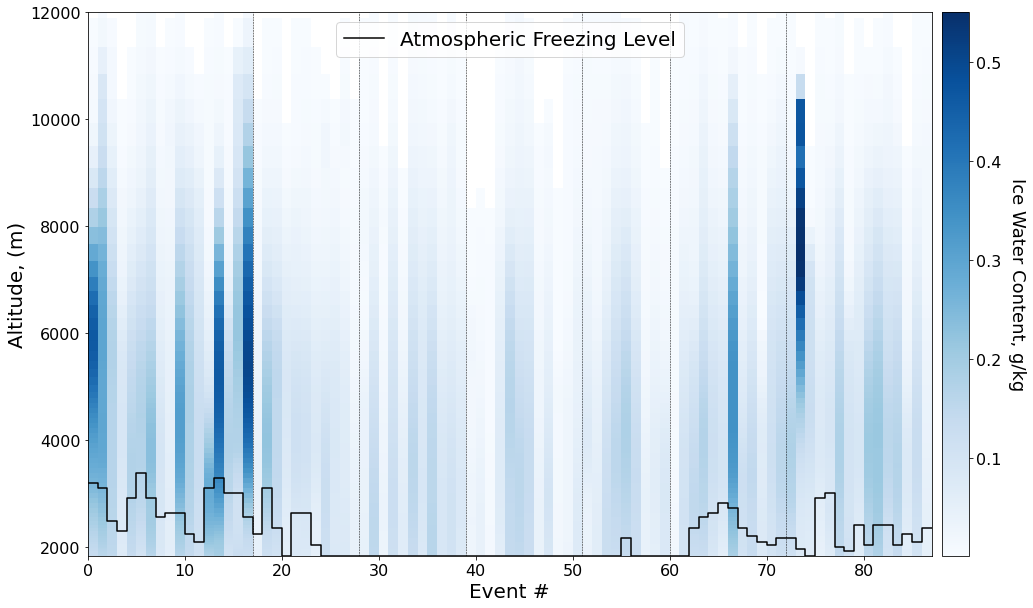

In [49]:
plt.figure(figsize=[18,10])
plt.pcolormesh(EventNum, z_bins, np.transpose((QGRAUP_Events_Levels_new + QSNOW_Events_Levels_new + QICE_Events_Levels_new)*1000), cmap = 'Blues')
plt.step(EventNum, z_bins_below_zero_step_plot, 'k')
plt.legend(labels = ['Atmospheric Freezing Level'], fontsize = 20, loc = 'upper center')
plt.ylim([z_bins[0], 12000])
plt.xlabel('Event #', fontsize = 20)
plt.ylabel('Altitude, (m)', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.plot([17, 17], [0, 12000], '--k', linewidth = 0.5)
plt.plot([28, 28], [0, 12000], '--k', linewidth = 0.5)
plt.plot([39, 39], [0, 12000], '--k', linewidth = 0.5)
plt.plot([51, 51], [0, 12000], '--k', linewidth = 0.5)
plt.plot([60, 60], [0, 12000], '--k', linewidth = 0.5)
plt.plot([72, 72], [0, 12000], '--k', linewidth = 0.5)
# plt.title('Snow & Ice Content (QICE + QSNOW + QGRAUP) per Event', fontsize = 26, weight = 'bold')
cbar = plt.colorbar(pad = 0.01)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(label = 'Ice Water Content, g/kg', size=18, rotation = 270, labelpad = 25)
plt.show()

/glade/u/home/mwarms/miniconda3/envs/snowie_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


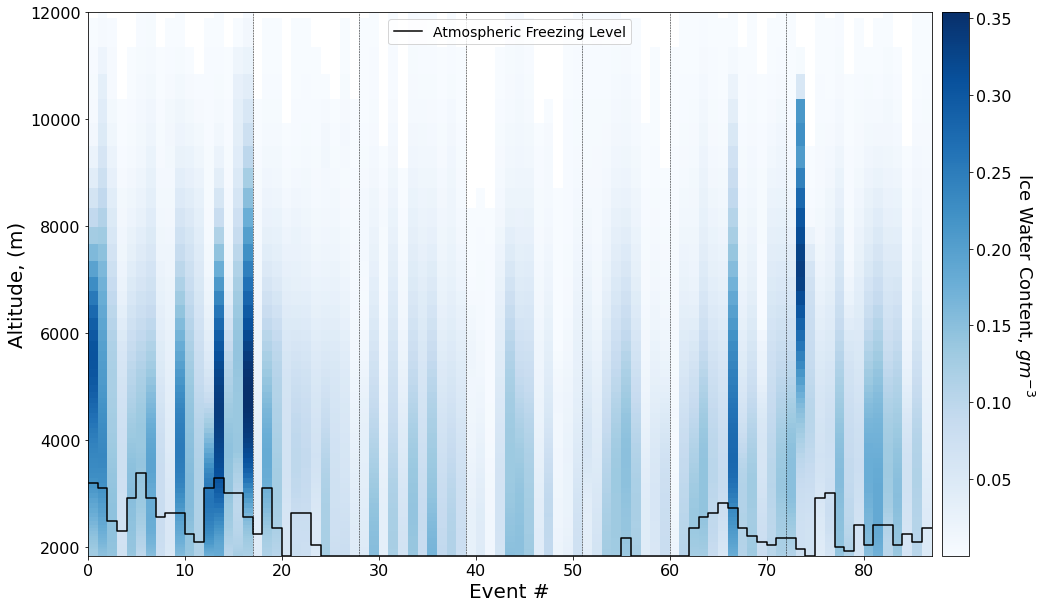

In [158]:
test = np.array(3201.359375)
EventNum = np.arange(0,88,1)
z_bins_below_zero_step_plot = np.append(test, z_bins_below_zero)

plt.figure(figsize=[18,10])
plt.pcolormesh(EventNum, z_bins, np.transpose(IWC_Events_Levels)*1000*100, cmap = 'Blues')
plt.step(EventNum, z_bins_below_zero_step_plot, 'k')
plt.legend(labels = ['Atmospheric Freezing Level'], fontsize =14, loc = 'upper center')
plt.ylim([z_bins[0], 12000])
plt.xlabel('Event #', fontsize = 20)
plt.ylabel('Altitude, (m)', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.plot([17, 17], [0, 12000], '--k', linewidth = 0.5)
plt.plot([28, 28], [0, 12000], '--k', linewidth = 0.5)
plt.plot([39, 39], [0, 12000], '--k', linewidth = 0.5)
plt.plot([51, 51], [0, 12000], '--k', linewidth = 0.5)
plt.plot([60, 60], [0, 12000], '--k', linewidth = 0.5)
plt.plot([72, 72], [0, 12000], '--k', linewidth = 0.5)
# plt.title('Snow & Ice Content (QICE + QSNOW + QGRAUP) per Event', fontsize = 26, weight = 'bold')
cbar = plt.colorbar(pad = 0.01)
cbar.ax.tick_params(labelsize=16) 
cbar.set_label(label = 'Ice Water Content, $gm^{-3}$', size=18, rotation = 270, labelpad = 25)
plt.show()

/glade/u/home/mwarms/miniconda3/envs/snowie_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


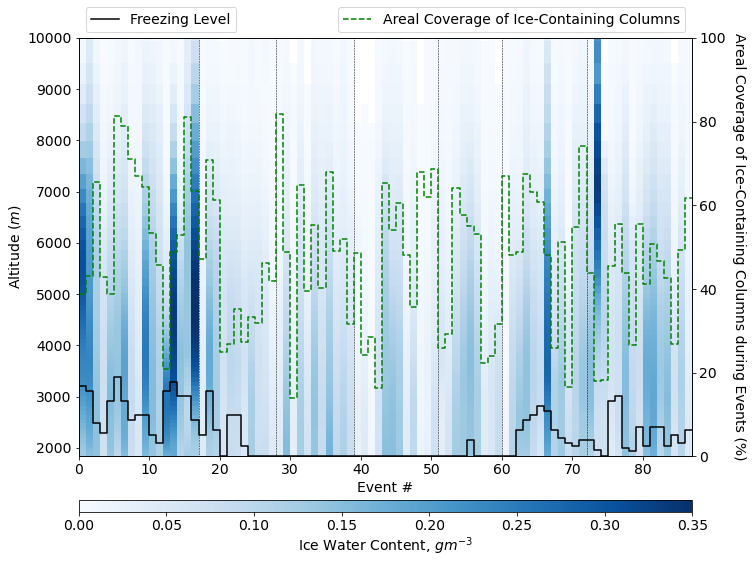

In [102]:
test = np.array(3201.359375)
EventNum = np.arange(0,88,1)
z_bins_below_zero_step_plot = np.append(test, z_bins_below_zero)
icybins_step_plot = np.append(PercentGridCellsIcyPerEvent[0],PercentGridCellsIcyPerEvent)

fig = plt.figure(figsize=[18,15])
fig.set_size_inches(11, 10)
ax = fig.add_subplot(111)
plt.pcolormesh(EventNum, z_bins, np.transpose(IWC_Events_Levels)*1000*100, cmap = 'Blues', vmin = 0, vmax = 0.35)
plt.step(EventNum, z_bins_below_zero_step_plot, 'k')
plt.legend(labels = ['Freezing Level'], fontsize = 14, loc = 'upper left', bbox_to_anchor=(0,1.09))
plt.plot([17, 17], [0, 12000], '--k', linewidth = 0.5)
plt.plot([28, 28], [0, 12000], '--k', linewidth = 0.5)
plt.plot([39, 39], [0, 12000], '--k', linewidth = 0.5)
plt.plot([51, 51], [0, 12000], '--k', linewidth = 0.5)
plt.plot([60, 60], [0, 12000], '--k', linewidth = 0.5)
plt.plot([72, 72], [0, 12000], '--k', linewidth = 0.5)
plt.xlabel('Event #', fontsize = 14)
plt.ylabel('Altitude $(m)$', fontsize = 14)
cbar = plt.colorbar(pad = 0.08, orientation = 'horizontal', aspect = 50)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(label = 'Ice Water Content, $gm^{-3}$', size=14, labelpad = 2)

plt.ylim([z_bins[0], 10000])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

ax2 = ax.twinx()
ax2.step(EventNum, icybins_step_plot, '--g')
ax2.set_ylabel('Areal Coverage of Ice-Containing Columns during Events (%)', fontsize = 14, rotation = 270, labelpad = 20)
ax2.set_ylim([0,100])
plt.legend(labels = ['Areal Coverage of Ice-Containing Columns'], fontsize = 14, loc = 'upper right', bbox_to_anchor=(1,1.09))
plt.yticks(fontsize = 14)
plt.show()

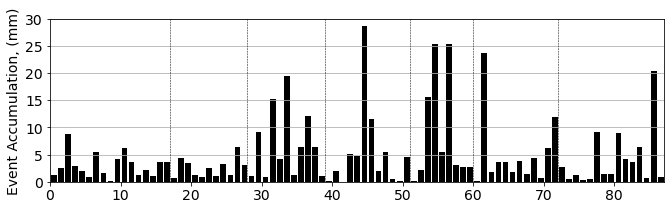

In [92]:
fig = plt.figure(figsize=[18,5])
fig.set_size_inches(11, 3)

ax = fig.add_subplot(111)
ax.bar(0.5+EventNum[:-1], SNOWNC_snowie_Events_new, width=0.95, facecolor='black', edgecolor='white')

# plt.xlabel('Event #', fontsize = 20)
plt.ylabel('Event Accumulation, (mm)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax.set_xlim([0,87])
ax.set_ylim([0,30])
ax.grid(axis = 'y')
plt.plot([17, 17], [0, 12000], '--k', linewidth = 0.5)
plt.plot([28, 28], [0, 12000], '--k', linewidth = 0.5)
plt.plot([39, 39], [0, 12000], '--k', linewidth = 0.5)
plt.plot([51, 51], [0, 12000], '--k', linewidth = 0.5)
plt.plot([60, 60], [0, 12000], '--k', linewidth = 0.5)
plt.plot([72, 72], [0, 12000], '--k', linewidth = 0.5)


plt.show()

NameError: name 'integ_IWC_events' is not defined

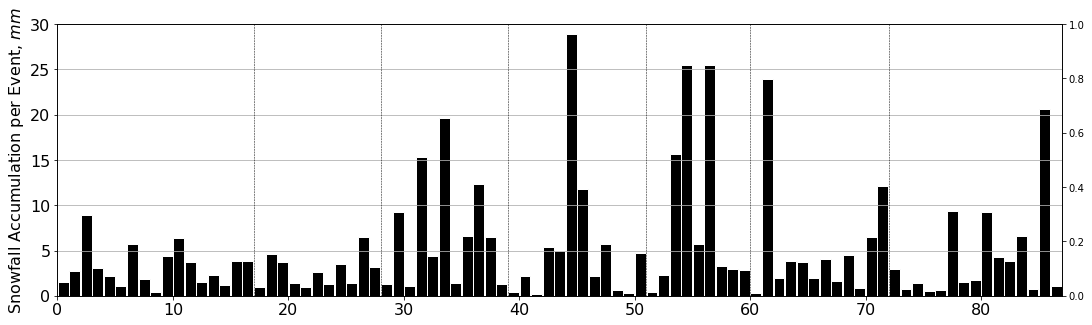

In [83]:
fig = plt.figure(figsize=[18,5])
ax = fig.add_subplot(111)
ax.bar(0.5+EventNum[:-1], SNOWNC_snowie_Events_new, width=0.95, facecolor='black', edgecolor='white')

# plt.xlabel('Event #', fontsize = 20)
plt.ylabel('Snowfall Accumulation per Event, $mm$', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.set_xlim([0,87])
ax.set_ylim([0,30])
ax.grid(axis = 'y')
plt.plot([17, 17], [0, 12000], '--k', linewidth = 0.5)
plt.plot([28, 28], [0, 12000], '--k', linewidth = 0.5)
plt.plot([39, 39], [0, 12000], '--k', linewidth = 0.5)
plt.plot([51, 51], [0, 12000], '--k', linewidth = 0.5)
plt.plot([60, 60], [0, 12000], '--k', linewidth = 0.5)
plt.plot([72, 72], [0, 12000], '--k', linewidth = 0.5)

ax2 = ax.twinx()
ax2.scatter(0.5+EventNum[:-1], integ_IWC_events / integ_SLW_events)
ax2.scatter(0.5+EventNum[:-1], integ_SLW_events)
ax2.set_ylim([0,1.5])

plt.show()

In [66]:
greaterthan10mm = np.where(SNOWNC_snowie_Events_new > 10)
greaterthan10mm

(array([31, 33, 36, 44, 45, 53, 54, 56, 61, 71, 85]),)

In [88]:
np.round(integ_SLW_events[greaterthan10mm],3)

array([0.438, 0.392, 0.329, 0.465, 0.427, 0.476, 0.517, 0.467, 0.503,
       0.375, 0.477])

In [89]:
np.round(integ_IWC_events[greaterthan10mm],3)

array([0.511, 0.625, 0.348, 0.618, 0.567, 0.454, 0.618, 0.514, 0.401,
       0.625, 0.497])

In [90]:
np.round(np.array(PercentGridCellsCloudyPerEvent)[greaterthan10mm],3)

array([64.788, 55.387, 49.093, 54.168, 60.466, 64.054, 57.774, 53.24 ,
       48.081, 74.234, 49.288])

In [91]:
np.round(integ_IWC_events[greaterthan10mm] / integ_SLW_events[greaterthan10mm], 3)

array([1.168, 1.593, 1.061, 1.329, 1.328, 0.954, 1.196, 1.102, 0.797,
       1.664, 1.041])

In [101]:
np.sum(Atm_Temp_BelowZero, axis = 1)[greaterthan10mm]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 13., 11.])

In [107]:
EventCountsPerMonth

[17, 28, 39, 51, 60, 72, 87]

In [104]:
np.where(SNOWNC_snowie_Events_new < 5)

(array([ 0,  1,  3,  4,  5,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 27, 28, 30, 32, 34, 38, 39, 40, 41, 43, 46,
        48, 49, 50, 51, 52, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69,
        72, 73, 74, 75, 76, 78, 79, 81, 82, 84, 86]),)

In [103]:
np.where(integ_SLW_events > 0.35)

(array([ 0,  1,  2,  3,  4,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 19,
        25, 28, 29, 31, 33, 34, 35, 37, 43, 44, 45, 47, 49, 50, 53, 54, 55,
        56, 60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 73, 74, 76, 77, 78,
        80, 81, 82, 83, 84, 85, 86]),)

In [117]:
np.where((SNOWNC_snowie_Events_new < 10) & (integ_SLW_events > 0.35))

(array([ 0,  1,  2,  3,  4,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 19,
        25, 28, 29, 34, 35, 37, 43, 47, 49, 50, 55, 60, 62, 63, 64, 66, 67,
        68, 70, 72, 73, 74, 76, 77, 78, 80, 81, 82, 83, 84, 86]),)

In [118]:
np.where((SNOWNC_snowie_Events_new < 10) & (integ_SLW_events > 0.35))[0].shape

(48,)

In [120]:
DJF_ineff = [29, 34, 35, 37, 43, 47, 49, 50, 55, 60]

In [131]:
np.round(integ_IWC_events[DJF_ineff] / integ_SLW_events[DJF_ineff], 3)

array([1.5  , 1.057, 1.477, 1.106, 1.287, 0.954, 0.237, 0.489, 1.257,
       0.123])

In [129]:
np.array(EventLengths)[DJF_ineff]

array([25,  9, 19, 31, 16, 46,  1, 30, 25,  2])

In [113]:
MonthlyLastTimestep

[0, 744, 1463, 2207, 2951, 3623, 4367, 5087]

In [125]:
i = 35
print("Snowfall Accumulation for Event #", i, ": ", SNOWNC_snowie_Events_new[i-1], "mm")
print("Event starts on timestep", EventTimesStart[i-1], "and ends on timestep", EventTimesEnd[i-1]) 
print("Event Length for Event #", i, ": ", EventLengths[i-1], "hours")
print("Max and Mean LWC for Event #", i, ": ", np.round(np.nanmax(LWC_Events_Levels[i-1]*1000*100),4), "|", np.round(np.nanmean(LWC_Events_Levels[i-1]*1000*100),4), "g/m^3")
print("Max and Mean IWC for Event #", i, ": ", np.round(np.nanmax(IWC_Events_Levels[i-1]*1000*100),4), "|", np.round(np.nanmean(IWC_Events_Levels[i-1]*1000*100),4), "g/m^3")
print("Column Integrated SLW for Event #:", i, ":,", np.round(integ_SLW_events[i-1], 3), "kg/m^2")
print("Column Integrated IWC for Event #:", i, ":,", np.round(integ_IWC_events[i-1], 3), "kg/m^2")
print("Column Integrated IWC / SLW for Event #:", i, ":,", np.round(integ_IWC_events[i-1] / integ_SLW_events[i-1], 3))
print("Percent Cloudy for Event #:", i, ":,", np.round(PercentGridCellsCloudyPerEvent[i-1],3), "%")
print("Snowfall rate for Event #:", i, ":,", np.round(SNOWNC_snowie_Events_new[i-1] / EventLengths[i-1],3), "mm/hr")

Snowfall Accumulation for Event # 35 :  1.3844079971313477 mm
Event starts on timestep 1915 and ends on timestep 1924
Event Length for Event # 35 :  9 hours
Max and Mean LWC for Event # 35 :  0.1172 | 0.0718 g/m^3
Max and Mean IWC for Event # 35 :  0.0862 | 0.0612 g/m^3
Column Integrated SLW for Event #: 35 :, 0.382 kg/m^2
Column Integrated IWC for Event #: 35 :, 0.403 kg/m^2
Column Integrated IWC / SLW for Event #: 35 :, 1.057
Percent Cloudy for Event #: 35 :, 40.153 %
Snowfall rate for Event #: 35 :, 0.154 mm/hr


In [44]:
i = 34
print("Snowfall Accumulation for Event #", i, ": ", SNOWNC_snowie_Events_new[i-1], "mm")
print("Event starts on timestep", EventTimesStart[i-1], "and ends on timestep", EventTimesEnd[i-1]) 
print("Event Length for Event #", i, ": ", EventLengths[i-1], "hours")
print("Max and Mean LWC for Event #", i, ": ", np.round(np.nanmax(LWC_Events_Levels[i-1]*1000*100),4), "|", np.round(np.nanmean(LWC_Events_Levels[i-1]*1000*100),4), "g/m^3")
print("Max and Mean IWC for Event #", i, ": ", np.round(np.nanmax(IWC_Events_Levels[i-1]*1000*100),4), "|", np.round(np.nanmean(IWC_Events_Levels[i-1]*1000*100),4), "g/m^3")
print("Column Integrated SLW for Event #:", i, ":,", np.round(integ_SLW_events[i-1], 3), "kg/m^2")
print("Column Integrated IWC for Event #:", i, ":,", np.round(integ_IWC_events[i-1], 3), "kg/m^2")
print("Column Integrated IWC / SLW for Event #:", i, ":,", np.round(integ_IWC_events[i-1] / integ_SLW_events[i-1], 3))
print("Percent Cloudy for Event #:", i, ":,", np.round(PercentGridCellsCloudyPerEvent[i-1],3), "%")
print("Snowfall rate for Event #:", i, ":,", np.round(SNOWNC_snowie_Events_new[i-1] / EventLengths[i-1],3), "mm/hr")

Snowfall Accumulation for Event # 34 :  19.631763458251953 mm
Event starts on timestep 1791 and ends on timestep 1852
Event Length for Event # 34 :  61 hours
Max and Mean LWC for Event # 34 :  0.0956 | 0.0704 g/m^3
Max and Mean IWC for Event # 34 :  0.1415 | 0.0964 g/m^3
Column Integrated SLW for Event #: 34 :, 0.392 kg/m^2
Column Integrated IWC for Event #: 34 :, 0.625 kg/m^2
Column Integrated IWC / SLW for Event #: 34 :, 1.593
Percent Cloudy for Event #: 34 :, 55.387 %
Snowfall rate for Event #: 34 :, 0.322 mm/hr


In [47]:
i = 37
print("Snowfall Accumulation for Event #", i, ": ", SNOWNC_snowie_Events_new[i-1], "mm")
print("Event Length for Event #", i, ": ", EventLengths[i-1], "hours")
print("Event starts on timestep", EventTimesStart[i-1], "and ends on timestep", EventTimesEnd[i-1]) 
print("Max and Mean LWC for Event #", i, ": ", np.round(np.nanmax(LWC_Events_Levels[i-1]*1000*100),4), "|", np.round(np.nanmean(LWC_Events_Levels[i-1]*1000*100),4), "g/m^3")
print("Max and Mean IWC for Event #", i, ": ", np.round(np.nanmax(IWC_Events_Levels[i-1]*1000*100),4), "|", np.round(np.nanmean(IWC_Events_Levels[i-1]*1000*100),4), "g/m^3")
print("Column Integrated SLW for Event #:", i, ":,", np.round(integ_SLW_events[i-1], 3), "kg/m^2")
print("Column Integrated IWC for Event #:", i, ":,", np.round(integ_IWC_events[i-1], 3), "kg/m^2")
print("Column Integrated IWC / SLW for Event #:", i, ":,", np.round(integ_IWC_events[i-1] / integ_SLW_events[i-1], 3))
print("Percent Cloudy for Event #:", i, ":,", np.round(PercentGridCellsCloudyPerEvent[i-1],3), "%")
print("Snowfall rate for Event #:", i, ":,", np.round(SNOWNC_snowie_Events_new[i-1] / EventLengths[i-1],3), "mm/hr")

Snowfall Accumulation for Event # 37 :  12.347696304321289 mm
Event Length for Event # 37 :  57 hours
Event starts on timestep 2009 and ends on timestep 2066
Max and Mean LWC for Event # 37 :  0.0753 | 0.0641 g/m^3
Max and Mean IWC for Event # 37 :  0.0939 | 0.0628 g/m^3
Column Integrated SLW for Event #: 37 :, 0.329 kg/m^2
Column Integrated IWC for Event #: 37 :, 0.348 kg/m^2
Column Integrated IWC / SLW for Event #: 37 :, 1.061
Percent Cloudy for Event #: 37 :, 49.093 %
Snowfall rate for Event #: 37 :, 0.217 mm/hr


In [51]:
i = 62
print("Snowfall Accumulation for Event #", i, ": ", SNOWNC_snowie_Events_new[i-1], "mm")
print("Event Length for Event #", i, ": ", EventLengths[i-1], "hours")
print("Max and Mean LWC for Event #", i, ": ", np.round(np.nanmax(LWC_Events_Levels[i-1]*1000*100),4), "|", np.round(np.nanmean(LWC_Events_Levels[i-1]*1000*100),4), "g/m^3")
print("Max and Mean IWC for Event #", i, ": ", np.round(np.nanmax(IWC_Events_Levels[i-1]*1000*100),4), "|", np.round(np.nanmean(IWC_Events_Levels[i-1]*1000*100),4), "g/m^3")
print("Column Integrated SLW for Event #:", i, ":,", np.round(integ_SLW_events[i-1], 3), "kg/m^2")
print("Column Integrated IWC for Event #:", i, ":,", np.round(integ_IWC_events[i-1], 3), "kg/m^2")
print("Column Integrated IWC / SLW for Event #:", i, ":,", np.round(integ_IWC_events[i-1] / integ_SLW_events[i-1], 3))
print("Percent Cloudy for Event #:", i, ":,", np.round(PercentGridCellsCloudyPerEvent[i-1],3), "%")
print("Snowfall rate for Event #:", i, ":,", np.round(SNOWNC_snowie_Events_new[i-1] / EventLengths[i-1],3), "mm/hr")

Snowfall Accumulation for Event # 62 :  23.89259147644043 mm
Event Length for Event # 62 :  157 hours
Max and Mean LWC for Event # 62 :  0.1239 | 0.0884 g/m^3
Max and Mean IWC for Event # 62 :  0.1059 | 0.0695 g/m^3
Column Integrated SLW for Event #: 62 :, 0.503 kg/m^2
Column Integrated IWC for Event #: 62 :, 0.401 kg/m^2
Column Integrated IWC / SLW for Event #: 62 :, 0.797
Percent Cloudy for Event #: 62 :, 48.081 %
Snowfall rate for Event #: 62 :, 0.152 mm/hr


In [52]:
i = 72
print("Snowfall Accumulation for Event #", i, ": ", SNOWNC_snowie_Events_new[i-1], "mm")
print("Event Length for Event #", i, ": ", EventLengths[i-1], "hours")
print("Max and Mean LWC for Event #", i, ": ", np.round(np.nanmax(LWC_Events_Levels[i-1]*1000*100),4), "|", np.round(np.nanmean(LWC_Events_Levels[i-1]*1000*100),4), "g/m^3")
print("Max and Mean IWC for Event #", i, ": ", np.round(np.nanmax(IWC_Events_Levels[i-1]*1000*100),4), "|", np.round(np.nanmean(IWC_Events_Levels[i-1]*1000*100),4), "g/m^3")
print("Column Integrated SLW for Event #:", i, ":,", np.round(integ_SLW_events[i-1], 3), "kg/m^2")
print("Column Integrated IWC for Event #:", i, ":,", np.round(integ_IWC_events[i-1], 3), "kg/m^2")
print("Percent Cloudy for Event #:", i, ":,", np.round(PercentGridCellsCloudyPerEvent[i-1],3), "%")
print("Snowfall rate for Event #:", i, ":,", np.round(SNOWNC_snowie_Events_new[i-1] / EventLengths[i-1],3), "mm/hr")

Snowfall Accumulation for Event # 72 :  12.140685081481934 mm
Event Length for Event # 72 :  51 hours
Max and Mean LWC for Event # 72 :  0.0976 | 0.0698 g/m^3
Max and Mean IWC for Event # 72 :  0.1374 | 0.0961 g/m^3
Column Integrated SLW for Event #: 72 :, 0.375 kg/m^2
Column Integrated IWC for Event #: 72 :, 0.625 kg/m^2
Percent Cloudy for Event #: 72 :, 74.234 %
Snowfall rate for Event #: 72 :, 0.238 mm/hr


- Correlation (r is first, p-value second)


In [106]:
pearson_r_SLW = stats.pearsonr(integ_SLW_events, SNOWNC_snowie_Events_new)
pearson_r_SLW

(0.19242311332497392, 0.07416883776409741)

In [105]:
pearson_r_IWC = stats.pearsonr(integ_IWC_events, SNOWNC_snowie_Events_new)
pearson_r_IWC

(0.10981976718252018, 0.3112600418113743)

In [107]:
pearson_r_SLW_dec_thru_feb = stats.pearsonr(integ_SLW_events[EventCountsPerMonth[1]:EventCountsPerMonth[4]], SNOWNC_snowie_Events_new[EventCountsPerMonth[1]:EventCountsPerMonth[4]])
pearson_r_SLW_dec_thru_feb

(0.5198056961540996, 0.002294758570669414)

In [128]:
pearson_r_IWC_dec_thru_feb = stats.pearsonr(integ_IWC_events[EventCountsPerMonth[2]:EventCountsPerMonth[4]], SNOWNC_snowie_Events_new[EventCountsPerMonth[2]:EventCountsPerMonth[4]])
pearson_r_IWC_dec_thru_feb

(0.6939500554567924, 0.0004841477518659906)

In [31]:
EventCountsPerMonth = [17, 28, 39, 51, 60, 72, 87]
Months = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr"]

In [32]:
Monthly_Avg_IWC_events = np.zeros(7)

Monthly_Avg_IWC_events[0] = np.nanmean(1000*100*IWC_Events_Levels[0:EventCountsPerMonth[0],:])
Monthly_Avg_IWC_events[1] = np.nanmean(1000*100*IWC_Events_Levels[EventCountsPerMonth[0]:EventCountsPerMonth[1],:])
Monthly_Avg_IWC_events[2] = np.nanmean(1000*100*IWC_Events_Levels[EventCountsPerMonth[1]:EventCountsPerMonth[2],:])
Monthly_Avg_IWC_events[3] = np.nanmean(1000*100*IWC_Events_Levels[EventCountsPerMonth[2]:EventCountsPerMonth[3],:])
Monthly_Avg_IWC_events[4] = np.nanmean(1000*100*IWC_Events_Levels[EventCountsPerMonth[3]:EventCountsPerMonth[4],:])
Monthly_Avg_IWC_events[5] = np.nanmean(1000*100*IWC_Events_Levels[EventCountsPerMonth[4]:EventCountsPerMonth[5],:])
Monthly_Avg_IWC_events[6] = np.nanmean(1000*100*IWC_Events_Levels[EventCountsPerMonth[5]:EventCountsPerMonth[6],:])

In [33]:
print("Average Monthly IWC during events in...", end = " "),
for i in range(0,len(Monthly_Avg_IWC_events)):
    print(Months[i], "=", "{:.3f}".format(Monthly_Avg_IWC_events[i]), "g m-3", end = "; "),

Average Monthly IWC during events in... Oct = 0.126 g m-3; Nov = 0.064 g m-3; Dec = 0.068 g m-3; Jan = 0.050 g m-3; Feb = 0.064 g m-3; Mar = 0.083 g m-3; Apr = 0.087 g m-3; 

In [34]:
Monthly_Avg_PercentIcy_events = np.zeros(7)

Monthly_Avg_PercentIcy_events[0] = np.nanmean(PercentGridCellsIcyPerEvent[0:EventCountsPerMonth[0]])
Monthly_Avg_PercentIcy_events[1] = np.nanmean(PercentGridCellsIcyPerEvent[EventCountsPerMonth[0]:EventCountsPerMonth[1]])
Monthly_Avg_PercentIcy_events[2] = np.nanmean(PercentGridCellsIcyPerEvent[EventCountsPerMonth[1]:EventCountsPerMonth[2]])
Monthly_Avg_PercentIcy_events[3] = np.nanmean(PercentGridCellsIcyPerEvent[EventCountsPerMonth[2]:EventCountsPerMonth[3]])
Monthly_Avg_PercentIcy_events[4] = np.nanmean(PercentGridCellsIcyPerEvent[EventCountsPerMonth[3]:EventCountsPerMonth[4]])
Monthly_Avg_PercentIcy_events[5] = np.nanmean(PercentGridCellsIcyPerEvent[EventCountsPerMonth[4]:EventCountsPerMonth[5]])
Monthly_Avg_PercentIcy_events[6] = np.nanmean(PercentGridCellsIcyPerEvent[EventCountsPerMonth[5]:EventCountsPerMonth[6]])

In [35]:
print("Average Monthly Percent Icy during events in...", end = " "),
for i in range(0,len(Monthly_Avg_LWC_events)):
    print(Months[i], "=", "{:.3f}".format(Monthly_Avg_PercentIcy_events[i]), "%", end = "; "),

Average Monthly Percent Icy during events in... Oct = 56.365 %; Nov = 40.648 %; Dec = 49.551 %; Jan = 48.303 %; Feb = 40.356 %; Mar = 52.153 %; Apr = 41.738 %; 

In [91]:
Diff_bt_atm_levels_below_10km = z_bins[1:65] - z_bins[0:64]

In [44]:
Monthly_integ_IWC_events = np.zeros(7)  # value in g m-3

Monthly_integ_IWC_events[0] = np.nansum((IWC_Events_Levels[0:EventCountsPerMonth[0],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[0] / 1000
Monthly_integ_IWC_events[1] = np.nansum((IWC_Events_Levels[EventCountsPerMonth[0]:EventCountsPerMonth[1],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[1] / 1000
Monthly_integ_IWC_events[2] = np.nansum((IWC_Events_Levels[EventCountsPerMonth[1]:EventCountsPerMonth[2],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[2] / 1000
Monthly_integ_IWC_events[3] = np.nansum((IWC_Events_Levels[EventCountsPerMonth[2]:EventCountsPerMonth[3],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[3] / 1000
Monthly_integ_IWC_events[4] = np.nansum((IWC_Events_Levels[EventCountsPerMonth[3]:EventCountsPerMonth[4],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[4] / 1000
Monthly_integ_IWC_events[5] = np.nansum((IWC_Events_Levels[EventCountsPerMonth[4]:EventCountsPerMonth[5],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[5] / 1000
Monthly_integ_IWC_events[6] = np.nansum((IWC_Events_Levels[EventCountsPerMonth[5]:EventCountsPerMonth[6],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / EventsPerMonth[6] / 1000

In [45]:
print("Average Monthly LWC during events in...", end = " "),
for i in range(0,len(Monthly_integ_IWC_events)):
    print(Months[i], "=", "{:.3f}".format(Monthly_integ_IWC_events[i]), "kg m-2", end = "; "),

Average Monthly LWC during events in... Oct = 0.825 kg m-2; Nov = 0.370 kg m-2; Dec = 0.370 kg m-2; Jan = 0.264 kg m-2; Feb = 0.357 kg m-2; Mar = 0.489 kg m-2; Apr = 0.540 kg m-2; 

In [93]:
Monthly_integ_IWC_events = np.zeros(7)  # value in g m-3

Monthly_integ_IWC_events[0] = np.nansum((IWC_Events_Levels[0:EventCountsPerMonth[0],0:64]*100*1000 * 
                                    Diff_bt_atm_levels_below_10km)) / EventsPerMonth[0] / 1000
Monthly_integ_IWC_events[1] = np.nansum((IWC_Events_Levels[EventCountsPerMonth[0]:EventCountsPerMonth[1],0:64]*100*1000 * 
                                    Diff_bt_atm_levels_below_10km)) / EventsPerMonth[1] / 1000
Monthly_integ_IWC_events[2] = np.nansum((IWC_Events_Levels[EventCountsPerMonth[1]:EventCountsPerMonth[2],0:64]*100*1000 * 
                                    Diff_bt_atm_levels_below_10km)) / EventsPerMonth[2] / 1000
Monthly_integ_IWC_events[3] = np.nansum((IWC_Events_Levels[EventCountsPerMonth[2]:EventCountsPerMonth[3],0:64]*100*1000 * 
                                    Diff_bt_atm_levels_below_10km)) / EventsPerMonth[3] / 1000
Monthly_integ_IWC_events[4] = np.nansum((IWC_Events_Levels[EventCountsPerMonth[3]:EventCountsPerMonth[4],0:64]*100*1000 * 
                                    Diff_bt_atm_levels_below_10km)) / EventsPerMonth[4] / 1000
Monthly_integ_IWC_events[5] = np.nansum((IWC_Events_Levels[EventCountsPerMonth[4]:EventCountsPerMonth[5],0:64]*100*1000 * 
                                    Diff_bt_atm_levels_below_10km)) / EventsPerMonth[5] / 1000
Monthly_integ_IWC_events[6] = np.nansum((IWC_Events_Levels[EventCountsPerMonth[5]:EventCountsPerMonth[6],0:64]*100*1000 * 
                                    Diff_bt_atm_levels_below_10km)) / EventsPerMonth[6] / 1000

In [94]:
print("Average Monthly LWC during events in...", end = " "),
for i in range(0,len(Monthly_integ_IWC_events)):
    print(Months[i], "=", "{:.3f}".format(Monthly_integ_IWC_events[i]), "kg m-2", end = "; "),

Average Monthly LWC during events in... Oct = 0.887 kg m-2; Nov = 0.385 kg m-2; Dec = 0.390 kg m-2; Jan = 0.277 kg m-2; Feb = 0.373 kg m-2; Mar = 0.521 kg m-2; Apr = 0.593 kg m-2; 

## Figure 10 - Scatter Plot of the Ratio of Snow and Ice content to Supercooled Liquid Water Content

In [103]:
Atm_Temp_BelowZero = np.genfromtxt(Saved_Data_Path + 'Atm_Temp_BelowZero.csv', delimiter = ",")

In [24]:
QRAIN_below_zero_all_levels = np.zeros([87,80])
QCLOUD_below_zero_all_levels = np.zeros([87,80])

for j in range(0,sum(EventsPerMonth)):
    for i in range(0,80):
        if Atm_Temp_BelowZero[j,i] == 0:
            QRAIN_below_zero_all_levels[j,i] = QRAIN_Events_Levels_new[j,i]
            QCLOUD_below_zero_all_levels[j,i] = QCLOUD_Events_Levels_new[j,i]    
        else:     
            QRAIN_below_zero_all_levels[j,i] = 0
            QCLOUD_below_zero_all_levels[j,i] = 0        

In [25]:
LWC_below_zero_all_levels = np.zeros([87,80])

for j in range(0,sum(EventsPerMonth)):
    for i in range(0,80):
        if Atm_Temp_BelowZero[j,i] == 0:
            LWC_below_zero_all_levels[j,i] = LWC_Events_Levels[j,i]
        else:     
            LWC_below_zero_all_levels[j,i] = 0

In [26]:
z_bins_index_Temp_Below_Zero = []

z_bins_below_zero = np.zeros(87)
QRAIN_below_zero = np.zeros(87)
QCLOUD_below_zero = np.zeros(87)

for j in range(0,sum(EventsPerMonth)):
    for i in range(0,80):
        if Atm_Temp_BelowZero[j,i] == 0:
            z_bins_index_Temp_Below_Zero.append(i)
            break

for k in range(0,sum(EventsPerMonth)):
    z_bins_below_zero[k] = z_bins[z_bins_index_Temp_Below_Zero[k]] 
    QRAIN_below_zero[k] = np.nansum(QRAIN_below_zero_all_levels[k,z_bins_index_Temp_Below_Zero[k]:79])
    QCLOUD_below_zero[k] = np.nansum(QCLOUD_below_zero_all_levels[k,z_bins_index_Temp_Below_Zero[k]:79])

In [27]:
QRAIN_event_sum = np.nansum(QRAIN_Events_Levels_new, axis = 1)
QSNOW_event_sum = np.nansum(QSNOW_Events_Levels_new, axis = 1)
QICE_event_sum = np.nansum(QICE_Events_Levels_new, axis = 1)
QGRAUP_event_sum = np.nansum(QGRAUP_Events_Levels_new, axis = 1)
QCLOUD_event_sum = np.nansum(QGRAUP_Events_Levels_new, axis = 1)

In [28]:
SLW_event_sum = np.nansum(LWC_below_zero_all_levels, axis = 1)
IWC_event_sum = np.nansum(IWC_Events_Levels, axis = 1)

In [29]:
SLW_event_mean = np.nanmean(LWC_below_zero_all_levels, axis = 1)
IWC_event_mean = np.nanmean(IWC_Events_Levels, axis = 1)

In [30]:
Monthly_Avg_SLW_events = np.zeros(7)

Monthly_Avg_SLW_events[0] = np.nansum((LWC_below_zero_all_levels[0:EventCountsPerMonth[0],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / sum(Diff_bt_atm_levels_below_8km) / EventsPerMonth[0]
Monthly_Avg_SLW_events[1] = np.nansum((LWC_below_zero_all_levels[EventCountsPerMonth[0]:EventCountsPerMonth[1],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / sum(Diff_bt_atm_levels_below_8km) / EventsPerMonth[1]
Monthly_Avg_SLW_events[2] = np.nansum((LWC_below_zero_all_levels[EventCountsPerMonth[1]:EventCountsPerMonth[2],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / sum(Diff_bt_atm_levels_below_8km) / EventsPerMonth[2]
Monthly_Avg_SLW_events[3] = np.nansum((LWC_below_zero_all_levels[EventCountsPerMonth[2]:EventCountsPerMonth[3],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / sum(Diff_bt_atm_levels_below_8km) / EventsPerMonth[3]
Monthly_Avg_SLW_events[4] = np.nansum((LWC_below_zero_all_levels[EventCountsPerMonth[3]:EventCountsPerMonth[4],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / sum(Diff_bt_atm_levels_below_8km) / EventsPerMonth[4]
Monthly_Avg_SLW_events[5] = np.nansum((LWC_below_zero_all_levels[EventCountsPerMonth[4]:EventCountsPerMonth[5],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / sum(Diff_bt_atm_levels_below_8km) / EventsPerMonth[5]
Monthly_Avg_SLW_events[6] = np.nansum((LWC_below_zero_all_levels[EventCountsPerMonth[5]:EventCountsPerMonth[6],0:59]*100*1000 * 
                                    Diff_bt_atm_levels_below_8km)) / sum(Diff_bt_atm_levels_below_8km) / EventsPerMonth[6]

In [31]:
print("Average Monthly SLW during events in...", end = " "),
for i in range(0,len(Monthly_Avg_SLW_events)):
    print(Months[i], "=", "{:.3f}".format(Monthly_Avg_SLW_events[i]), "g m-3", end = "; "),

Average Monthly SLW during events in... Oct = 0.078 g m-3; Nov = 0.057 g m-3; Dec = 0.059 g m-3; Jan = 0.056 g m-3; Feb = 0.059 g m-3; Mar = 0.070 g m-3; Apr = 0.080 g m-3; 

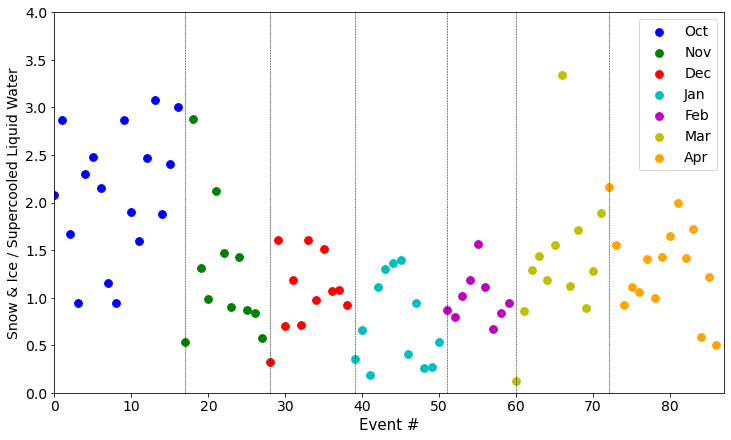

In [32]:
EventNum = np.arange(0,88,1)


plt.figure(figsize = (12,7))
plt.scatter(EventNum[0:17], ((QSNOW_event_sum[0:17]+QICE_event_sum[0:17]+QGRAUP_event_sum[0:17]) / (QRAIN_below_zero[0:17]+QCLOUD_below_zero[0:17])), color = 'b', s = 60, label = 'Oct')
plt.scatter(EventNum[17:28], ((QSNOW_event_sum[17:28]+QICE_event_sum[17:28]+QGRAUP_event_sum[17:28]) / (QRAIN_below_zero[17:28]+QCLOUD_below_zero[17:28])), color = 'g', s = 60, label = 'Nov')
plt.scatter(EventNum[28:39], ((QSNOW_event_sum[28:39]+QICE_event_sum[28:39]+QGRAUP_event_sum[28:39]) / (QRAIN_below_zero[28:39]+QCLOUD_below_zero[28:39])), color = 'r', s = 60, label = 'Dec')
plt.scatter(EventNum[39:51], ((QSNOW_event_sum[39:51]+QICE_event_sum[39:51]+QGRAUP_event_sum[39:51]) / (QRAIN_below_zero[39:51]+QCLOUD_below_zero[39:51])), color = 'c', s = 60, label = 'Jan')
plt.scatter(EventNum[51:60], ((QSNOW_event_sum[51:60]+QICE_event_sum[51:60]+QGRAUP_event_sum[51:60]) / (QRAIN_below_zero[51:60]+QCLOUD_below_zero[51:60])), color = 'm', s = 60, label = 'Feb')
plt.scatter(EventNum[60:72], ((QSNOW_event_sum[60:72]+QICE_event_sum[60:72]+QGRAUP_event_sum[60:72]) / (QRAIN_below_zero[60:72]+QCLOUD_below_zero[60:72])), color = 'y', s = 60, label = 'Mar')
plt.scatter(EventNum[72:87], ((QSNOW_event_sum[72:87]+QICE_event_sum[72:87]+QGRAUP_event_sum[72:87]) / (QRAIN_below_zero[72:87]+QCLOUD_below_zero[72:87])), color = 'orange', s = 60, label = 'Apr')
plt.xlabel('Event #', fontsize = 15)
plt.ylabel('Snow & Ice / Supercooled Liquid Water', fontsize = 14)
# plt.title('Ratio of Snow/Ice Content to SLW Content per Event', fontsize = 23, weight = 'bold')
# plt.grid()
plt.xlim([0, 87])
# plt.yscale('log')
plt.ylim([0, 4])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.plot([17, 17], [0, 120000], '--k', linewidth = 0.5)
plt.plot([28, 28], [0, 120000], '--k', linewidth = 0.5)
plt.plot([39, 39], [0, 120000], '--k', linewidth = 0.5)
plt.plot([51, 51], [0, 120000], '--k', linewidth = 0.5)
plt.plot([60, 60], [0, 120000], '--k', linewidth = 0.5)
plt.plot([72, 72], [0, 120000], '--k', linewidth = 0.5)
plt.legend(fontsize = 14);
plt.show()

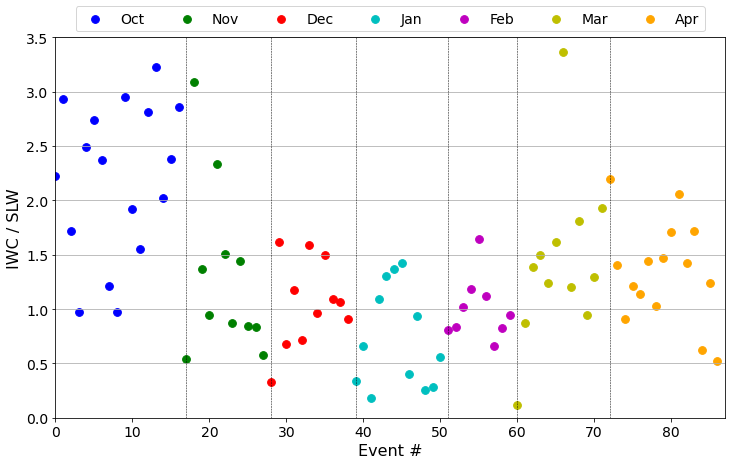

In [33]:
EventNum = np.arange(0,88,1)

plt.figure(figsize = (12,7))
plt.scatter(EventNum[0:17], (IWC_event_sum[0:17]) / (SLW_event_sum[0:17]), color = 'b', s = 60, label = 'Oct')
plt.scatter(EventNum[17:28], (IWC_event_sum[17:28]) / (SLW_event_sum[17:28]), color = 'g', s = 60, label = 'Nov')
plt.scatter(EventNum[28:39], (IWC_event_sum[28:39]) / (SLW_event_sum[28:39]), color = 'r', s = 60, label = 'Dec')
plt.scatter(EventNum[39:51], (IWC_event_sum[39:51]) / (SLW_event_sum[39:51]), color = 'c', s = 60, label = 'Jan')
plt.scatter(EventNum[51:60], (IWC_event_sum[51:60]) / (SLW_event_sum[51:60]), color = 'm', s = 60, label = 'Feb')
plt.scatter(EventNum[60:72], (IWC_event_sum[60:72]) / (SLW_event_sum[60:72]), color = 'y', s = 60, label = 'Mar')
plt.scatter(EventNum[72:87], (IWC_event_sum[72:87]) / (SLW_event_sum[72:87]), color = 'orange', s = 60, label = 'Apr')
plt.xlabel('Event #', fontsize = 16)
plt.ylabel('IWC / SLW', fontsize = 16)
plt.grid(axis = 'y')
plt.xlim([0, 87])
plt.ylim([0, 3.5])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.plot([17, 17], [0, 120000], '--k', linewidth = 0.5)
plt.plot([28, 28], [0, 120000], '--k', linewidth = 0.5)
plt.plot([39, 39], [0, 120000], '--k', linewidth = 0.5)
plt.plot([51, 51], [0, 120000], '--k', linewidth = 0.5)
plt.plot([60, 60], [0, 120000], '--k', linewidth = 0.5)
plt.plot([72, 72], [0, 120000], '--k', linewidth = 0.5)
plt.legend(fontsize = 14, ncol = 7, loc = 'upper center', bbox_to_anchor=(0.5, 1.1));
plt.show()

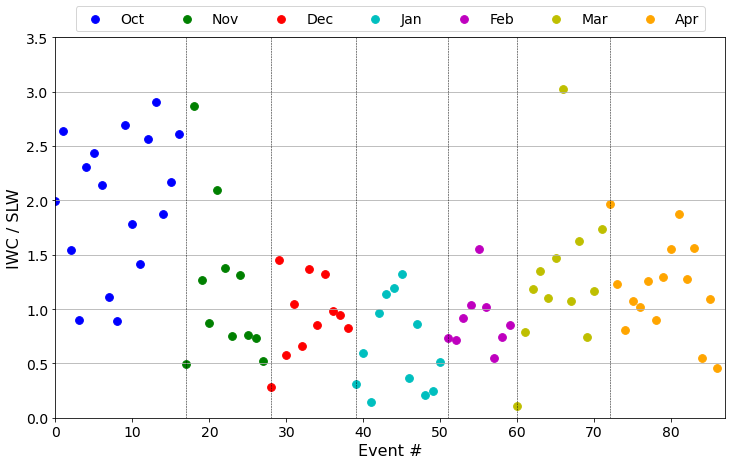

In [143]:
EventNum = np.arange(0,88,1)

plt.figure(figsize = (12,7))
plt.scatter(EventNum[0:17], (IWC_event_mean[0:17]) / (SLW_event_mean[0:17]), color = 'b', s = 60, label = 'Oct')
plt.scatter(EventNum[17:28], (IWC_event_mean[17:28]) / (SLW_event_mean[17:28]), color = 'g', s = 60, label = 'Nov')
plt.scatter(EventNum[28:39], (IWC_event_mean[28:39]) / (SLW_event_mean[28:39]), color = 'r', s = 60, label = 'Dec')
plt.scatter(EventNum[39:51], (IWC_event_mean[39:51]) / (SLW_event_mean[39:51]), color = 'c', s = 60, label = 'Jan')
plt.scatter(EventNum[51:60], (IWC_event_mean[51:60]) / (SLW_event_mean[51:60]), color = 'm', s = 60, label = 'Feb')
plt.scatter(EventNum[60:72], (IWC_event_mean[60:72]) / (SLW_event_mean[60:72]), color = 'y', s = 60, label = 'Mar')
plt.scatter(EventNum[72:87], (IWC_event_mean[72:87]) / (SLW_event_mean[72:87]), color = 'orange', s = 60, label = 'Apr')
plt.xlabel('Event #', fontsize = 16)
plt.ylabel('IWC / SLW', fontsize = 16)
plt.grid(axis = 'y')
plt.xlim([0, 87])
plt.ylim([0, 3.5])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.plot([17, 17], [0, 120000], '--k', linewidth = 0.5)
plt.plot([28, 28], [0, 120000], '--k', linewidth = 0.5)
plt.plot([39, 39], [0, 120000], '--k', linewidth = 0.5)
plt.plot([51, 51], [0, 120000], '--k', linewidth = 0.5)
plt.plot([60, 60], [0, 120000], '--k', linewidth = 0.5)
plt.plot([72, 72], [0, 120000], '--k', linewidth = 0.5)
plt.legend(fontsize = 14, ncol = 7, loc = 'upper center', bbox_to_anchor=(0.5, 1.1));
plt.show()

In [41]:
integ_SLW_events.min(), integ_SLW_events.max()

(0.15041072796144533, 0.9688717557180427)

In [109]:
integ_SLW_events[0:17]

array([0.84182017, 0.50850595, 0.57973722, 0.44702364, 0.35035182,
       0.3328148 , 0.5319647 , 0.38408677, 0.32201522, 0.47714896,
       0.49288904, 0.38533854, 0.39810031, 0.63732102, 0.45285926,
       0.38461831, 0.62219287])

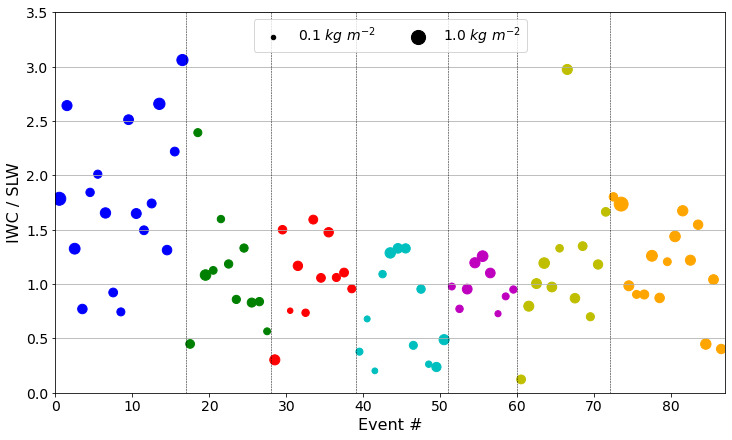

In [117]:
EventNum = np.arange(0,88,1)

plt.figure(figsize = (12,7))
fig.set_size_inches(11, 4)
plt.scatter(-1, -1, 0.1*200, color = 'k', label = '0.1 $kg$ $m^{-2}$')
plt.scatter(-1, -1, 1*200, color = 'k', label = '1.0 $kg$ $m^{-2}$')
plt.scatter(0.5+EventNum[0:17], (integ_IWC_events[0:17]) / (integ_SLW_events[0:17]), color = 'b', s = integ_SLW_events[0:17]*200)
plt.scatter(0.5+EventNum[17:28], (integ_IWC_events[17:28]) / (integ_SLW_events[17:28]), color = 'g', s = integ_SLW_events[17:28]*200)
plt.scatter(0.5+EventNum[28:39], (integ_IWC_events[28:39]) / (integ_SLW_events[28:39]), color = 'r', s = integ_SLW_events[28:39]*200)
plt.scatter(0.5+EventNum[39:51], (integ_IWC_events[39:51]) / (integ_SLW_events[39:51]), color = 'c', s = integ_SLW_events[39:51]*200)
plt.scatter(0.5+EventNum[51:60], (integ_IWC_events[51:60]) / (integ_SLW_events[51:60]), color = 'm', s = integ_SLW_events[51:60]*200)
plt.scatter(0.5+EventNum[60:72], (integ_IWC_events[60:72]) / (integ_SLW_events[60:72]), color = 'y', s = integ_SLW_events[60:72]*200)
plt.scatter(0.5+EventNum[72:87], (integ_IWC_events[72:87]) / (integ_SLW_events[72:87]), color = 'orange', s = integ_SLW_events[72:87]*200)
plt.xlabel('Event #', fontsize = 16)
plt.ylabel('IWC / SLW', fontsize = 16)
plt.grid(axis = 'y')
plt.xlim([0, 87])
plt.ylim([0, 3.5])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.plot([17, 17], [0, 120000], '--k', linewidth = 0.5)
plt.plot([28, 28], [0, 120000], '--k', linewidth = 0.5)
plt.plot([39, 39], [0, 120000], '--k', linewidth = 0.5)
plt.plot([51, 51], [0, 120000], '--k', linewidth = 0.5)
plt.plot([60, 60], [0, 120000], '--k', linewidth = 0.5)
plt.plot([72, 72], [0, 120000], '--k', linewidth = 0.5)
plt.legend(fontsize = 14, ncol = 7, loc = 'upper center');
plt.show()

## Figure 11 - Scatter Plot of the Snow Accumulation to Supercooled Liquid Water Content

- Snow Accumulation per Event (but only where it's snowing)

In [118]:
SNOWNC_snowie = xr.open_dataarray(Saved_Data_Path + '/SNOWNC_snowie.nc')
SNOWNC_snowie_chunked = SNOWNC_snowie.chunk({'Time':24})

In [119]:
SNOWNC_snowie_Events_new = np.zeros([sum(EventsPerMonth)])

for j in range(0,sum(EventsPerMonth)):
    dummy = (SNOWNC_snowie_chunked[EventTimesEnd[j],:,:] - SNOWNC_snowie_chunked[EventTimesStart[j],:,:]).compute()
    dummy = dummy.where(dummy > 0.1)
    SNOWNC_snowie_Events_new[j] = np.nanmean(dummy)

In [82]:
SNOWNC_snowie_Events_new

array([ 1.49441874,  2.77976966,  8.95640373,  3.09064794,  2.14432287,
        1.03937435,  5.7507863 ,  1.80372131,  0.39420822,  4.35626411,
        6.35990572,  3.76391244,  1.49723554,  2.26305056,  1.22738302,
        3.80336928,  3.87844181,  0.95653409,  4.61602592,  3.71779943,
        1.45770025,  1.01181722,  2.67851257,  1.29650009,  3.4797802 ,
        1.42078543,  6.51740694,  3.20525718,  1.31240129,  9.28827381,
        1.03608203, 15.37496948,  4.36276007, 19.63176346,  1.384408  ,
        6.65097666, 12.3476963 ,  6.51082468,  1.26684463,  0.37098122,
        2.15707064,  0.14656793,  5.34505129,  4.9818368 , 28.84995842,
       11.8169899 ,  2.16855359,  5.74684477,  0.64016712,  0.32794368,
        4.70913076,  0.38228759,  2.34221554, 15.70526314, 25.49734116,
        5.71175861, 25.48474121,  3.29231143,  2.95158386,  2.82720661,
        0.26508173, 23.89259148,  1.98758578,  3.8353374 ,  3.76050925,
        1.92076397,  4.01525545,  1.60921776,  4.47059488,  0.87

- Old

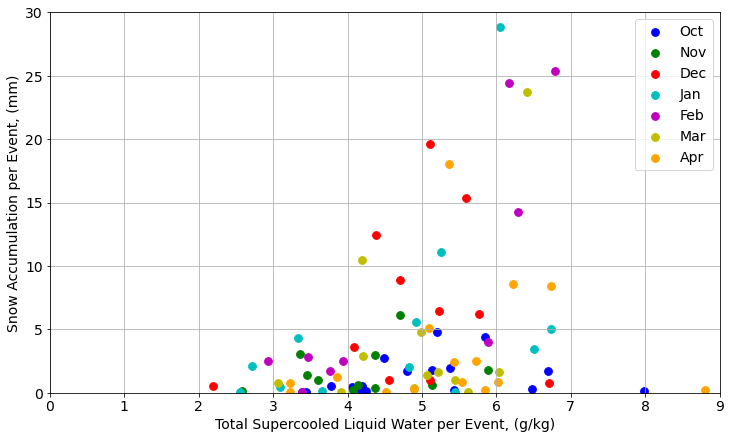

In [83]:
plt.figure(figsize = (12,7))
plt.scatter((QRAIN_below_zero[0:17]+QCLOUD_below_zero[0:17])*1000, EventPrecip[0:17], color = 'b', s = 60)
plt.scatter((QRAIN_below_zero[17:28]+QCLOUD_below_zero[17:28])*1000, EventPrecip[17:28], color = 'g', s = 60)
plt.scatter((QRAIN_below_zero[28:39]+QCLOUD_below_zero[28:39])*1000, EventPrecip[28:39], color = 'r', s = 60)
plt.scatter((QRAIN_below_zero[39:51]+QCLOUD_below_zero[39:51])*1000, EventPrecip[39:51], color = 'c', s = 60)
plt.scatter((QRAIN_below_zero[51:60]+QCLOUD_below_zero[51:60])*1000, EventPrecip[51:60], color = 'm', s = 60)
plt.scatter((QRAIN_below_zero[60:72]+QCLOUD_below_zero[60:72])*1000, EventPrecip[60:72], color = 'y', s = 60)
plt.scatter((QRAIN_below_zero[72:87]+QCLOUD_below_zero[72:87])*1000, EventPrecip[72:87], color = 'orange', s = 60)
plt.grid()
plt.xlim([0, 9])
plt.ylim([0, 30])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Total Supercooled Liquid Water per Event, (g/kg)', fontsize = 14)
plt.ylabel('Snow Accumulation per Event, (mm)', fontsize = 14)
plt.legend(labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'], fontsize = 14);

- New

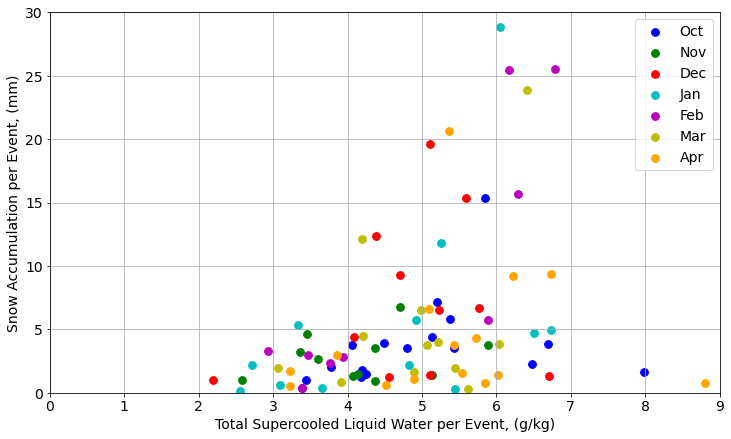

In [129]:
plt.figure(figsize = (12,7))
plt.scatter((QRAIN_below_zero[0:17]+QCLOUD_below_zero[0:17])*1000, SNOWNC_snowie_Events_new[0:17], color = 'b', s = 60)
plt.scatter((QRAIN_below_zero[17:28]+QCLOUD_below_zero[17:28])*1000, SNOWNC_snowie_Events_new[17:28], color = 'g', s = 60)
plt.scatter((QRAIN_below_zero[28:39]+QCLOUD_below_zero[28:39])*1000, SNOWNC_snowie_Events_new[28:39], color = 'r', s = 60)
plt.scatter((QRAIN_below_zero[39:51]+QCLOUD_below_zero[39:51])*1000, SNOWNC_snowie_Events_new[39:51], color = 'c', s = 60)
plt.scatter((QRAIN_below_zero[51:60]+QCLOUD_below_zero[51:60])*1000, SNOWNC_snowie_Events_new[51:60], color = 'm', s = 60)
plt.scatter((QRAIN_below_zero[60:72]+QCLOUD_below_zero[60:72])*1000, SNOWNC_snowie_Events_new[60:72], color = 'y', s = 60)
plt.scatter((QRAIN_below_zero[72:87]+QCLOUD_below_zero[72:87])*1000, SNOWNC_snowie_Events_new[72:87], color = 'orange', s = 60)
plt.grid()
plt.xlim([0, 9])
plt.ylim([0, 30])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Total Supercooled Liquid Water per Event, (g/kg)', fontsize = 14)
plt.ylabel('Snow Accumulation per Event, (mm)', fontsize = 14)
plt.legend(labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'], fontsize = 14);

In [141]:
1000*100*SLW_event_sum[73], 1000*100*SLW_event_mean[73]

(6.86394687079428, 0.11633808255583525)

In [140]:
1000*100*SLW_event_sum[44], 1000*100*SLW_event_mean[44]

(5.253345483247074, 0.08338643624201704)

- Old

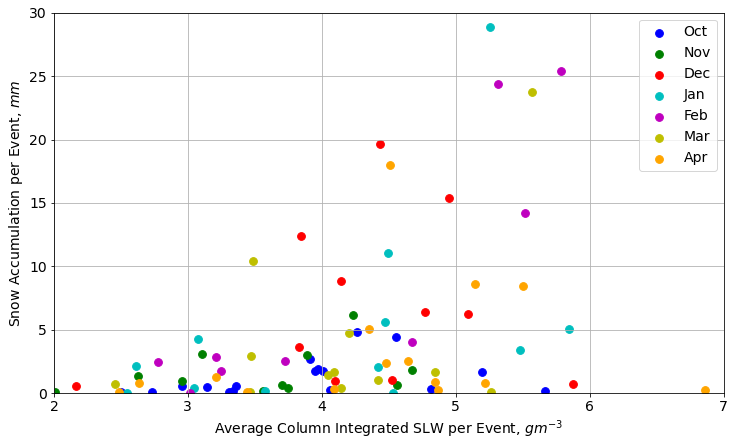

In [136]:
plt.figure(figsize = (12,7))
plt.scatter((SLW_event_sum[0:17]), EventPrecip[0:17], color = 'b', s = 60)
plt.scatter((SLW_event_sum[17:28]), EventPrecip[17:28], color = 'g', s = 60)
plt.scatter((SLW_event_sum[28:39]), EventPrecip[28:39], color = 'r', s = 60)
plt.scatter((SLW_event_sum[39:51]), EventPrecip[39:51], color = 'c', s = 60)
plt.scatter((SLW_event_sum[51:60]), EventPrecip[51:60], color = 'm', s = 60)
plt.scatter((SLW_event_sum[60:72]), EventPrecip[60:72], color = 'y', s = 60)
plt.scatter((SLW_event_sum[72:87]), EventPrecip[72:87], color = 'orange', s = 60)
plt.grid()
# plt.yscale('log')
# plt.ylim([0.01, 100])
plt.ylim([0,30])
plt.xlim([2, 7])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Average Column Integrated SLW per Event, $gm^{-3}$', fontsize = 14)
plt.ylabel('Snow Accumulation per Event, $mm$', fontsize = 14)
plt.legend(labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'], fontsize = 14);

- New

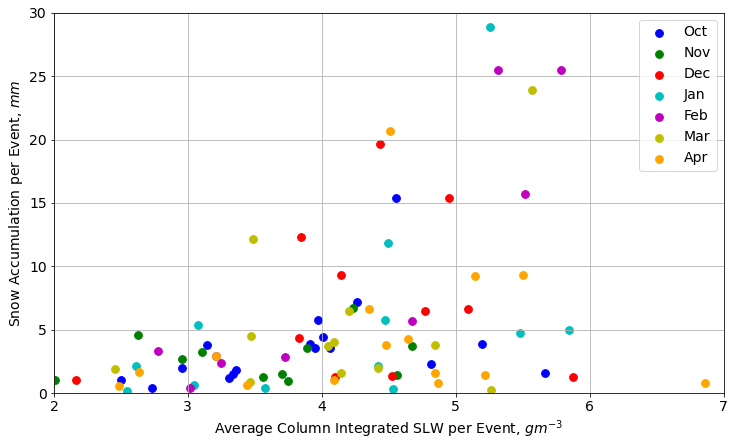

In [137]:
plt.figure(figsize = (12,7))
plt.scatter((SLW_event_sum[0:17])*100*1000, SNOWNC_snowie_Events_new[0:17], color = 'b', s = 60)
plt.scatter((SLW_event_sum[17:28])*100*1000, SNOWNC_snowie_Events_new[17:28], color = 'g', s = 60)
plt.scatter((SLW_event_sum[28:39])*100*1000, SNOWNC_snowie_Events_new[28:39], color = 'r', s = 60)
plt.scatter((SLW_event_sum[39:51])*100*1000, SNOWNC_snowie_Events_new[39:51], color = 'c', s = 60)
plt.scatter((SLW_event_sum[51:60])*100*1000, SNOWNC_snowie_Events_new[51:60], color = 'm', s = 60)
plt.scatter((SLW_event_sum[60:72])*100*1000, SNOWNC_snowie_Events_new[60:72], color = 'y', s = 60)
plt.scatter((SLW_event_sum[72:87])*100*1000, SNOWNC_snowie_Events_new[72:87], color = 'orange', s = 60)
plt.grid()
# plt.yscale('log')
# plt.ylim([0.01, 100])
plt.ylim([0,30])
plt.xlim([2, 7])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Average Column Integrated SLW per Event, $gm^{-3}$', fontsize = 14)
plt.ylabel('Snow Accumulation per Event, $mm$', fontsize = 14)
plt.legend(labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'], fontsize = 14);

In [144]:
SNOWNC_snowie_Events_new[44]

28.849958419799805

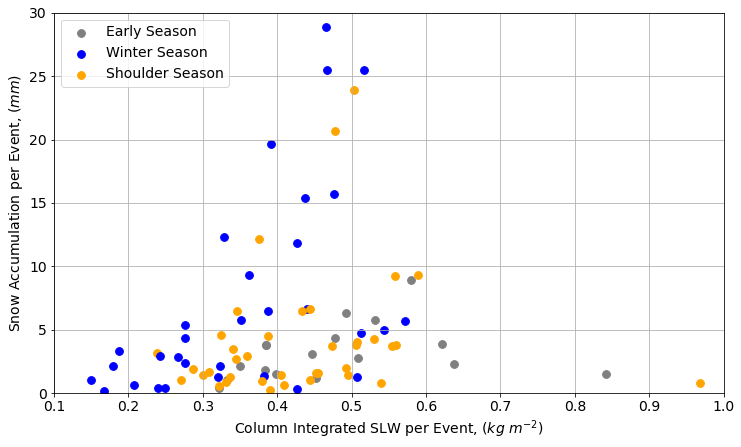

In [121]:
plt.figure(figsize = (12,7))
fig.set_size_inches(11, 4)

plt.scatter((integ_SLW_events[0:17]), SNOWNC_snowie_Events_new[0:17], color = 'grey', s = 60)
plt.scatter((integ_SLW_events[28:39]), SNOWNC_snowie_Events_new[28:39], color = 'b', s = 60)
plt.scatter((integ_SLW_events[17:28]), SNOWNC_snowie_Events_new[17:28], color = 'orange', s = 60)
plt.scatter((integ_SLW_events[39:51]), SNOWNC_snowie_Events_new[39:51], color = 'b', s = 60)
plt.scatter((integ_SLW_events[51:60]), SNOWNC_snowie_Events_new[51:60], color = 'b', s = 60)
plt.scatter((integ_SLW_events[60:72]), SNOWNC_snowie_Events_new[60:72], color = 'orange', s = 60)
plt.scatter((integ_SLW_events[72:87]), SNOWNC_snowie_Events_new[72:87], color = 'orange', s = 60)
plt.grid()
# plt.yscale('log')
# plt.ylim([0.01, 100])
plt.ylim([0,30])
plt.xlim([0.1, 1])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Column Integrated SLW per Event, ($kg$ $m^{-2}$)', fontsize = 14)
plt.ylabel('Snow Accumulation per Event, ($mm$)', fontsize = 14)
plt.legend(labels = ['Early Season', 'Winter Season', 'Shoulder Season'], fontsize = 14, loc = 'upper left');

In [ ]:
plt.figure(figsize = (12,7))
plt.scatter((SLW_event_sum[0:17])*100*1000, SNOWNC_snowie_Events_new[0:17], color = 'b', s = 60)
plt.scatter((SLW_event_sum[28:39])*100*1000, SNOWNC_snowie_Events_new[28:39], color = 'g', s = 60)
plt.scatter((SLW_event_sum[17:28])*100*1000, SNOWNC_snowie_Events_new[17:28], color = 'b', s = 60)
plt.scatter((SLW_event_sum[39:51])*100*1000, SNOWNC_snowie_Events_new[39:51], color = 'g', s = 60)
plt.scatter((SLW_event_sum[51:60])*100*1000, SNOWNC_snowie_Events_new[51:60], color = 'g', s = 60)
plt.scatter((SLW_event_sum[60:72])*100*1000, SNOWNC_snowie_Events_new[60:72], color = 'b', s = 60)
plt.scatter((SLW_event_sum[72:87])*100*1000, SNOWNC_snowie_Events_new[72:87], color = 'b', s = 60)
plt.grid()
# plt.yscale('log')
# plt.ylim([0.01, 100])
plt.ylim([0,30])
plt.xlim([2, 7])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Average Column Integrated SLW per Event, $gm^{-3}$', fontsize = 14)
plt.ylabel('Snow Accumulation per Event, $mm$', fontsize = 14)
plt.legend(labels = ['Shoulder Season', 'Winter Season'], fontsize = 14, loc = 'upper left');

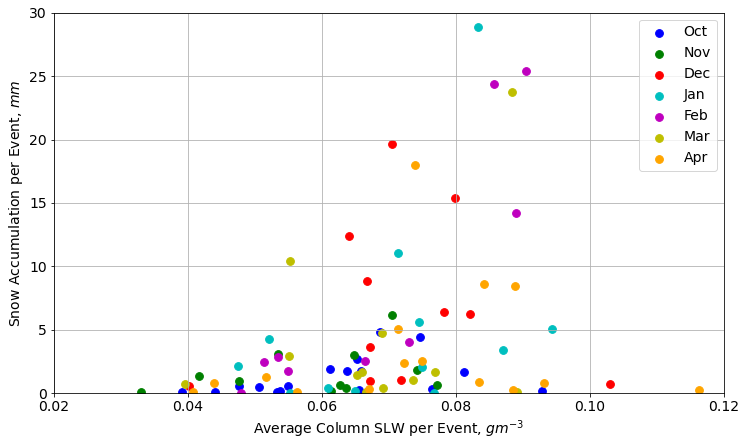

In [138]:
plt.figure(figsize = (12,7))
plt.scatter((SLW_event_mean[0:17])*100*1000, EventPrecip[0:17], color = 'b', s = 60)
plt.scatter((SLW_event_mean[17:28])*100*1000, EventPrecip[17:28], color = 'g', s = 60)
plt.scatter((SLW_event_mean[28:39])*100*1000, EventPrecip[28:39], color = 'r', s = 60)
plt.scatter((SLW_event_mean[39:51])*100*1000, EventPrecip[39:51], color = 'c', s = 60)
plt.scatter((SLW_event_mean[51:60])*100*1000, EventPrecip[51:60], color = 'm', s = 60)
plt.scatter((SLW_event_mean[60:72])*100*1000, EventPrecip[60:72], color = 'y', s = 60)
plt.scatter((SLW_event_mean[72:87])*100*1000, EventPrecip[72:87], color = 'orange', s = 60)
plt.grid()
# plt.yscale('log')
# plt.ylim([0.01, 100])
plt.xlim([0.02, 0.12])
plt.ylim([0.0, 30])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Average Column SLW per Event, $gm^{-3}$', fontsize = 14)
plt.ylabel('Snow Accumulation per Event, $mm$', fontsize = 14)
plt.legend(labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'], fontsize = 14);